# 爬網頁

In [55]:
# 確認路徑為 '/Users/karenwang/Desktop/Program/Python/SpiderCourse/PythonHW/'

In [487]:
cd ..

/Users/karenwang/Desktop/Program/Python/SpiderCourse/PythonHW


# 第二屆Python網路爬蟲期末專題_Karen Wang
# 一、專題摘要解釋實作與說明需要解決的問題，限300~500字。

1. 期末專題主題  
爬取政黑版政黑板：https://www.ptt.cc/bbs/HatePolitics/index.htmlPtt 討論版的文章作分析
2. 期末專題基本目標  
    1. 爬下文章，透過 jieba 等斷詞將文章拆解
    2. 可以簡單的計算同樣文字出現的頻率或是透過 TFIDF 的統計方式計算
    3. 將經常出現的 stop words 過濾掉之後對頻率進行排名
    4. 將結果透過 wordcloud 文字雲的方式呈現
    5. 透過不同帳號，但是相同 IP 且政治用語的詞頻分佈類似的定位成網軍（進階）
    6. 進一步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性（進階）
    7. 如果不同帳號但是政治用語的詞頻分佈類似，進一步判斷這些高頻率的單字是positive / negative 來歸納兩個帳號之間是否具有相同政治立場（進階）  
 
# 二、實作方法：

##  專題分為兩部分
1. 爬網頁文章  
2. 文章內容訊息處理（分詞頻率、ＩＰ、帳號、文字雲等等。）

In [56]:
# 定義function做文章爬取與內容分類，並寫成json存檔
import requests
from bs4 import BeautifulSoup
import json
import time
import _thread
import re
from urllib.parse import urljoin, urlparse
from pathlib import Path


host = 'https://www.ptt.cc'
cookies = {'over18': '1'}
# board_list = ['Stock', 'Gossiping', 'Lifeismoney', 'movie', 'cookclub', 'Finance']
board_list = ['Gossiping', 'Stock'] # for board spider...

# https://www.ptt.cc/bbs/Gossiping/index.html
# https://www.ptt.cc/bbs/Gossiping/index39130.html
# https://www.ptt.cc/bbs/Gossiping/39130index.html
pageStart = 4088
pageNumbers = 30


front_url_list = ['https://www.ptt.cc/bbs/HatePolitics/index.html']

for i in range(pageNumbers):
    indexNum_url = 'https://www.ptt.cc/bbs/HatePolitics/index{}.html'.format(pageStart - i)
    front_url_list.append(indexNum_url)

# 各function: 首頁文章列表, 文章內容, 寫入檔案, 多線程爬文章並寫入檔案
#

#首頁文章列表
def parse(response):
    article_title = []
    article_URL = []
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(response.url))
        return
    soup = BeautifulSoup(response.text)
    main_list = soup.find('div', class_='bbs-screen')

    # 依序檢查文章列表中的 tag, 遇到分隔線就結束，忽略這之後的文章
    for div in main_list.findChildren('div', recursive=False):
        class_name = div.attrs['class']

        # 遇到分隔線要處理的情況
        if class_name and 'r-list-sep' in class_name:
            print('Reach the last article')
            break

        # 遇到目標文章
        if class_name and 'r-ent' in class_name:
            div_title = div.find('div', class_='title')
            a_title = div_title.find('a', href=True)
            # 如果文章已經被刪除則跳過
            if not a_title or not a_title.has_attr('href'):
                continue
            article_URL.append(host + a_title['href'])
            article_title.append(a_title.text)
            print('Parse article {}'.format(article_title[-1]), article_URL[-1])
    return article_title, article_URL

# # 文章內容simple(myselfe)
# def parse_article(response):
#     # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
#     if response.status_code != 200:
#         print('Error - {} is not available to access'.format(response.url))
#         return
#     soup = BeautifulSoup(response.text)
#     data = {}
#     data['url'] = response.url
#     for i in soup.find_all(class_='article-metaline'):
#         data[i.find(class_='article-meta-tag').text] = i.find(class_='article-meta-value').text
#         print(i.find(class_='article-meta-tag').text, ':',  i.find(class_='article-meta-value').text)

#     data['context'] = soup.find(id='main-container').text.split('\n')
#     print('\n====== text ======\n', soup.find(id='main-container').text.split('\n'))

#     print('data: ', data)
#     return data


# 文章內容complex
def parse_article(response):
    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(response.url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text)


    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件 
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime})
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量 
    message_count = {'all': p+b+n, 'count': p-b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊
    data = {}
    article_id = str(Path(urlparse(response.url).path).stem)
    data['url'] = response.url
    data['article_id'] = article_id
    data['article_author'] = author
    data['article_title'] = title
    data['article_date'] = date
    data['article_content'] = content
    data['ip'] = ip
    data['message_count'] = message_count
    data['messages'] = messages
    return data


# 寫入檔案
def write2file(jsondata, filepath): 
    with open(filepath,"a") as f:
        json.dump(jsondata ,f, ensure_ascii=False)
        f.write("\n")
        print("載入入檔案完成...")
        
# 多線程爬文章並寫入檔案
def multirequests(para_url, cookies, para_board):
    print(para_url)
    response = requests.get(para_url, cookies = cookies)
    data = parse_article(response)
    print(data)
    filepath = 'ProjectData/' + para_board +'.json'
    write2file(data, filepath)



In [57]:
front_url_list

['https://www.ptt.cc/bbs/HatePolitics/index.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4088.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4087.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4086.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4085.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4084.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4083.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4082.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4081.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4080.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4079.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4078.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4077.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4076.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4075.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4074.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4073.html',
 'https://www.ptt.cc/bbs/HatePolitics/index4072.html',
 'https://www.

In [58]:
# 開始爬文章並存成json檔
# https://www.ptt.cc/bbs/Stock/index.html
# https://www.ptt.cc/bbs/Stock/index5007.html  

article_jsonFile_name = 'HatePolitics'
for target_url in front_url_list:
#     url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board)
    url = target_url
    article_response = requests.get(url, cookies = cookies)
    article_URLlist = parse(article_response)[1]
    
    # article context
    for article_URL in article_URLlist:
        _thread.start_new_thread( multirequests, (article_URL, cookies, article_jsonFile_name,) )


Parse article Re: [討論] 酷邦卷的問題在哪？ https://www.ptt.cc/bbs/HatePolitics/M.1587708509.A.9A9.html
Parse article [黑特]會去當口賣機志工是什麼人? https://www.ptt.cc/bbs/HatePolitics/M.1587708610.A.F5F.html
Parse article [新聞] 磐石艦再增1例 全艦累計30人確診新冠肺炎 https://www.ptt.cc/bbs/HatePolitics/M.1587708666.A.749.html
Parse article [討論] 4/23 發布 韓國瑜 防疫滿意度 https://www.ptt.cc/bbs/HatePolitics/M.1587708681.A.B8F.html
Parse article Re: [黑特] 反對普篩，怎麼不嗆韓國？ https://www.ptt.cc/bbs/HatePolitics/M.1587708863.A.19E.html
Parse article [黑特] 台灣人是不是覺醒了 https://www.ptt.cc/bbs/HatePolitics/M.1587708908.A.F5A.html
Parse article Re: [新聞] 逾2千醫事人員連署反普篩 高市衛生局： https://www.ptt.cc/bbs/HatePolitics/M.1587708976.A.63D.html
Parse article [討論] 柯文哲最大錯誤是不是北門會 https://www.ptt.cc/bbs/HatePolitics/M.1587709125.A.887.html
Parse article [討論] 口罩4.0可否突破波次的限制？ https://www.ptt.cc/bbs/HatePolitics/M.1587709224.A.26A.html
Parse article Re: [討論] 韓國瑜跟 侯友宜的差別到底在哪啊 https://www.ptt.cc/bbs/HatePolitics/M.1587710085.A.F2E.html
Parse article Re: [討論] 柯文哲最大錯誤是不是北門會 http

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587708610.A.F5F.html', 'article_id': 'M.1587708610.A.F5F', 'article_author': 'dahanjian (強煎飯)', 'article_title': '[黑特]會去當口賣機志工是什麼人?', 'article_date': 'Fri Apr 24 14:10:06 2020', 'article_content': '正黑台巴子大家好\n\n柯屁 aka 中國警犬\n\n的德政 口罩販賣機 一台需要 四五個志工\n\n加上柯屁的市府文化基金會 巧立名目\n\n大肆擴充到 200多人 還給詹一扇巧立名目\n\n月領14萬 發言人擴充到6個 機要秘書8個\n\n這麼爽的台北市府 遽然有人還去當口賣機的志工??\n\n本尊在這裡抗議 口賣機志工應全部轉為市府正式員工\n\n怎麼可以獨厚政二代 ????\n\n我操  這些人是范建? 還是蠢柯糞阿\n\n台北市府這麼好進還去當志工\n\n\n尼瑪的 阿呆嗎??? 呵呵\n\n\n = 柯痞 https://www.ptt.cc/bbs/HatePolitics/M.1587708610.A.F5F.html', 'ip': '218.164.37.15', 'message_count': {'all': 5, 'count': 1, 'push': 2, 'boo': 1, 'neutral': 2}, 'messages': [{'push_tag': '推', 'push_userid': 'ChinkFilmsZZ', 'push_content': '智障柯粉', 'push_ipdatetime': '220.133.103.168 04/24 14:10'}, {'push_tag': '推', 'push_userid': 'wowpoqwow', 'push_content': 'http://i.imgur.com/cBwaDlA.jpg', 'push_ipdatetime': '180.217.140.235 04/24 14:19'}, {'push_tag': '→', 'push_userid': 'younggrass', 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587710919.A.712.html', 'article_id': 'M.1587710919.A.712', 'article_author': 'Stigmata (賣女孩的小火柴)', 'article_title': '[討論] 陳學聖跟54why哪個比較雷?', 'article_date': 'Fri Apr 24 14:48:37 2020', 'article_content': '54why要求交出敦睦艦隊航跡圖\n\n陳學聖則說軍方要交出航海日誌 不准拒絕\n\n國民黨怎麼都出這種人啊?\n\n相對之下\n\n直接嗆明他就是中共同路人的白狼\n\n還有\n\n直接答應擔任國民黨中常委的韓禿\n\n是不是都比較光明磊落了啊\n\n嘻嘻\n\n\nSent from my Windows\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587710919.A.712.html', 'ip': '42.72.94.227', 'message_count': {'all': 6, 'count': 4, 'push': 4, 'boo': 0, 'neutral': 2}, 'messages': [{'push_tag': '推', 'push_userid': 'CenaWang', 'push_content': '當然是韓導', 'push_ipdatetime': '223.140.235.254 04/24 14:49'}, {'push_tag': '推', 'push_userid': 'z739', 'push_content': '秒選聖', 'push_ipdatetime': '118.166.51.41 04/24 14:50'}, {'push_tag': '推', 'push_userid': 'holyhelm', 'push_content': '聖還是比較雷', 'push_ipdatetime': '218.164.78.168 04/24 14:52'}, {'push_tag': '推', 'push_userid': 'shadow0326', 'push_content

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587706973.A.D80.html', 'article_id': 'M.1587706973.A.D80', 'article_author': 'weni302 (鏡花水月號)', 'article_title': 'Re: [討論] 韓國瑜跟 侯友宜的差別到底在哪啊', 'article_date': 'Fri Apr 24 13:42:51 2020', 'article_content': ': 說起來 韓國瑜跟 侯友宜的差別到底在哪啊？ 侯友宜在4/14提出 將於4/20進行 擴大管制兵棋推演 這個時期\n\n正是 國內疫情趨緩 的時候\n\n接連出現好幾次0確診\n\n不但被 媒體扭曲成 將要執行 封城演習 也引起 不少人質疑 並 批評侯友宜太超過 是在作秀 侯友宜雖然不斷澄清是要舉辦 擴大管制的兵棋推演 並非封城演習\n\n但仍飽受 質疑與批評 在這段 不少人沉浸於0確診的安逸 時刻\n\n侯友宜仍以 戒慎恐懼 防範未然 的態度\n\n扛著質疑與批評\n\n積極面對 謹慎處理防疫相關的事務\n\n並成功舉辦了擴大管制的兵棋推演\n\n結束後也不吝嗇 分享成果經驗給 中央 與 各縣市 說韓國瑜與侯友宜的差別\n\n就以防疫而言\n\n侯友宜具備 積極謹慎 防範未然 的態度是最大的差別\n\n且勇於面對質疑 不怕被罵 堅持守護人民的健康與安全\n\n這也反映在六都防疫滿意度調查結果 讓侯友宜拿下第一名 最高滿意度的成果 https://www.ptt.cc/bbs/HatePolitics/M.1587706973.A.D80.html 侯友宜靠自己的性格與態度\n\n贏得這些肯定', 'ip': '114.136.61.202', 'message_count': {'all': 3, 'count': 0, 'push': 1, 'boo': 1, 'neutral': 1}, 'messages': [{'push_tag': '噓', 'push_userid': 'ihaveseven', 'push_content': '混混和正直警察的差別', 'push_ipdatetime': '180.217.146.220 04/24 13:44'

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587706942.A.94A.html', 'article_id': 'M.1587706942.A.94A', 'article_author': 'chiuan0982 (嚐嚐老納的棒子)', 'article_title': '[黑特] 反對普篩，怎麼不嗆韓國？', 'article_date': 'Fri Apr 24 13:42:20 2020', 'article_content': '綠粉一直吵普篩浪費，台灣案例少，\n不用普篩？\n卻忘記韓國什麼時候開始普篩的？\n韓國確診病例不到一千就開始普篩了\n台灣人口不到南韓一半\n以南韓為普篩標準，台灣500例是否要開始\n考慮普篩？而目前也400多例了，難到不可\n以討論嗎？\n台灣有能力捐將近2000萬口罩給其他國家\n以一個口罩它國市價至少10元\n台灣已經捐了2億起跳\n有能力幫助它國，為何不幫助自己人民\n而且是站在一線的醫療人員\n至於高雄市市長提出\n因應疫情，高雄醫療人員全面普篩\n人數也不過4000人，市長也把錢準備好了\n這樣也要被罵？\n有說篩檢不能上班14天嗎？\n如果第一次篩完真有確診\n難到不該抓出來嗎？\n況且聽說想參加普篩不到2000人\n這是占多大的檢驗壓力？\n台灣不是一天可以驗3000嗎？\n才2000人，不到一個禮拜就驗完了\n到底有啥好吵的？\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587706942.A.94A.html', 'ip': '180.217.204.75', 'message_count': {'all': 122, 'count': -1, 'push': 6, 'boo': 7, 'neutral': 109}, 'messages': [{'push_tag': '推', 'push_userid': 'downtoearth', 'push_content': '這到底是崩潰成怎樣 才會覺得韓國', 'push_ipdatetime': '59.125.101.96 04/24 13:44'}, {'push_tag': '→', 'push_userid': 'KimWexler', 'push_

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587705213.A.18A.html', 'article_id': 'M.1587705213.A.18A', 'article_author': 'jfw616 (jj)', 'article_title': 'Re: [新聞] 逾2千醫事人員連署反普篩 高市衛生局：', 'article_date': 'Fri Apr 24 13:13:31 2020', 'article_content': '國民黨早就打電話給習近平\n跪台辦早就準備好無限資源給韓國瑜了\n\n現在就等韓國瑜上場宣布救援\n只要韓國瑜一聲令下\n中共的戰機戰艦\n隨時都能跨越台海中線\n補給韓國瑜需要的物資\n\n所以我實在不懂你們擔心什麼\n現在就是私底下還在橋而已 : 醫護普篩用意良好，但前提是你有無限的資源，像是無限的金錢跟無限的人力 : 在這種情況下，這樣搞當然沒有問題。 : 醫護要普篩，這就會扯出很多問題，像是多久要普篩一次? 每天篩 還是一星期篩一次 ? : 從敦睦艦隊的事件就可以得知，有時候今天有人驗出陰性，可是明天就會出現陽性 : 那要多久驗一次? : 今天驗了，就代表明天沒問題嗎? : 如果要讓每個醫護都有辦法確定陰性後才上班，那要買幾台才夠阿? @@ : 每個醫院都先買個一百台這樣嗎? : 所以我才說，韓國瑜適合在那種無限資源的地方當管理者 : 最好就打個: show me the money，然後木材就1000 黃金1000這種 : 從他開始選高雄市長總統就是這個樣子， : 南海挖石油， : 愛情摩天輪， : 南部大機場， : 故宮文物一次展， : 完全沒有成本概念，模式根本一模一樣 : 哭哭~~ https://www.ptt.cc/bbs/HatePolitics/M.1587705213.A.18A.html', 'ip': '113.210.99.57', 'message_count': {'all': 2, 'count': 1, 'push': 1, 'boo': 0, 'neutral': 1}, 'messages': [{'push_tag': '推', 'push_userid': 'isaacting', 'push_content': '中國來

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587705481.A.181.html', 'article_id': 'M.1587705481.A.181', 'article_author': 'victoryman (沒有)', 'article_title': '[新聞] 北市口罩販賣機增文山萬華 視中央3.0決定', 'article_date': 'Fri Apr 24 13:17:59 2020', 'article_content': '1.新聞網址 https://www.cna.com.tw/news/ahel/202004240086.aspx 2.新聞來源 中央社 3.新聞內容 北市口罩販賣機增文山萬華 視中央3.0決定後續\n\n最新更新：2020/04/24 13:06\n\n（中央社記者陳怡璇台北24日電）台北市副市長黃珊珊表示，台北市口罩販賣機新增至文\n山區與萬華區，加上原本的信義區，共3個點先試辦，後續視中央口罩3.0對販賣機的影響\n，再決定怎麼推動。\n\n黃珊珊主持台北市流行疫情指揮中心會議，表示口罩自動販賣機除了一開始設置的信\n義區，新增試辦文山區及萬華區的健康服務中心，而因台北市議會財建委員會決議，釐清\n超商預購口罩3.0版啟動對販賣機的影響，後續將再視3.0狀況，決定後續推動方式。\n\n因昨晚販賣機採購案流標，黃珊珊坦言因為成本計算方式與後續作業還不太明確，所以會\n先就這3個據點的試辦成效評估要花多少成本。\n\n此外，台北市聯營公車3月運量較去年同期減少約676萬人次，約下降16%，營收減少新台\n幣1.4億元，黃珊珊表示，北市將補助每車每月8000元，助業者度過難關。\n\n對北市聯營公車補助還有運價不折減車廂廣告收入，營業車輛也可展延汰舊換新年限，期\n限最長1年，展延期限不扣除價差補貼金額。（編輯：李錫璋）1090424 4.附註、心得、想法 希望有不錯的成績\n\n3.0也是一個不錯的制度\n\n再視3.0狀況之後  決定後續推動方式\n\n文山 萬華區 也有販賣機了 希望能多多使用\n\n減少工作人員的工作量  同時提供無接觸服務\n\n加油\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587705481.

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587703200.A.B0C.html', 'article_id': 'M.1587703200.A.B0C', 'article_author': 'isaluku (山本君)', 'article_title': 'Re: [討論] 何時輪到韓國瑜的時代結束?', 'article_date': 'Fri Apr 24 12:39:58 2020', 'article_content': ': 韓國瑜在今年年初的總統大選 : 拿下552萬票，比國民黨政黨票的471萬還多 : 當然也遠勝柯文哲的民眾黨 : 這政壇風雲人物還在高雄呼風起浪 : 罷韓如果失敗也可能劍指國民黨黨主席，挑戰2024 : 比起已經結束的柯文哲，我比較擔憂何時換中共力捧的韓國瑜時代結束呢? 他拿的票有552萬？你不能這樣算\n\n這次的投票率75，如果對上2016年的投票率66的話，他只算拿了55266/75485萬\n\n再扣掉從宋楚瑜這邊跑回去的票，宋今年拿了60萬，對照2016年他會拿6066/7552萬\n也就是宋損失了1505298萬，跑過去韓那邊。如果把這98萬扣掉\n\n485萬98萬387萬\n\n......................不好意思，韓沒比朱強多少，大概就是比朱能多吸宋的票而已。\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587703200.A.B0C.html', 'ip': '163.20.242.34', 'message_count': {'all': 7, 'count': 3, 'push': 3, 'boo': 0, 'neutral': 4}, 'messages': [{'push_tag': '推', 'push_userid': 'gerund', 'push_content': '這算法給韓粉看他們會崩潰', 'push_ipdatetime': '36.233.50.109 04/24 12:45'}, {'push_tag': '推', 'push_userid': 'MVPGGYY', 'push_content': '你不能把宋的扣掉這樣算吧？', 'push_ipdatetime': 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587703462.A.059.html', 'article_id': 'M.1587703462.A.059', 'article_author': 'yeh67 (誠鳴雲水)', 'article_title': '[討論] 假設八月 高雄市長補選', 'article_date': 'Fri Apr 24 12:44:20 2020', 'article_content': '二月，就有高雄神通高人問神，罷免必過關，既然最辛苦的二階段半年都熬過了\n\n那麼，六月六日，聯署門檻兩倍，破六十萬人投罷免票，應該不難破關\n\n  預測高雄市長補選應該是三足鼎立\n\n1.民進黨  趙天麟、陳其邁 二選一  我預測會推趙天麟，陳其邁續待中央候補閣揆\n\n2.國民黨  李四川(副市長)、莊啟旺(黨部主委) 二選一當砲灰\n\n3.民眾黨  自己推人或與楊秋興合作，我建議柯主席與楊秋興合作才有勝算\n\n若楊秋興當選，民眾黨，攻下北高兩市，2022備戰全台氣勢大振，且在綠營不得志的\n\n遺珠都會帶槍投靠民眾黨選縣市議員、鄉鎮長(地方小派系)、縣市長可推菁英刷存在感\n\n柯文哲2022或成最大贏家或左右藍綠派系的關鍵少數，這對2024選總統都是利多，因此\n\n罷韓，對柯文哲與楊秋興都是天賜良機，合則雙贏，再次革新台灣價值的民主新契機\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587703462.A.059.html', 'ip': '218.166.46.195', 'message_count': {'all': 25, 'count': 9, 'push': 9, 'boo': 0, 'neutral': 16}, 'messages': [{'push_tag': '推', 'push_userid': 'Rrrxddd', 'push_content': '找楊秋興=自己作死', 'push_ipdatetime': '223.137.217.103 04/24 12:44'}, {'push_tag': '推', 'push_userid': 'pqbd22', 'push_content': '還真不關心', '

載入入檔案完成...
Parse article Re: [討論] 屬於柯文哲的時代結束了 https://www.ptt.cc/bbs/HatePolitics/M.1587700746.A.658.html
Parse article Re: [討論] 屬於柯文哲的時代結束了 https://www.ptt.cc/bbs/HatePolitics/M.1587700754.A.95C.html
Parse article [討論] 為什麼台灣川粉這麼多？ https://www.ptt.cc/bbs/HatePolitics/M.1587700804.A.5F3.html
Parse article Re: [討論] 屬於柯文哲的時代結束了 https://www.ptt.cc/bbs/HatePolitics/M.1587701016.A.15F.html
Parse article [討論] 高雄醫護全面普篩的壞處 https://www.ptt.cc/bbs/HatePolitics/M.1587701087.A.6B6.html
Parse article [新聞] 高雄市長韓國瑜宣布 高雄休閒娛樂八大行 https://www.ptt.cc/bbs/HatePolitics/M.1587701236.A.5C3.html
Parse article Re: [討論] 屬於柯文哲的時代結束了 https://www.ptt.cc/bbs/HatePolitics/M.1587701397.A.0D8.html
Parse article Re: [討論] 為什麼台灣川粉這麼多？ https://www.ptt.cc/bbs/HatePolitics/M.1587701527.A.264.html
Parse article [討論] 販賣機就多一個購買方式 被打成這樣是？ https://www.ptt.cc/bbs/HatePolitics/M.1587701623.A.0E8.html
Parse article Re: [討論] 屬於柯文哲的時代結束了 https://www.ptt.cc/bbs/HatePolitics/M.1587701764.A.BB2.html
Parse article [討論] 不懂反對普篩的人在想甚麼 https:/

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587702213.A.E99.html', 'article_id': 'M.1587702213.A.E99', 'article_author': 'nicetree (nicetree)', 'article_title': '[討論] 何時輪到韓國瑜的時代結束?', 'article_date': 'Fri Apr 24 12:23:30 2020', 'article_content': '韓國瑜在今年年初的總統大選\n\n拿下552萬票，比國民黨政黨票的471萬還多\n\n當然也遠勝柯文哲的民眾黨\n\n這政壇風雲人物還在高雄呼風起浪\n\n罷韓如果失敗也可能劍指國民黨黨主席，挑戰2024\n\n比起已經結束的柯文哲，我比較擔憂何時換中共力捧的韓國瑜時代結束呢?\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587702213.A.E99.html 2020 1月的大選他得票數552萬票，遠高國民黨及民眾黨\n大選完距今才3個多月，說完結還太早', 'ip': '220.136.156.22', 'message_count': {'all': 13, 'count': 6, 'push': 6, 'boo': 0, 'neutral': 7}, 'messages': [{'push_tag': '推', 'push_userid': 'bearcsjc', 'push_content': '快了', 'push_ipdatetime': '42.72.202.66 04/24 12:25'}, {'push_tag': '→', 'push_userid': 'brella', 'push_content': '韓家軍都死光了', 'push_ipdatetime': '27.247.11.179 04/24 12:25'}, {'push_tag': '推', 'push_userid': 'isaluku', 'push_content': '他的時代只有2018-2019 早已完結', 'push_ipdatetime': '163.20.242.34 04/24 12:26'}, {'push_tag': 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587701087.A.6B6.html', 'article_id': 'M.1587701087.A.6B6', 'article_author': 'zoeforce (呼呼呼嘩哈哈哈)', 'article_title': '[討論] 高雄醫護全面普篩的壞處', 'article_date': 'Fri Apr 24 12:04:45 2020', 'article_content': '高雄提醫護全面普篩的壞處是什麼？\n\n有點看不懂大家反對的原因，\n\n比如說看到有人講：根本就是想封城。\n\n不是阿，醫護全面篩檢跟封城什麼關係？\n\n\n\n\n普篩的壞處在哪？\n\n人權問題？單日檢驗能量問題？\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587701087.A.6B6.html', 'ip': '223.136.97.178', 'message_count': {'all': 121, 'count': 7, 'push': 19, 'boo': 12, 'neutral': 90}, 'messages': [{'push_tag': '推', 'push_userid': 'stun991', 'push_content': '可能會打臉中央', 'push_ipdatetime': '111.83.32.88 04/24 12:05'}, {'push_tag': '噓', 'push_userid': 'larusa', 'push_content': '沒有義務再幫你上課', 'push_ipdatetime': '114.44.147.83 04/24 12:05'}, {'push_tag': '推', 'push_userid': 'thegame09305', 'push_content': '浪費能量,本來疫調出來要測的人有病', 'push_ipdatetime': '111.241.10.20 04/24 12:06'}, {'push_tag': '→', 'push_userid': 'elainakuo', 'push_content': '浪費醫療能量 又不是驗完陰性後就不

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587699678.A.146.html', 'article_id': 'M.1587699678.A.146', 'article_author': 'Landius (原來我是漆原派啊)', 'article_title': 'Re: [討論] 口罩機事件看出柯團隊的悲劇', 'article_date': 'Fri Apr 24 11:41:16 2020', 'article_content': ': 目前想到是偶而有人搭乘捷運的時候因為某些原因沒有口罩無法搭乘 : Ex.不小心掉在地上口罩帶斷了或真的忘了帶等等 : 販賣機放置在捷運站內供臨時購買使用 : 販賣機不需實名制但做一些限制增加重複購買難度: : 1.只能使用悠遊卡(市政府推銷悠遊卡)或一卡通 : 2.一張悠遊卡一個小時(或更久)內只能買一片口罩(時間成本) : 3.一片10元(購買成本上升) : 以上設定販賣機應不需連上網路本機設定即可實現降低及縮短開發成本 1.北捷沒口罩基本上連 閘門都不給刷 就算有販賣機那只能放在閘門外的空間.\n\n(1)那樣每一站的情況就差很多有的車站閘門外到鐵捲門的地可能夠大\n   扣掉必然的加值機提款機查票機公用電話電子告示看板充電台\n   店鋪消防設備廣告燈箱......可能空間還有剩;\n   但有的站就沒有這種空間可能就加值機提款機查票機電子告示看板\n   這些擺一擺就滿空間了.\n\n(2)不只有搭上捷運列車才需要口罩只要進站就要戴\n   所以借進站上廁所買亞尼克借置物櫃使用i郵箱...blabla麻煩先把口罩戴上.\n\n所以站內...... 這個想法認真的嗎?\n\n有些人流較低的小站人力短缺到保全月台勤務大砍沒辦法盯月台喔?\n你沒戴口罩要進去買那我們要怎麼保證你一定會買而不是省那幾塊錢偷渡上車?\n所以現在都是你沒戴我就把你擋在我視界範圍內\n要嘛拿出來戴上或者我們應急用的紙口罩給你頂一頂不然就是拒載. 沒戴口罩進站現在就當你是違反大捷法50條的旅客對待喔. 2.如果不用實名制那就不是現行1.0~3.0購買的醫用口罩了\n\n那這樣還不如直接開放超商或藥妝店\n就可以購買這類非醫用的口罩而且供貨充足.\n反正現在搭大眾運輸工具\n沒有硬性規定要戴

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587699728.A.001.html', 'article_id': 'M.1587699728.A.001', 'article_author': 'yeh67 (誠鳴雲水)', 'article_title': '[討論] 罷韓失敗 高雄人會不會被看不起？', 'article_date': 'Fri Apr 24 11:42:06 2020', 'article_content': '美麗島事件，促成台灣解嚴的導火線，民主聖地的榮譽，官派市長民選後，\n\n檢討高雄父母官，也是檢討民主素質如何？一個比一個爛？誰選的奇葩？\n\n1.白海豚  財團王子求官不成，臭罵白賊，成了皇帝夢揮之不去的怨靈詛咒，\n\n          從政前是報社記者。\n\n2.小夫    不當施壓造口業，網軍間接毀滅，駐日外交官一條怨靈含恨離世，\n\n          從政前是律師\n\n3.花媽    身材太完美的唐代貴妃福泰命，年輕時，遇人不淑，紅顏薄命坐黨國\n\n          黑牢，養成海派大姐頭江湖味、草根接地氣，晚年，沒有怨靈纏身，\n\n          一路長紅若有，就是老龜妖靈附體的光頭銅像被拆解，業力反撲，\n\n          小中風？無大礙\n\n4.草包    擊敗選前公布曾在鄉下開車意外撞死人(一條怨靈)的醫師，結束17年\n\n          閉關學佛的黃金中年(卡到陰帶衰？)，晚年，黨國孤臣孽子請纓出征\n\n          消業障，落跑不務正業，被高雄人看不起？罷免失敗，高雄人被看不起？\n\n          互相折磨的冤親債主，到底哪一方業障重？冤冤相報，民主真是個報復\n\n          好制度，但若不徹底從遠古時代分析，從頭開始審視，民主創造了怎樣\n\n          的高雄價值？淪為黑社會幫派火拼性格，圍事圍毆的暴戾之氣，那就走\n\n          偏了踐踏高雄價值的藍綠共業，民主，可惜了\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587699728.A.001.html', 'ip': '218.166.46.195', 'm

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587698277.A.C1C.html', 'article_id': 'M.1587698277.A.C1C', 'article_author': 'ben108472 (ben108472)', 'article_title': '[新聞] 高雄氣爆二審大逆轉 過失責任全在高雄市', 'article_date': 'Fri Apr 24 11:17:55 2020', 'article_content': '1.新聞網址 https://udn.com/news/story/7321/4515557 2.新聞來源 UDN 3.新聞內容 2014年釀32死的高雄氣爆案，一審認定高雄市政府、廠商都有疏失，依業務過失致死罪重\n判12名被告。全案二審高雄高分院今天上午大逆轉，認定起因全為公務員對公共工程未嚴\n格把關、善盡職責，改依過失致死罪，判市府時任幫工程司趙建喬（現調顧問）3年半、\n副工程司楊宗仁2年半、工程員邱炳文3年半；其餘榮化、華運9被告全無罪。可上訴。趙\n建喬當庭聽完，只對記者拱手說我對不起，不好意思。\n\n二審合議庭今宣判完，當場講述簡要理由，指出本件是4吋管線在排水箱涵完全懸空，未\n能陰極防蝕，20多年來遭水流、濕氣鏽蝕，因無法負荷館內壓力，形成4乘以7公分破洞，\n丙烯洩漏漫延累積，當晚11點56分才引爆，認定市府20多年前邱炳文、楊宗仁沒按圖施作\n，沒注意4吋管穿越箱涵，趙建喬則為設計者、參與管線埋設及驗收人員，卻沒親自詳實\n查驗，3人都具保證人地位卻未盡義務，負有過失。\n\n二審認為，從最初埋設時公務員監工、初驗時以致未能遷改管線，引爆只是時間早晚問\n題，其他廠商無從改變此結果，沒有防止洩漏的方式，考量多數被害人獲賠、市府災後\n重建等，改判市府3人較輕。\n\n這起全台史上最慘重的石化氣爆事件發生於2014年7月31日深夜，華運幫榮化用地下管線\n輸送丙烯時，因管線破洞導致丙烯洩漏多達4噸，引發連環爆炸；事後雄檢出動12名檢察\n官跟相關單位偵辦，追出凱旋、二聖路口底下排水箱涵內的4吋丙烯管線破洞是肇事源頭\n。\n\n一審合議庭指出，市府28年前施作排水箱涵時，時任下水道工程處幫工程司的趙建喬等3\n人，沒協調中油將3支石化

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587697147.A.0D9.html', 'article_id': 'M.1587697147.A.0D9', 'article_author': 'platinum500a (變形驚肛)', 'article_title': '[討論] 重要防疫建議！！請開google地圖時間軸', 'article_date': 'Fri Apr 24 10:59:04 2020', 'article_content': '現在疫情不容小覷\n準確的疫調資訊絕對有幫助\n\n假設今天你不小心變成感染源\n接受疫調的時候 因為記性不好\n而疏漏了一些地點 那就太可惜了\n\n現代社會手機不離身\ngoogle地圖大家也愛用\n建議可以開啟google地圖時間軸\n可以紀錄大家去過哪裡待多少時間\n\n這樣被疫調的時候\n打開自己的時間軸就能一五一十的報告了\n也可以省去很多查核的時間\n\n\n\nSent from JPTT on my HTC_2Q4D100.\n\n https://imgur.com/QMZsnLi 還是乖乖當統粉就好了 永遠不會失望\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587697147.A.0D9.html 還是比動粉好一點 這個真的很方便 政府有公佈足跡時 拿出來對照一下就知道自己安不安全了', 'ip': '39.13.199.103', 'message_count': {'all': 5, 'count': 1, 'push': 1, 'boo': 0, 'neutral': 4}, 'messages': [{'push_tag': '→', 'push_userid': 'yataiml001', 'push_content': '統粉，可憐哪', 'push_ipdatetime': '110.28.137.149 04/24 11:00'}, {'push_tag': '推', 'push_userid': 'takeda3234', 'push_content': '我現在用時間軸+發票 來回想那天足跡', 'push_ipdatetime': '27.242.6.185 04/24 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587697249.A.D0D.html', 'article_id': 'M.1587697249.A.D0D', 'article_author': 'kiki2125 (噬謊者)', 'article_title': 'Re: [討論] 羅志祥可能成為壓垮習近平最後一根稻草', 'article_date': 'Fri Apr 24 11:00:47 2020', 'article_content': '深圳剛好疫情爆發\n\n他現在又在深圳還在隔離期\n\n經紀人為何要安排他過去？他的通告目前知道沒了\n\n轉移中國內部焦點有時是大八卦\n\n尤其是藝人 快點回來吧 : 周青揚爸爸肯定有國企高幹背景 : 這次事件有官方推波的痕跡 : 但是羅志祥不可能甘心死在中國 : 他肯定把中國官二代哥們性醜聞報出來 : 甚至放出中共高官共用情婦的消息 : 讓常委們都起來 : 習近平的政治權力 : 說不定會倒在想祥引發的政治鬥爭中 https://www.ptt.cc/bbs/HatePolitics/M.1587697249.A.D0D.html', 'ip': '223.136.187.198', 'message_count': {'all': 1, 'count': 0, 'push': 0, 'boo': 0, 'neutral': 1}, 'messages': [{'push_tag': '→', 'push_userid': 'EXIONG', 'push_content': '歡迎看韓電影 金權性遊戲 就有說這種事', 'push_ipdatetime': '150.117.45.141 04/24 11:11'}]}
載入入檔案完成...{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587696711.A.8D5.html', 'article_id': 'M.1587696711.A.8D5', 'article_author': 'Zphoenix (細雨雙羊湖)', 'article_title': '[討論] 當初反對阿北2020選總統的柯粉484都叛徒', 'article_date': 'Fri A

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587697646.A.211.html', 'article_id': 'M.1587697646.A.211', 'article_author': 'goetze (異教神)', 'article_title': 'Re: [討論] 屬於柯文哲的時代結束了', 'article_date': 'Fri Apr 24 11:07:23 2020', 'article_content': '應該是很難再起了\n\n或者說\n\n至少回不到巔峰了就是了\n\n除了他.....對錢的看法轉性\n\n\n他有一個性格\n\n就是對錢很小心、小氣，想要錢但又要乾淨\n\n我說的要錢不是說他會貪汙\n\n而是他也知道不管個人或是政黨選舉發展都要錢\n\n但他又要求錢是乾淨的\n\n所以他很難收那種財團或是特定人士的大筆捐款\n\n只能靠支持民眾小額小額的累積\n\n但依我的觀察\n\n他跟民眾黨至少在短期間很難回到他2014的狀況了\n\n所以在發展上很困難\n\n\n\n但我得說\n\n他現在遭受的攻擊跟馬英九當時的狀況很像\n\n啥問題都會把柯文哲跟柯粉拖出來批(最近1450對韓國瑜也開始了)\n\n連我這個柯黑有時看到連染上諾羅病毒\n\n1450都可以發動大部隊攻擊的狀況都不得不替他可憐\n\n\n\n\n\n 白壇：你把這個廢話的定義給解釋一下 嚴歸：嗯你所謂廢話就是一種聽起來好像很具體實際上是很空洞的一種話 白壇：喔 嚴歸：它看起來好像要講到問題的癥結了實際上是在迴避所有的答案 白壇：啊？ 嚴歸：所以這種話他聽起來好像很流暢但是它註定是要作廢的 https://www.ptt.cc/bbs/HatePolitics/M.1587697646.A.211.html', 'ip': '36.237.76.48', 'message_count': {'all': 171, 'count': 17, 'push': 35, 'boo': 18, 'neutral': 118}, 'messages': [{'push_tag': '推', 'push_userid': 'takuminauki', 'push_content': '有啥好可憐的笑死我', 'push_ipd

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587695716.A.45B.html', 'article_id': 'M.1587695716.A.45B', 'article_author': 'alice137651 (雪花喵喵)', 'article_title': 'Re: [討論] 屬於柯文哲的時代結束了', 'article_date': 'Fri Apr 24 10:35:14 2020', 'article_content': '去年沒登記到總統大選就注定結束了\n最有希望的一次\n國民黨出草包加民進黨執政包袱\n自己要放掉大好機會\n\n然後成立了政黨又變拖油瓶\n政黨出包通通算你頭上\n原本你就很會失言扣分了\n再加一個政黨出包扣分\n活該民調跌到谷底\n也不用妄想會觸底反彈\n直接就下市了啦\n\n可憐哪\n\n\nSent from JPTT on my Samsung SMG955F.\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587695716.A.45B.html', 'ip': '223.141.61.175', 'message_count': {'all': 23, 'count': 4, 'push': 4, 'boo': 0, 'neutral': 19}, 'messages': [{'push_tag': '推', 'push_userid': 'jerry5475', 'push_content': '阿北政績+1', 'push_ipdatetime': '42.73.56.128 04/24 10:36'}, {'push_tag': '→', 'push_userid': 'Brightheat', 'push_content': '他算計太深', 'push_ipdatetime': '49.216.163.54 04/24 10:39'}, {'push_tag': '推', 'push_userid': 'Moratti', 'push_content': '他出來選可能會被美國整', 'push_ipdatetime': '59.124.93.142 04/24 10:40'}, {'push_tag': '→

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587693783.A.6E4.html', 'article_id': 'M.1587693783.A.6E4', 'article_author': 'bebehome (bebehome)', 'article_title': 'Re: [討論] 屬於柯文哲的時代結束了', 'article_date': 'Fri Apr 24 10:03:01 2020', 'article_content': ': 未來，柯文哲只會再戰再敗，百戰百敗， : 再無勝起之姿。 : 畢竟他只能打順風仗，但屬於他的東風 : 已過，失去能夠燎原的火種，柯的怯懦 : 戀權，注定他成了過氣政客。 我覺得他還有一次機會\n\n對販賣機事件，拉下臉來，誠懇認錯、道歉，承認自己判斷失誤\n\n如果做得到，那他還是看數據、實事求是的柯文哲\n\n\n若沒有誠懇檢討，還扯中央阻擋、經費不足而不是判斷錯誤，甚至繼續硬幹弄蚊子販賣機\n\n那阿北真真實實就是過氣政客一名，就是個垃圾\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587693783.A.6E4.html', 'ip': '125.227.169.174', 'message_count': {'all': 15, 'count': 9, 'push': 9, 'boo': 0, 'neutral': 6}, 'messages': [{'push_tag': '推', 'push_userid': 'meredith001', 'push_content': '那他就不是柯了', 'push_ipdatetime': '1.163.119.85 04/24 10:04'}, {'push_tag': '推', 'push_userid': 'benothing', 'push_content': '難度跟韓國瑜重新長出頭髮一樣高', 'push_ipdatetime': '223.140.193.247 04/24 10:05'}, {'push_tag': '→', 'push_userid': 'lazycat5', 'push_content': '照obike事件來看，人民素質-1', 'pu

Parse article Re: [轉錄] 從系統分析思考看柯販賣機為何失敗 https://www.ptt.cc/bbs/HatePolitics/M.1587684210.A.41A.html
Parse article [新聞] 中國OTT在台橫行 政院︰不會坐視「民主破 https://www.ptt.cc/bbs/HatePolitics/M.1587684751.A.860.html
Parse article [討論] 柯p是不是跌落神壇 https://www.ptt.cc/bbs/HatePolitics/M.1587686355.A.328.html
Parse article [討論] 越南防疫是不是比台灣好? https://www.ptt.cc/bbs/HatePolitics/M.1587686805.A.DD9.html
Parse article [黑特] 幹! 口罩販賣機 不如叫一個人在那擺攤 https://www.ptt.cc/bbs/HatePolitics/M.1587687656.A.837.html
Parse article [討論] 偉瀚早上難得又可以吹捧韓導惹 https://www.ptt.cc/bbs/HatePolitics/M.1587688496.A.EB1.html
Parse article [黑特] 到底誰不懂法律阿？ 腦X https://www.ptt.cc/bbs/HatePolitics/M.1587688902.A.C16.html
Parse article [新聞] 口罩外交變調 朝野立委直呼見笑 https://www.ptt.cc/bbs/HatePolitics/M.1587689166.A.F5A.html
Parse article [新聞] 導遊申請紓困 竟要附上40張證明 https://www.ptt.cc/bbs/HatePolitics/M.1587689300.A.56E.html
Parse article [黑特] 高雄市長是叫大家公幹確診者？ https://www.ptt.cc/bbs/HatePolitics/M.1587689381.A.BA9.html
Parse article Re: [轉錄] 從系統分析思考看柯販賣機為何失敗 https://

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587690387.A.EBC.html', 'article_id': 'M.1587690387.A.EBC', 'article_author': 'z739 (極)', 'article_title': '[討論] 支隊長真厲害', 'article_date': 'Fri Apr 24 09:06:24 2020', 'article_content': '先全盤否認\n\n後全盤否認自己昨天的全盤否認\n\n引發支隊長全扛責的大眾同情\n\n\n支隊長真的很厲害\n\n這波操作，難怪會坐上這個位置\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587690387.A.EBC.html', 'ip': '118.150.183.81', 'message_count': {'all': 7, 'count': 5, 'push': 5, 'boo': 0, 'neutral': 2}, 'messages': [{'push_tag': '推', 'push_userid': 'nbarepeat', 'push_content': '大家都知道為何啦 熟悉的味道真香', 'push_ipdatetime': '42.72.94.177 04/24 09:28'}, {'push_tag': '推', 'push_userid': 'downtoearth', 'push_content': '還有一個小醫官 棋子還沒用完', 'push_ipdatetime': '59.125.101.96 04/24 09:31'}, {'push_tag': '推', 'push_userid': 'yeh67', 'push_content': '軍中倫理=人在江湖，道上規矩', 'push_ipdatetime': '218.166.46.195 04/24 09:40'}, {'push_tag': '推', 'push_userid': 'yeh67', 'push_content': '在黨政軍的道上，做『吹哨者』揭弊，好運', 'push_ipdatetime': '218.166.46.195 04/24 09:46'

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587689586.A.B07.html', 'article_id': 'M.1587689586.A.B07', 'article_author': 'platinum500a (變形驚肛)', 'article_title': 'Re: [討論] 酷邦卷的問題在哪？', 'article_date': 'Fri Apr 24 08:53:02 2020', 'article_content': ': 阿不就民代在那邊吵...包含綠營自己的民代 : 但他們都沒想到這次就是編111億 : 不算太大的金額 : 走消費券模式是不可能的(每人發400多元是要買餅乾逆) : 當然我知道反對者的理由 : 1.電子支付我不會用拉 : 2.折25%太少 : 3.還要分四種電子支付是要整死我逆，我已經__歲了 : 4.上限1000太少 : 5.不能去超市、電商那是要買啥鬼 : 所以我個人建議如下 : 1.不限制支付方式，就用消費發票去申請 : 2.折50% : 3.最高折3000 : 4.依舊不能去超市、電商(盡量引導到旅遊、餐廳、百貨) 我也有一個我理想的版本\n\n1.不限制支付方式\n消費發票申請必須看財政部的電子發票系統\n順便推廣電子發票\n（辦那個也不難 印個手機條碼貼在手機上）\n\n2.分階段折扣\n累計5000元內折50趴\n超過部分改折25趴\n\n3.最高折抵5000元\n\n4.使用範圍我沒什麼想法 由高手補充\n\n心得：\n我個人覺得第二點很重要\n這樣中庸家庭會很願意消費\n盡量用力消費到5000\n回扣2500很值得\n\n而小康家庭想要拿滿折扣的話\n必須消費更多 想拿滿5000\n5000（50%回扣2500）\n10000（25%回扣2500）\n=15000\n\n這樣有能力的人就會消費15000\n然後負擔不起的消費5000也覺得回扣拿很爽\n雙贏\n\n\n\nSent from JPTT on my HTC_2Q4D100.\n\n https://imgur.com/QMZsnLi 還是乖乖當統粉就好了 永遠不會失望\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587689586.A.B07.ht

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587687656.A.837.html', 'article_id': 'M.1587687656.A.837', 'article_author': 'h0304 (h0304)', 'article_title': '[黑特] 幹! 口罩販賣機 不如叫一個人在那擺攤', 'article_date': 'Fri Apr 24 08:20:54 2020', 'article_content': '我們來了解一下口罩販賣機基本流程\n\n1. 限時限地限量\n\n2. 要排隊\n\n3. 一個人最多兩張卡\n\n4. 口罩販賣機 旁邊仍需有2位工作人員 (我看新聞報導最多要4個人) https://imgur.com/a/QvYJaGd 柯文哲 : 做事強調效率，但看到大家花時間排口罩很受不了。 https://tinyurl.com/y8bupv5f 口罩販賣機 哪一點有效率 ?  你這不是打臉自己嗎 ? 台灣政治人物  有一個很大的問題  自我 簡單講就是他認為 要 口罩販賣機 他就一定要 口罩販賣機 以自己為中心意志 就算事後違背他自己所講的話 都在所不息 硬幹 他說過 錯誤的政策就是貪汙 (大意 非 原文  懶得查他講的話) 台灣的便利商店太多 根本不需要 口罩販賣機 來做兩點結論 : 1. 口罩販賣機的下場 跟 Obike 一樣  變成廢鐵 2. 口罩販賣機 不如派人擺攤 (就像銀行擺桌拉信用卡客戶那樣) 派一個人 擺桌  擺一台讀卡機  讀完卡  拿口罩給購買人 時間比照 口罩販賣機 根本不需要口罩販賣機 坦白講 光看 柯文哲 一些解決事情的能力 跟方向的錯誤 就知道 把台灣交給這種人很危險 我都還不提舔共 https://www.ptt.cc/bbs/HatePolitics/M.1587687656.A.837.html 笑死  Obike 在全世界都失敗\n\n所以全世界都水準不足 ?\n\n柯屁應該閉嘴了\n\nXXX失敗都是全世界的錯\n\n幹柯屁有夠廢', 'ip': '211.22.20.205', 'message_count': {'all': 279, 'count': 56, 'push': 63, 'boo': 7, 'neutra

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587668971.A.DE7.html', 'article_id': 'M.1587668971.A.DE7', 'article_author': 'koil (雞兔哥)', 'article_title': 'Re: [討論] 南鯤鯓國運籤又精準預言', 'article_date': 'Fri Apr 24 03:09:29 2020', 'article_content': '小弟過年前求了一隻簽\n\n財運上面寫的是 空未來\n\n小弟沒在意多單續留\n\n結果股市大崩盤\n\n小弟賠一屁股\n\n之後小弟覺得神準無比\n\n開始做空\n\n結果被軋又賠了一屁股\n\n現在借信貸過日子了\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587668971.A.DE7.html', 'ip': '61.231.84.49', 'message_count': {'all': 2, 'count': 1, 'push': 1, 'boo': 0, 'neutral': 1}, 'messages': [{'push_tag': '推', 'push_userid': 'MVPGGYY', 'push_content': '= =', 'push_ipdatetime': '180.217.122.199 04/24 04:22'}, {'push_tag': '→', 'push_userid': 's9210222', 'push_content': '人家好意提醒自己不信，怪誰', 'push_ipdatetime': '101.10.60.214 04/24 05:32'}]}
載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587667198.A.FAB.html', 'article_id': 'M.1587667198.A.FAB', 'article_author': 'demitri (forever)', 'article_title': 'Re: [討論] 日本大阪醫院確診護士被要求繼續上班工作', 'article_date': 'F

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587676369.A.BE0.html', 'article_id': 'M.1587676369.A.BE0', 'article_author': 'hoanbeh (初入江湖淨添堵)', 'article_title': '[討論] 100年來世界各大城市摩天大樓數量', 'article_date': 'Fri Apr 24 05:12:46 2020', 'article_content': 'https://imgur.com/PSUr02D.jpg 美國當年是爆發戶 新興國家建設很快\n\n歐洲都是老牌國家 都市老舊都更麻煩\n\n中國比當年美國扯 三十年內突然崛起\n\n鋼鐵產量爆發成長 世界錢都流入中國\n\n高鐵總里程數居首 又新又長又快又便\n\n外國人去中國旅遊 常被硬體進步嚇到\n\n摩天大樓可怕的多 幾乎都是新蓋好的\n\n150m以上摩天大樓 全世界城市排行榜 https://www.bilibili.com/video/BV1ZW411X7we 藍色:美國 紅色:中國\n\n1920年 https://imgur.com/YACj5Bd.jpg 1930年 https://imgur.com/QRunzew.jpg 1940年 https://imgur.com/PVmUYYu.jpg 1950年 https://imgur.com/ZmFKWTD.jpg 1960年 https://imgur.com/Th1cxWQ.jpg 1970年 https://imgur.com/bHEQY40.jpg 1980年 https://imgur.com/qEnW5N7.jpg 1990年 https://imgur.com/I3FXk76.jpg 2000年 https://imgur.com/4zR851V.jpg 2005年 https://imgur.com/ozndKQl.jpg 2010年 https://imgur.com/S55cwsW.jpg 2014年 https://imgur.com/BB5XJ1R.jpg 2018年 https://imgur.com/xhRPmmj.jpg 美國領先一世紀 21世紀初被中國超車\n\n2

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587667761.A.A84.html', 'article_id': 'M.1587667761.A.A84', 'article_author': 'Poulenc (More read...read more)', 'article_title': 'Re: [討論] 口罩機事件看出柯團隊的悲劇', 'article_date': 'Fri Apr 24 02:49:09 2020', 'article_content': '口罩販賣機絕不可能取代口罩實名制3.0\n但口罩販賣機可以補足3.0零星的不足\n目前想到是偶而有人搭乘捷運的時候因為某些原因沒有口罩無法搭乘\nEx.不小心掉在地上口罩帶斷了或真的忘了帶等等\n販賣機放置在捷運站內供臨時購買使用\n販賣機不需實名制但做一些限制增加重複購買難度:\n1.只能使用悠遊卡(市政府推銷悠遊卡)或一卡通\n2.一張悠遊卡一個小時(或更久)內只能買一片口罩(時間成本)\n3.一片10元(購買成本上升)\n以上設定販賣機應不需連上網路本機設定即可實現降低及縮短開發成本\n\n另外也可以做像扭蛋機一樣裡面放一些特殊造型的口罩\n不定期更新款式或是搭配市政府活動做一些限量的口罩\n販賣機設定同上購買成本更貴(ex.一片30元)\n不過可能要再多加限制防止一人多卡購買\n這樣可長期製造話題維持聲量\n這個一定會造成排隊但為了特殊目的排隊大眾應可理解\n\n這樣對阿北至少有小加分回血一些\n不過阿北對販賣機只有這樣的用途可能不看在眼裡\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587667761.A.A84.html', 'ip': '150.116.205.189', 'message_count': {'all': 5, 'count': 2, 'push': 2, 'boo': 0, 'neutral': 3}, 'messages': [{'push_tag': '推', 'push_userid': 'moswu', 'push_content': '最後一句話才是關鍵', 'push_ipdatetime': '106.104.193.166 04/24 02:53'}, 

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587660983.A.F7F.html', 'article_id': 'M.1587660983.A.F7F', 'article_author': 'chidiao (Archibald)', 'article_title': 'Re: [討論] 口罩機事件看出柯團隊的悲劇', 'article_date': 'Fri Apr 24 00:56:21 2020', 'article_content': '阿伯團隊的戰略目標很明確\n要從武漢肺炎的災難中得到分 作為2020甚至是2024參選的籌碼\n\n問題戰術的規劃和執行上就很荒謬\n立院五席像透明人一樣 一點新聞版面也沒有\n頂多初期想推高虹安出來和唐鳳抗衡一下 之後就沒梗了\n至於勞權女神一直看錯風向跟錯團 又是另外一回事了\n\n阿伯日常的失言戲碼 也不像以前一樣有著精準的失言目的\n現在看起來比較像是為嘴而嘴 酸到有點失心瘋了\n\n重頭戲的自動販賣機 雖然醞釀了非常久\n實際執行起來卻荒腔走板 不但不能加分 反而變成包袱\n\n作為對照組 看看侯友宜的聲勢就會感受到阿伯團隊有多悲哀\n通常是配合中央防疫 偶爾提出不同意見來爭取版面\n結果防疫評價大獲好評 民調節節上升\n雙北不過隔了條河而已 兩個市長的聲望整個不一樣\n\n阿伯團隊要是真的沒有執行能力的話\n何不看看新北的團隊是怎麼做的\n開發不出新戰術 抄一下別人現成的總會了吧\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587660983.A.F7F.html', 'ip': '173.245.217.119', 'message_count': {'all': 20, 'count': 5, 'push': 6, 'boo': 1, 'neutral': 13}, 'messages': [{'push_tag': '→', 'push_userid': 'windom', 'push_content': '阿就一堆 酬庸的三流角色 有啥好期待', 'push_ipdatetime': '123.240.227.199 04/24 00:57'}, {'push_tag': '→', 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587659749.A.CCC.html', 'article_id': 'M.1587659749.A.CCC', 'article_author': 'Rise68 (Rise68)', 'article_title': '[討論] 口罩機事件看出柯團隊的悲劇', 'article_date': 'Fri Apr 24 00:35:45 2020', 'article_content': '其實還滿好奇口罩販賣機\n這個idea的決策過程\n從發想評估定案\n是怎麼樣形成這個蠢主意的\n\n該不會\n就是2月左右柯文哲隨口一句\n這可以用自動販賣機解決\n然後真的整個團隊就這樣陪著玩吧？\n如果是這樣那真是有夠悲劇\n\n一個60歲阿北的突發奇想\n整個幕僚團隊為他忙前忙後\n然後沒有人事先幫他評估效益\n沒有人幫他與中央連繫實名制進度\n真的就是柯腦子上亮了一個燈泡    ？\n整個團隊就這樣幹下去了嗎？\n\n想了就可怕\n這麼簡單鄉民都可以打臉他的議題\n他為什麼可以這樣肆無忌憚的幹？\n身邊真的沒有人阻止他耍笨嗎？\n\n我們回顧他搞一個月搞出什麼東西\n上市當天當機三台一台\n隔天宣布70多筆資料沒上傳健保署\n先說12區可以上線\n又說為了培植產業\n要推出不同機型所以延後上市\n到現在爆出市府願意300萬\n卻沒有廠商買單\n只好自慰說測試中\n\n啊不就還好你不是總統\n現在疫情火在燒\n人人一罩難求\n你他媽的如果從三月到四月\n給你搞一台機器\n搞出來跟我說測試中\n然後藥局依然大排長龍\n大家沒口罩戴趴趴走\n台灣現在病例不知道噴到什麼數字\n\n陳其邁說\n他們有組團隊在搞這實名制\n常常開會\n每次開會都吵架\n吵到最後吵出共識\n才能不斷修正錯誤\n\n倒是這個口罩販賣機\n不知道在開會時\n是不是皇城一片祥和？\n柯只說\n朕意已決\n大家就只能跟著幹？\n團隊從上到下沒人能阻止他耍白癡\n搞出這不合時宜的機器\n還妄想靠學姊洗白\n\n我說學姊\n你願意幫柯文哲拍廣告\n還不如勸勸你老闆不要再搞這個了\n還好300萬流標\n不然真是浪費公帑\n\n口罩機事件可以看出\n柯團隊從上到下\n\n沒人能阻止柯耍白癡\n\nSent from 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587658111.A.BF5.html', 'article_id': 'M.1587658111.A.BF5', 'article_author': 'sunyeah (   湯元嗎)', 'article_title': '[討論] 為什麼廠商不想玩所以流標？', 'article_date': 'Fri Apr 24 00:08:29 2020', 'article_content': '因為3.0太強大無誤\n\n北市府會看數字 廠商一樣會看數字\n最後售出數字那規模能看嗎？\n更何況開出來的條件是賣多少賺多少\n數字那摩低是賺屁\n一開始廠商說自己免費做功德\n簽約了才叫作功德好嗎\n\n重點廠商看中的是全國性的展台\n台北21台根本沒有經濟規模\n連組裝的成本都要倒貼\n但是看起來就只有台北想搞而已\n怎麼會有賺頭？\n\n一堆地方政府想詢問是3.0之前\n現在3.0這麼猛 其他地方還跟你玩販賣機？\n\n我前一篇有說過\n這種錢算起來 請人直接賣口罩都比你佈建成本低\n販賣機是到底有什麼屁用？\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587658111.A.BF5.html 我猜廠商有嗅到中央其實也沒有很想玩\n抽手而已\n\n全國只有柯文哲一頭熱好嗎？ 下午還有柯粉跟我要嗆這錢很大筆\n\n靠\n這點錢連NRE都不夠付好嗎？\n到底有沒有業界常識啊 沒有還敢嗆 北市府還不出硬體的錢勒 昨天我五篇滿了啊 XD\n業界都億來億去 誰跟你三個月三百萬\n你知道工程師年薪多少嗎？ 人家口罩國家隊\n政府出錢買機器\n台北口罩隊\n凹廠商出機器 廠商依照套數抽成 吃屎了啊 diplomaMill : 道為什麼，明明3.0真的很方便          1.161.195.215 04/24 00:29 我真的沒辦法體會恨綠把自己搞到變智障\n這什麼道理 TheoEpstein : 例假日為上午8時30分至中午12時         1.162.160.94 04/24 00:42 我這幾天常說\n\n覺得超商麻煩卻覺得去行政中心方便\n覺得超商24小時不方便 卻覺得販賣機有時間限制但是便民\n更不用說業界經驗\n\n

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587661583.A.24D.html', 'article_id': 'M.1587661583.A.24D', 'article_author': 'riomusi (ads)', 'article_title': '[轉錄] 從系統分析思考看柯販賣機為何失敗', 'article_date': 'Fri Apr 24 01:06:21 2020', 'article_content': 'FB Sean Wonders https://is.gd/mXNQPO 解一個問題有兩種路徑，一個是分析既有系統的結構，然後在既有系統上利用一部分舊有\n網絡或功能，再開發一部分新功能，以最小成本達到目的。另一種是不管既有系統，從零\n自幹，也就是 start from scratch。\n\n我以為一天到晚把省錢掛在嘴邊的柯文哲懂得利用既有資源來省錢這個方法，結果不是，\n他的 ego 凌駕於省錢之上。\n\n台灣零售最發達的物流網絡，就是四大超商所具備的物流系統（含24 hrs 門市這個特質\n），第一版口罩購買，就是在超商，但有一些閒閒沒事的群眾，半夜騎著車追著超商物流\n車，這間買三片，追到下一間門市再買三片，我去問的七、八家超商都是天亮前完售。\n\n為了解決超商無法達到實名購買，第二版改為藥局發售，比起醫院、這是最接近門市並且\n自帶健保卡連線系統的實名發售地點。而這就是所謂的實名制1.0。\n\n說真的感謝藥師們，因為在健保快易通可以串金流預購口罩之前，藥局真的是（醫院以外\n）實名制的唯一解法。我說的是社會既有系統的既有網絡，那個販賣機自幹健保卡連\n線，跟金車或是泰山飲料販賣機架設健保卡連線，同為新建功能，不是既有網絡。\n\n當健保快易通App預購上線，馬上就能夠把領貨地點鋪回超商，此時再也不必擔心半夜歐\n吉桑歐巴桑追著物流車掃貨。接下來就是改造超商事務機，讓它具備健保卡讀卡連線的功\n能，一但完成，其流程將極接近替代藥局通路，就是今天4/22上線的口罩實名制3.0。\n\n這些進化過程，就是在玩 ITERATION，柯文哲懂嗎？看來不懂，因為他的解法就\n是販賣機，把學校裡的讀學生證、讀悠遊卡販賣機，換成讀健保卡的販賣機。\n\n他這個人有個特質，就是不

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587655421.A.523.html', 'article_id': 'M.1587655421.A.523', 'article_author': 'KINMENKING (亂世狂刀)', 'article_title': 'Re: [新聞] 酷碰券僅只有0.9%支持度 國民黨籲蔡政府', 'article_date': 'Thu Apr 23 23:23:39 2020', 'article_content': '拿政府的錢救財團，逼人民從口袋拿錢出來救財團\n\n蔡英文就是財團代表，這一點從她從政時就知道了，會投給她的本來就是白痴\n\n國民黨是財團代表、財團走狗，所以覺的國民黨不好，就投給 嘴巴喊愛台灣的蔡英文?\n\n\n我實在不理解，那群投給蔡英文，又要罵蔡英文的人民，智商到底有多低?\n\n蔡英文本來就是 禍國殃民的垃圾，投票把蔡英文拱進總統府的時候，不就應該知道這點\n\n怎會有人覺的，蔡英文在面臨 台灣史上最大危機的時候，能夠像 蔣經國、李宋聯盟\n\n\n前瞻、風電、廢核、綠能、國艦國造，台灣最大的問題卻是 炒房造成的嚴重少子化\n\n在海上插那些垃圾風電，會比解決 炒房、少子化的問題來的好嗎?\n\n習近平抄家財團派系，台灣財團派系全力掏空台灣，台灣這一關是走不過去了...\n\n\n所謂歷史，並不是在過去就完全結束了，它將種下日後的種子，終有一天開花結果 https://tinyurl.com/wap4m98 一家哭 總好過一路哭 百官哭 總好過百姓哭 https://tinyurl.com/r7e7qhc 傳檄天下 奉天靖難  川普:2020年，大明IS BCAK\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587655421.A.523.html 哈哈哈，我快笑死了啦，五月很快就到了，全球破產潮馬上到來\n\n我就看撐股市能撐到何時...', 'ip': '1.174.37.139', 'message_count': {'all': 2, 'count': 2, 'push': 2, 'boo': 0, 'neutral': 0}, 'messages': [{'push_tag': '推', '

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587654833.A.E82.html', 'article_id': 'M.1587654833.A.E82', 'article_author': 'tonylinese (可愛的小波胖胖)', 'article_title': '[新聞] 韓國瑜開防疫戰場成功逆時中 罷韓陣營嚴', 'article_date': 'Thu Apr 23 23:13:50 2020', 'article_content': '來源：聯合新聞網\n\n網址： https://udn.com/news/story/121072/4514465?from=udn_mobile_indexrecomme nd\n\n內文：海軍軍艦磐石號官兵感染新冠肺炎，高雄意外成為重災區，正面臨罷免危機\n的高雄市長韓國瑜，連日來因防疫議題槓上中央，今天更堅持逆時中，揚言對拒絕\n高市府電話疫調的敦睦官兵開罰，展現強硬手段，最後逼得官兵在最後通牒前全數完成\n疫調。\n\n韓國瑜最近反守為攻開闢防疫戰場，祭出鐵腕防堵疫情，對於韓市府的相關作法，中央\n流行疫情指揮中心指揮官陳時中則是頻頻拆韓的台，韓國瑜在這回合的角力戰中，成功\n逆時中。罷韓投票6月6日就要登場，面對韓國瑜反守為攻，藉防疫凸顯\n守護高雄的形象，罷韓團體與高雄綠營也審慎因應，避免罷韓作戰出現破口。據\n了解，罷韓陣營近日將透過罷韓醫療顧問團連署聲明，指出韓市府各項不專業的防\n疫措施。\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587654833.A.E82.html', 'ip': '49.216.214.182', 'message_count': {'all': 28, 'count': 8, 'push': 9, 'boo': 1, 'neutral': 18}, 'messages': [{'push_tag': '推', 'push_userid': 'Qeupa1973Q', 'push_content': '韓導當高雄市長真的是大才小用了', 'push_ipdatetime': '180.217.115.63 04/23 23:18'}, {'push

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587655960.A.285.html', 'article_id': 'M.1587655960.A.285', 'article_author': 'goldenfire (喵吞．Freeman)', 'article_title': 'Re: [新聞] 廠商嫌價格過低 北市府口罩販賣機標案流', 'article_date': 'Thu Apr 23 23:32:38 2020', 'article_content': '我記得當初柯粉口罩販賣機被大家噴的時候\n\n一堆柯粉 像什麼小聖蚊、逐柯在那邊超前自慰說什麼\n\n就不要成功之後陳時中到時候來收割\n\n等桃園市跟進的時候，等著笑你們\n\n結果現在漏氣漏成這樣\n\n標案就像中諾羅一樣被拉掉了\n\n柯粉這樣子要拿什麼自慰？ : 廠商嫌價格過低 北市府口罩販賣機標案流標 : : 中央社 : 台北市政府試辦推動口罩販賣機，將在12個行政區各設2台口罩販賣機，台北市資訊局長呂 : 新科今天表示，市府下午會與廠商議約。資訊局晚間指出，廠商認為價格過低，所以流標。 : 呂新科上午出席台北市議會財政建設委員會進行業務報告，並接受質詢。會中有議員詢問關 : 於設置口罩販賣機情況，並質疑口罩販賣機成效不彰、浪費公帑。委員會最後做出附帶決議 : ，若要擴大試辦口罩販賣機，北市府應該需再評估。 : 呂新科當時指出，口罩販賣機試辦計畫是議定專案，會把議員意見回報給市府，因專案已在 : 執行，且下午會與廠商議約，最快今天簽約，預定4月30日將在12個行政區健康服務中心各 : 放2台販賣機，隔天啟動，並進行3個月試辦，至8月1日止。 : 不過，晚間傳出口罩販賣機採購案流標。對此，資訊局表示，廠商認為24台口罩販賣機，北 : 市府僅提供新台幣300萬元價格太低，因此流標。台北市副市長黃珊珊目前仍與資訊局官員 : 開會研商，預定明天將對外說明整起採購案狀況。 : 至於何時重新招標及是否影響口罩販賣機在4月30日上路，資訊局指出，仍待與市府長官討 : 論後才能確定。 : https://bit.ly/2XWHTR4 : 心得： : 民意代表覺得販賣機效益太低、300萬又貴，委員會做出再評估的決議， : 原本已經想不鳥財政委員會、執意簽

Parse article [討論] 有人嘗試登入我的ptt帳號 https://www.ptt.cc/bbs/HatePolitics/M.1587642632.A.A1E.html
Parse article [新聞] 獨／廠商嫌市府開價低！北市口罩販賣機 https://www.ptt.cc/bbs/HatePolitics/M.1587642702.A.745.html
Parse article [黑特] 超商預購口罩根本秒速 CF靠腰什麼？ https://www.ptt.cc/bbs/HatePolitics/M.1587643070.A.35F.html
Parse article [討論] 平心而論的討論口罩販賣機 https://www.ptt.cc/bbs/HatePolitics/M.1587643686.A.94A.html
Parse article [討論] 柯文哲為啥這麼執著於口罩販賣機 https://www.ptt.cc/bbs/HatePolitics/M.1587644174.A.DC2.html
Parse article Re: [討論] 有人嘗試登入我的ptt帳號 https://www.ptt.cc/bbs/HatePolitics/M.1587644449.A.ECA.html
Parse article [討論] 建立「國會聽證制度」才能遏止官員說謊！ https://www.ptt.cc/bbs/HatePolitics/M.1587644553.A.CA9.html
Parse article [討論] 疫情過後販賣機該怎麼辦 https://www.ptt.cc/bbs/HatePolitics/M.1587644695.A.094.html
Parse article Re: [新聞] 獨／廠商嫌市府開價低！北市口罩販賣機 https://www.ptt.cc/bbs/HatePolitics/M.1587644890.A.1B7.html
Parse article Re: [轉錄] 美Z人生FB （有人在扯防疫後腿？） https://www.ptt.cc/bbs/HatePolitics/M.1587644977.A.84E.html
Parse article [新聞] 黃偉哲：從未說過5/1要封城

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587648703.A.13D.html', 'article_id': 'M.1587648703.A.13D', 'article_author': 'lpbrother (LP哥(LP = Love & Peace))', 'article_title': '[新聞] 敦睦艦隊新增確診高雄1例 市府公布第6波', 'article_date': 'Thu Apr 23 21:31:40 2020', 'article_content': '1.新聞網址 https://www.cna.com.tw/news/ahel/202004230331.aspx 2.新聞來源 中央社 3.新聞內容 敦睦艦隊新增確診高雄1例 市府公布第6波足跡\n\n最新更新：2020/04/23 19:13\n\n（中央社記者陳朝福高雄23日電）敦睦艦隊確診武漢肺炎（2019冠狀病毒疾病，COVID19\n）今天高雄市新增1例。高市府衛生局公布第6波確診者停留足跡點，要求相關業者閉館並\n配合衛生局和環保局的消毒工作。\n\n海軍敦睦艦隊官兵確診武漢肺炎累計29例，其中高雄有12人，高市府下午召開疫情臨時記\n者會，由高雄市長韓國瑜和衛生局長林立人主持，並由衛生局簡任技正潘炤穎公布第6波\n確診者停留的5處足跡點。\n\n潘炤穎表示，新增確診個案重要活動足跡點共5處，籲請相關接觸者務必配合衛生單位的\n疫情調查。要求5處場域只出不進，且明天配合閉館1天進行環境消毒及疫情調查健康監測\n。\n\n第6波確診者停留的5處足跡點包括，五甲拖吊場（鳳山區五甲一路）4/16 13:5014:05、\n布魯商行高雄店（左營區曾子路）4/16 14:3015:00、蓮池潭（左營區）4/ 16\n16:0016:30、大碗公冰甜品（左營區左營大路）4/ 16 16:4017:00和捉遊（三民區河\n堤路）4/16 20:3020: 45。\n\n高市府衛生局也發布新聞稿表示，依據疾病管制署20日提供資料調查，高市一採判陰350\n人官兵中，經衛生局持續努力及軍方配合下，至今天下午4時，原拒絕疫調人數24人已全\n數完成，原未接電話51人也全數接通並配合疫調。\n\n另外，23筆有疑義的名單中，其中7人已透過

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587649090.A.B54.html', 'article_id': 'M.1587649090.A.B54', 'article_author': 'giorno78 (天晴)', 'article_title': '[討論] 賀! 香港即將升格為直轄市 等同上海等級', 'article_date': 'Thu Apr 23 21:38:08 2020', 'article_content': '一國兩制壽終正寢？ 傳北京擬將香港改為直轄市 https://news.ltn.com.tw/news/world/breakingnews/2885602 外界判斷北戴河會議應已落幕，近來許多消息也在網路上傳開。\n今日有媒體報導，為解決香港抗爭問題，北京當局有可能考慮，\n直接宣布將 香港改為直轄市 ，讓 一國兩制壽終正寢 ，成為標準的一國一制。\n\n信傳媒引述權威消息指出，如果北京直接宣布香港成為中國的直轄市，\n後續將盡快 取消香港特區身分證以及護照，一律換發中華人民共和國身分證和護照。 報導指，此舉是因為北京當局認為目前持有多國護照的香港人，是港獨的主力軍。\n\n在金融體制方面，將由負責中國央行任務的中國人民銀行接管香港金管局，\n改組香港稅務體制。 廢除港幣 ，同時也取消目前發行港幣的匯豐以及渣打銀行\n的發行貨幣的權利，並按國際港幣匯率 兌成人民幣。 在警察體系方面，北京當局考慮，由武警總部直轄的部隊入駐香港，\n從廣東抽調萬名人民警察加入香港警隊，直屬公安部；\n並從各地抽調2000名人力入駐海關，直屬海關總署。\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587649090.A.B54.html', 'ip': '112.104.96.141', 'message_count': {'all': 74, 'count': 34, 'push': 37, 'boo': 3, 'neutral': 34}, 'messages': [{'push_tag': '→', 'push_userid': 'victoryman', 'push_content': '看結果吧', 'push_ipd

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587644890.A.1B7.html', 'article_id': 'M.1587644890.A.1B7', 'article_author': 'miler22020 (orz)', 'article_title': 'Re: [新聞] 獨／廠商嫌市府開價低！北市口罩販賣機', 'article_date': 'Thu Apr 23 20:28:08 2020', 'article_content': '柯粉看到這新聞後一定在搜尋以下關鍵字：\n\n（廠商名稱）民進黨 蟑螂\n\n\n（廠商名稱）菸粉\n\n\n（廠商名稱）1450 新潮流\n\n\n（廠商名稱）柯黑 英粉\n\n\n（廠商名稱）台灣價值\n\n\n可憐哪\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587644890.A.1B7.html', 'ip': '111.71.27.214', 'message_count': {'all': 2, 'count': 0, 'push': 0, 'boo': 0, 'neutral': 2}, 'messages': [{'push_tag': '→', 'push_userid': 'kadolong', 'push_content': '我住南部都用3.0白痴才去排販賣機', 'push_ipdatetime': '36.236.80.100 04/23 20:28'}, {'push_tag': '→', 'push_userid': 'kadolong', 'push_content': '韓罷免掉 輪到他', 'push_ipdatetime': '36.236.80.100 04/23 20:29'}]}
載入入檔案完成...
Parse article [新聞] 防疫視同作戰　侯友宜：不能見招拆招 https://www.ptt.cc/bbs/HatePolitics/M.1587638986.A.C85.html
Parse article [黑特] 應該不用再追是誰讓官兵下船的吧？ https://www.ptt.cc/bbs/HatePolitics/M.1587639440.A.097.

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587643686.A.94A.html', 'article_id': 'M.1587643686.A.94A', 'article_author': 'eierom (非)', 'article_title': '[討論] 平心而論的討論口罩販賣機', 'article_date': 'Thu Apr 23 20:08:04 2020', 'article_content': '看到標題應該一堆柯粉要戰了，可以平和的討\n\n論販賣機本身嗎？ 個人是覺得台灣不比日本，\n\n日本的販賣機什麼都有，但是人家會那樣規劃\n\n是跟他們的習俗和生活習慣有關，台灣不一樣\n\n另外販賣機本身需要放置點第一佔空間，第二\n\n除非政府用地不然通常都要租金，變成你除了\n\n要負擔口罩運到販賣機的費用還有租金費用\n\n還有機台本身的費用跟維修費用，這人事成本\n\n高出很多，第三 實用性 現在口罩數量只會多不\n\n會少，說白話一點等疫情過後你販賣機的使用\n\n機率一天有10%就要偷笑了，綜合以上幾點個\n\n人是覺得口罩販賣機真的沒有必要性，大家覺\n\n得如何？\n\n\n\n\nSent from my iPhone XR PiTT // PHJCI https://www.ptt.cc/bbs/HatePolitics/M.1587643686.A.94A.html', 'ip': '223.139.222.18', 'message_count': {'all': 22, 'count': 9, 'push': 9, 'boo': 0, 'neutral': 13}, 'messages': [{'push_tag': '→', 'push_userid': 'chong17', 'push_content': '有限時段 有啥屁用', 'push_ipdatetime': '110.50.172.184 04/23 20:09'}, {'push_tag': '推', 'push_userid': 'elainakuo', 'push_content': '我覺得 可以放在捷運站啦', 'push_ipdatetime': '114.45.7

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587643070.A.35F.html', 'article_id': 'M.1587643070.A.35F', 'article_author': 'nogood (nogood)', 'article_title': '[黑特] 超商預購口罩根本秒速 CF靠腰什麼？', 'article_date': 'Thu Apr 23 19:57:48 2020', 'article_content': 'https://upload.cc/i1/2020/04/23/KjdQif.jpeg 剛果去711用ibon預購口罩\n\n根本沒人排隊，秒速完成預購\n\n這是智商1.57的CF無法理解的事吧？\n\n全台灣有一萬家超商，你還在販賣機？\n\nCF的腦袋是不是跟草包一樣都不update一下？\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587643070.A.35F.html', 'ip': '123.241.10.195', 'message_count': {'all': 50, 'count': 24, 'push': 24, 'boo': 0, 'neutral': 26}, 'messages': [{'push_tag': '→', 'push_userid': 'foolfighter', 'push_content': '柯文哲就老人', 'push_ipdatetime': '114.43.134.86 04/23 19:58'}, {'push_tag': '→', 'push_userid': 'foolfighter', 'push_content': '老人治國逼哀啊', 'push_ipdatetime': '114.43.134.86 04/23 19:58'}, {'push_tag': '推', 'push_userid': 'chong17', 'push_content': '會讀書不代表會做事  書呆子一個', 'push_ipdatetime': '110.50.172.184 04/23 19:59'}, {'push_tag': '推', 'push_userid': 'foolf

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587644553.A.CA9.html', 'article_id': 'M.1587644553.A.CA9', 'article_author': 'uncledesmond (uncledesmond)', 'article_title': '[討論] 建立「國會聽證制度」才能遏止官員說謊', 'article_date': 'Thu Apr 23 20:22:31 2020', 'article_content': '政黑版友晚安，\n我是 Victor實習律師。\n\n今天來和大家討論：\n到底該怎麼做才能夠阻止官員在國會說謊？\n歡迎大家一起討論。\n\n相信各位男性同胞們，\n入伍時都聽過有句話這麼說：\n當兵都是假的，只有退伍才是真的\n雖然看似是玩笑話，\n實際上點出國軍長久以來的陳痾弊病。\n\n國防部官員在爆發敦睦艦隊染疫後，\n不斷扯謊，\n荒腔走板的表現實在令民眾無法忍受。\n\nVictor 今天先來替大家統整國防部說謊懶人包，\n再來聊聊該怎麼解決官員在國會慣性撒謊的老毛病。\n\n１.國防部扯謊紀錄\n\n３/３０：\n\n吳斯懷（你沒看錯，就是他）質詢：艦隊出訪是否有戴口罩？\n\n參謀長敖以智回覆：\n在帛琉表演時，全程（員）都有戴口罩\n\n結果：被官兵表演照片戳破說謊。\n\n４/１５：\n\n參謀長敖以智，在接受質詢時稱：\n全艦官兵身體狀況都沒問題，４/１４已進行檢疫\n\n結果：\n７０人船上求診、５人發燒；\n所謂檢疫僅僅量測體溫而已。\n\n再來，\n國防部宣稱４/１５隔離期滿才下船，\n最後疫情調查４/１４就有官兵下船，\n打臉國防部根本沒架梯怎下船？的說法；\n\n國防部隨後辯稱：\n４/１３官兵已３０天隔離期滿，所以可以下船啦，\n殊不知其實離開帛琉的時間只有２９天而已。\n\n更別說是還撒謊：\n艦隊官兵一天一口罩、國軍救護車沒有開進台中一中。\n\n看了實在令人搖頭，國防部的緊急應變措施，\n絕對沒有符合國人的期待。\n\n你可能會納悶：\n為什麼官員敢在面對質詢時公然扯謊？\n\n２.台灣尚未建立國會聽證制度\n\n當官員在國會做出不實陳述，\n如果是在美國的話，\n依據美國刑法１８U.S.C.  １００１規

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587640843.A.D1C.html', 'article_id': 'M.1587640843.A.D1C', 'article_author': 'eierom (非)', 'article_title': '[黑特] 韓導開秀了', 'article_date': 'Thu Apr 23 19:20:41 2020', 'article_content': '韓導好不容易終於找到可以秀的時機了\n\n第一步政策拋出4000醫療人員篩檢，根本神\n\n的規劃，你們這些小牙籤別在拿戳什麼篩劑不\n\n夠，跟著我大韓導就對了\n\n\nSent from my iPhone XR PiTT // PHJCI https://www.ptt.cc/bbs/HatePolitics/M.1587640843.A.D1C.html', 'ip': '223.139.222.18', 'message_count': {'all': 10, 'count': 6, 'push': 6, 'boo': 0, 'neutral': 4}, 'messages': [{'push_tag': '推', 'push_userid': 'Rrrxddd', 'push_content': '韓總洗起來 韓粉再現 中華民國萬歲', 'push_ipdatetime': '223.137.212.15 04/23 19:21'}, {'push_tag': '推', 'push_userid': 'okgod', 'push_content': '4000是第一步，第二部還要9000第一線人員', 'push_ipdatetime': '220.138.40.49 04/23 19:27'}, {'push_tag': '推', 'push_userid': 'jasonn98', 'push_content': '支持韓國娛', 'push_ipdatetime': '210.183.111.187 04/23 19:31'}, {'push_tag': '推', 'push_userid': 'turnpoint', 'push_content': '乾脆全高雄普篩吧，中央不答應就是卡

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587641742.A.DAD.html', 'article_id': 'M.1587641742.A.DAD', 'article_author': 'knnji (咖啡因過量)', 'article_title': '[新聞] 六都真的會封城嗎？最新說法曝光！', 'article_date': 'Thu Apr 23 19:35:40 2020', 'article_content': '六都真的會封城嗎？最新說法曝光\n\n由 快點TV 於    20200423\n\n新冠肺炎疫情在台灣持續延燒，國內部分縣市開始出現風城的聲音，六都甚至開始為封城做預先演練、預期性兵推，六都各市長對兵推的看法也陸續出爐。\n\n台北市長柯文哲：要做封城實兵演練，需大規模調動、成本太高，還要牽涉到中央部會，比想像中還困難，各縣市不是想封就封、自己做自己High。但已安排下周27日做桌上演習，且會做好幾次。\n\n新北市長侯友宜，新北市不斷超前部署，20日已實施封城兵推，兵棋推演前新北市準備了3個多禮拜，蒐集了許多國內外資料，北部各縣市政府也有派員到場見證，若有需要，新北市都願意全力協助。\n\n桃園市長鄭文燦：桃園現階段應聚焦大型社區群聚感染該如何處理、未來擴大到非醫院篩檢的能量如何，預告桃園將推動社區篩檢站，將以萬人為單位，在活動中心、衛生所等適當地點擴大普篩能量，若未來真的社區發生疫情的時候，每一個篩檢站的設置，可以有完整的作業程序。\n\n台中市長盧秀燕：台中市府為因應新冠疫情擴大管制兵棋推演事宜，預計星期五下午傍晚會於市府內部進行預演，星期六25日上午則於台中市政府的市政廳正式進行兵推演練；其兵推並未有實際的管制措施，為會議演練，不會影響市民在星期六的生活。\n\n台南市長黃偉哲：台南防疫一定充分配合中央，台南採檢能量、檢疫能量充裕，大家不必過慮，所謂封城說，他有必要說明白，他從來沒有提過5月1日封城，台灣這麼小，沒辦法單獨封城，還是要與中央密切配合。\n\n高雄市長韓國瑜：宣布將對高雄4千多位第一線醫護人員全面篩檢新冠肺炎，確保健康，目前等衛福部的許可證。5月3日在鳳山及四維2棟行政中心大樓，模擬封社區的防疫兵推演練。高雄市研考會主委李銘義說明，兵

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587641158.A.4B0.html', 'article_id': 'M.1587641158.A.4B0', 'article_author': 'TheoEpstein (Cubs)', 'article_title': '[討論] 幹！這個口罩實名制3.0會不會太誇張？', 'article_date': 'Thu Apr 23 19:25:56 2020', 'article_content': '今天領完 2.0第五波的27個口罩 。\n\n但剛剛看到 口罩實名制3.0 的內容，一下子嚇傻了。\n\n不囉嗦，先上圖： https://i.imgur.com/4HFsl6q.jpg 第六波，在711採口罩實名制3.0預購。 送 中杯美式咖啡一杯 (以OPEN錢包等支付，贈5000點，可兌換一杯)\n然後 大杯美式 買５送５ (可寄杯 ，右下角有寫可分次取)\n\n這會不會太誇張？ 買一次口罩，１１杯咖啡，其中一杯免費，十杯半價 (還可以寄杯)。\n\n我家人聽到，呆了半秒， 小七咖啡豆不要錢啊？？？這樣會不會太超過？ 我一家三口這樣換下來根本喝不完， 兩週有３３杯咖啡 ，會喝到死啦\n\n目前打算是我自己的去用3.0就好，家人還是2.0，\n這樣116，17杯兩週喝應該還OK。(家人也會喝)\n\n\n不過我突然發現，幹 我剛剛領了第五波，要到第七波才能領口罩。 這個優惠是 第六波 的啊\n\n\n第七波沒有這個咖啡１１杯的優惠的話我不能接受\n\n現在 相對剝奪感 爆棚，不來政黑發洩一下我心不甘\n\nPS.\n為了怕是假消息或改圖，上711 FB確認了，是真的..... https://reurl.cc/X6mGA3 PS^2.\n這篇絕對不是要釣唐鳳政務委員。\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587641158.A.4B0.html 阿北政績1 我一天喝三杯以上手會抖..... 可憐啊。 其實意外的不差。 1人XD 全家的話要講口訣三顆豆 那次是快十年前趕個案子，喝到第三杯手整個抖.... 寄寄好寄滿。 多七塊，多１１杯咖啡，1杯免費10杯半價。 超商店員才高興不用擔心因為客人變少被裁員吧。 如果福

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587637552.A.0F8.html', 'article_id': 'M.1587637552.A.0F8', 'article_author': 'lorleninmam (勞崙馬)', 'article_title': '[討論] 謊報沒發燒讓弟兄順利放假，是好長官嗎？', 'article_date': 'Thu Apr 23 18:25:49 2020', 'article_content': '如果，我只是問如果，如果有某些軍官(國防布遮著了)為了讓弟兄順利放假，謊報弟兄健\n康數據。\n\n弟兄會覺得這長官是好長官？還是愚蠢的長官？\n\n如果愛做爛好人博得虛無飄渺的假名聲，真的值得這麼做嗎？\n\n疫情這麼嚴重還想當好人？是不是腦袋燒壞了？\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587637552.A.0F8.html 你是不是以為我在說陳支隊長？\n很抱歉喔，我保持懷疑態度，\n是誰？我等他媽的國防布自己開口... 你真的很欠打臉耶..... https://www.ettoday.net/news/20200422/1697374.htm 找到了放任敦睦艦隊700官兵全台趴趴走\u3000下令就地解散竟是艦指部', 'ip': '27.242.6.63', 'message_count': {'all': 12, 'count': 4, 'push': 4, 'boo': 0, 'neutral': 8}, 'messages': [{'push_tag': '推', 'push_userid': 'pico80286', 'push_content': '只要能放假什麼都是好的', 'push_ipdatetime': '118.165.36.69 04/23 18:31'}, {'push_tag': '推', 'push_userid': 'cycutom', 'push_content': '這波被帶到風向認為他很委屈的人根本腦殘', 'push_ipdatetime': '42.72.13.187 04/23 18:47'}, {'push_tag': '推', 'push_userid':

載入入檔案完成...
載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587637528.A.F0C.html', 'article_id': 'M.1587637528.A.F0C', 'article_author': 'Sinreigensou (神靈幻想)', 'article_title': 'Re: [討論] 實名制販賣機是很好的東西，不服來戰', 'article_date': 'Thu Apr 23 18:25:25 2020', 'article_content': ': : 超商插卡網購竟然達到75%。 : : 然後昨天柯文哲還去酸，預購取貨分兩次很麻煩， : : 要推廣販賣機就算了， : : 就一定要去酸預購， : : 結果被唐鳳直接出來一秒扣倒， : : 連嘴都不敢回。 : : : 柯文哲自己把販賣機做了錯誤的定位， : : 你們柯粉該做的是去勸阿北腦袋清楚點， : : 而不是在這邊護航。 : : 如果你販賣機的定位是在試辦、協助， : 支持販賣機就等於柯粉本身就是毫無邏輯的事情\n\n我覺得販賣機好，跟柯文哲一點關係都沒有\n\n今天就算是民進黨要推我也很贊成\n\n反正我就是要最低價格買到口罩，其他我不管\n\n就算販賣機最後沒成功我也是去藥局排\n\n基本上除了販賣機我也不會特別支持柯什麼\n\n民眾黨一堆議題我也沒跟，下面推文也不會看到我\n\n因為我根本不是柯粉\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587637528.A.F0C.html', 'ip': '223.136.249.126', 'message_count': {'all': 110, 'count': 9, 'push': 9, 'boo': 0, 'neutral': 101}, 'messages': [{'push_tag': '推', 'push_userid': 'Moratti', 'push_content': '那是因為柯現在聲勢很低', 'push_ipdatetime': '59.124.93.142 04/23 18:26'}, {'push_tag': '推', 'push_userid': 'gunng', 'push_c

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587636203.A.A31.html', 'article_id': 'M.1587636203.A.A31', 'article_author': 'lavarslaker (球爸)', 'article_title': 'Re: [討論] 實名制販賣機是很好的東西，不服來戰', 'article_date': 'Thu Apr 23 18:03:21 2020', 'article_content': '我記得高虹安剛剛提出這個構想，\n\n後來上新聞示範時，\n\n我一直都覺得這是不錯的東西。\n\n但是後來柯文哲出來亂嘴後，\n\n販賣機的美意被他加油添醋後，整個走味\n\n\n現在問題不是販賣機本身，而是販賣機的定位。\n\n一開始很多人的定位就是輔助性質，\n\n多多少少減少藥局的負擔。\n\n但是柯文哲自己親自把販賣機修改定位，\n\n他出來說他看到排隊就受不了，\n\n所以要推販賣機。\n\n\n哪這時候，人家看的自然就不是販賣機的輔助性質，\n\n而是販賣機的功能可以變成讓排隊消失，\n\n也就是取代藥局\n\n\n說柯文哲自己把定位給修改，\n\n然後再來怪大家都在嘲笑販賣機。\n\n結果被唐鳳搞了個口罩實名制3.0，\n\n當場被打成智障。\n\n藥局第二個7天一堆存貨不說，\n\n超商插卡網購竟然達到75%。\n\n然後昨天柯文哲還去酸，預購取貨分兩次很麻煩，\n\n要推廣販賣機就算了，\n\n就一定要去酸預購，\n\n結果被唐鳳直接出來一秒扣倒，\n\n連嘴都不敢回。\n\n\n柯文哲自己把販賣機做了錯誤的定位，\n\n你們柯粉該做的是去勸阿北腦袋清楚點，\n\n而不是在這邊護航。\n\n如果你販賣機的定位是在試辦、協助，\n\n跟本很少人嘴。\n\n柯蓮娜 : 實名制販賣機 : 我認為是很好的東西 : 但我先承認 : 在台北市買口罩 : 超商預購確實比販賣機方便多了 : （販賣機不夠多，而超商有現成的機台） : 還有 : 柯文哲真的不對 : 為什麼要酸實名制？ : 要證明自己，也不用酸別人 : 柯文哲再不改 : 沒人可以救 : 重點回來主題，實名制販賣機 : 我覺得這裡一堆鄉民 : 根本看不到重點 : 為黑而黑 : 這個政策 : 重點在於“

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587633913.A.17E.html', 'article_id': 'M.1587633913.A.17E', 'article_author': 'brella (府城嚴選臭懶趴)', 'article_title': 'Re: [黑特] 大法官該出來了', 'article_date': 'Thu Apr 23 17:25:11 2020', 'article_content': '我雙手雙腳支持韓草包全面疫調這些設\n籍高雄市的海軍官兵，並全面公布足跡\n，發布警示給有與之重疊區域的民眾，\n所有店家也要歇業一至二天進行全面消\n毒。\n\n科科，要玩就玩大一點，我看你韓國瑜\n是不是六月六日想再創89萬票奇蹟？\n\n另外聲請大法官解釋方面，我建議可以\n加入批踢踢政黑鄉民意見書，板上人才\n濟濟，應給予適當發揮空間，以補大法\n官學有不足之處。\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587633913.A.17E.html', 'ip': '39.9.128.85', 'message_count': {'all': 7, 'count': 0, 'push': 0, 'boo': 0, 'neutral': 7}, 'messages': [{'push_tag': '→', 'push_userid': 'goetze', 'push_content': '你知道你被電子監控了嗎？', 'push_ipdatetime': '118.150.253.173 04/23 17:26'}, {'push_tag': '→', 'push_userid': 'goetze', 'push_content': '要玩大一點？', 'push_ipdatetime': '118.150.253.173 04/23 17:27'}, {'push_tag': '→', 'push_userid': 'goetze', 'push_content': '我倒想看看誰吃得下', 'push_ipdatetime': '118.150.253.173 04/23 17:28'}, {'push_tag': '→', 'pu

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587634658.A.4C5.html', 'article_id': 'M.1587634658.A.4C5', 'article_author': 'cycutom (cycutom)', 'article_title': '[討論] 支隊長今天改口，說有回報發燒是記錯了', 'article_date': 'Thu Apr 23 17:37:36 2020', 'article_content': '剛國防部的記者會就講了\n\n\n今天早上，國防部的調查人員，針對昨天支隊長講說有回報一個發燒這件事\n\n\n打電話跟他詢問（其實就是對質）\n\n問這支隊長說，他有回報發燒的話，為何回報記錄的發燒數字=0\n\n（就是他在立法院電話中談到所謂的有5個症候，只回報了1個發燒）\n\n\n結果這支隊長改口了，說他回報發燒這件事，他可能記錯了.....\n\n\n一堆腦殘還把這支隊長當成受害者 ，有多委屈，\n\n現在這些腦殘臉都被打歪了吧 XDD\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587634658.A.4C5.html 你有什麼証據就拿出來，不用在這裡腦補 誰解散的，海軍早就說了，是艦指部，哪有什麼不能說 你是在回1樓及我回1樓的推文嗎？\n\n1樓是說被改口喔，說支隊長是被喔？那請1樓拿出証據來啊 反正事實就是沒回報發燒 你這是很嚴重的指控喔 你先拿出他改口是吞下去的証據先啦 就一堆腦殘被帶風向說他超委屈\n\n而且，一個少將耶，算是底層或基層嗎？ 聽不懂你在說什麼 看一些風向文，完全把他當成一個士兵，說他多委屈，真的笑死\n\n一個少將耶 沒什麼凹不凹\n\n沒有回報發燒，就是沒有回報發燒 反正他自己腦子怎麼想不是重點\n\n事實就是：他沒有回報發燒 他在裡面，隨時可以上網、打手機、看電視等\n\n你是當他被關在牢裡? 洪仲丘是沒有畫面，受害者死無對証\n\n而這個案，是所有証據都攤開給你看（今天記者會都全部攤開給你看了）\n\n再加上，這個支隊長，在隔離所，可以用手機隨時跟外界任何人聯絡\n\n可以上網看任何的資訊\n\n這樣的區分，你分不出來？ 我是不知道誰看顏色護航啦\n\n但我是知道有些腦殘是不看證

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587633393.A.E4D.html', 'article_id': 'M.1587633393.A.E4D', 'article_author': 'aaaba (小強)', 'article_title': '[討論] 吳斯懷要不要出來抗議高雄侵害官兵人權', 'article_date': 'Thu Apr 23 17:16:31 2020', 'article_content': '他媽的\n\n沒確診本來就不用鳥你韓導作秀\n\n結果你透過軍方上頭去壓迫那些不想配合的軍人\n\n雖然他們最終妥協了\n\n但這不是侵害人權什麼才是？\n\n吳斯懷，柯粉心目中的吳神現在不用出來替軍人發聲嗎？\n\n幹垃圾\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587633393.A.E4D.html', 'ip': '180.217.253.205', 'message_count': {'all': 12, 'count': -2, 'push': 1, 'boo': 3, 'neutral': 8}, 'messages': [{'push_tag': '推', 'push_userid': 'uku', 'push_content': '其他縣市配合官兵是三小', 'push_ipdatetime': '110.26.126.179 04/23 17:17'}, {'push_tag': '→', 'push_userid': 'goetze', 'push_content': '所以為什麼我沒問題卻要被電子監控？', 'push_ipdatetime': '118.150.253.173 04/23 17:24'}, {'push_tag': '噓', 'push_userid': 'mind324', 'push_content': '磐石公主號談人權？？', 'push_ipdatetime': '42.72.179.250 04/23 17:24'}, {'push_tag': '→', 'push_userid': 'goetze', 'push_content': '原PO知道自己也被監控了嗎？', 'pus

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587630275.A.951.html', 'article_id': 'M.1587630275.A.951', 'article_author': 'ck5 (逆時針)', 'article_title': 'Re: [新聞] 酷碰券僅只有0.9%支持度 國民黨籲蔡政府', 'article_date': 'Thu Apr 23 16:24:33 2020', 'article_content': ': 1.新聞網址 : https://newtalk.tw/news/view/20200423/395956 : 超過一行請縮址 : 2.新聞來源 新頭殼 : 3.新聞內容 : 請完整轉載原文 請勿修改內文與編排 : 武漢肺炎疫情延燒，中國國民黨今天(23日)召開護健康，救經濟，紓困振興方案總體 檢 : 記者會，有高達33.9%的受訪者認為紓困補助應該發放消費券、現金，而蔡政府推動 的 : 酷碰券，僅僅只有0.9%的支持度；文傳會主委王育敏呼籲，蔡政府應該苦民所苦，不要 再 : 一意孤行錯誤的紓困政策。 : 根據國民黨所做的經濟紓困民調，有超過9成民眾認為武漢肺炎已實質影響台灣經 濟 : ，而有6成民眾認為武漢肺炎會使自己或家人的收入減少；而針對現行紓困補助政策進 行 : 調查，發現有超過6成民眾搞不懂紓困辦法，而高達9成6的民眾沒有提出紓困補助申請 ， : 顯示現行的紓困補助方案根本無法達到實質紓困的效果。 : 王育敏指出，據民調顯示，有高達33.9%的受訪者認為紓困補助應該發放消費券或現金 ， : 而現在蔡政府推動的酷碰券，僅僅只有0.9%的支持度，證明國民黨所提發放現金的訴求 ， : 才是真正符合民意、照顧人民的妥善政策。 : 淡水商圈的盧育佑理事長指出，根據淡水商圈武漢肺炎影響情形調查結果顯示，整個淡 水 : 商圈的客流量減少7到8成，而營收也減少8到9成，現在紓困補助的條件過於嚴苛，很多 店 : 家無法滿足補助條件，也造成商圈店家經營非常困難；烏來區烏來溫泉社區發展協會理 事 : 長洪楊寶提及，烏來商圈現在的客流量、營業額，都僅剩不到2成，尤其是現在新烏路 上 : 設有檢疫所，造成旅客擔憂不敢前往，希望政府能夠協助澄清，檢疫所並非設於烏來區 內 : ，民眾不

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587629314.A.C61.html', 'article_id': 'M.1587629314.A.C61', 'article_author': 'h0304 (h0304)', 'article_title': '[黑特] 大法官該出來了', 'article_date': 'Thu Apr 23 16:08:32 2020', 'article_content': '我建議 民進黨 趕快 請大法官解釋\n\n把韓國瑜這個只想做秀的人 一巴掌打下去\n\n違法役調還想罰款\n\n做事沒半撇 製造對立最厲害\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587629314.A.C61.html 我沒確診你可以役調我 ?\n\n韓國瑜真是無法無天\n\n整天製造衝突 韓國瑜等著被修理\n\n就像他在 挺韓 跟 罷韓 時  製造對立一樣\n\n遮羞布的人都會出來 叫他滾蛋', 'ip': '211.22.20.205', 'message_count': {'all': 39, 'count': 10, 'push': 11, 'boo': 1, 'neutral': 27}, 'messages': [{'push_tag': '推', 'push_userid': 'chong17', 'push_content': '申請假處分（停止執行行政處分）', 'push_ipdatetime': '110.50.172.184 04/23 16:10'}, {'push_tag': '→', 'push_userid': 'wewants', 'push_content': '六月六通過罷免 罰款一筆勾銷比較快', 'push_ipdatetime': '223.136.125.82 04/23 16:11'}, {'push_tag': '推', 'push_userid': 'hong888', 'push_content': '中央和地方的爭議是找大法官????拜託一下', 'push_ipdatetime': '219.68.82.150 04/23 16:12'}, {'push_tag': '→', 'push_

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587630332.A.750.html', 'article_id': 'M.1587630332.A.750', 'article_author': 'ChenDotQ (淘淘愛丟力)', 'article_title': '[黑特] 羅志祥請進', 'article_date': 'Thu Apr 23 16:25:30 2020', 'article_content': '中國首位上線的南島語人，\n\n令史學家、人類考古學家精神為之一振\n\n台灣之光\n\nTaiwan NO.1\n\n令祖靈驕傲\n當個堂堂正正地中國阿美族人\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n出去\n\n\nSent from JPTT on my HMD Global Nokia 8.1.\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587630332.A.750.html', 'ip': '111.253.52.147', 'message_count': {'all': 9, 'count': 6, 'push': 6, 'boo': 0, 'neutral': 3}, 'messages': [{'push_tag': '推', 'push_userid': 'pollux945', 'push_content': '空幹王應該沒時間看政黑，忙著玩遊戲', 'push_ipdatetime': '114.137.55.153 04/23 16:26'}, {'push_tag': '→', 'push_userid': 'kevinmeng2', 'push_content': '有空也搞女人好不？還在政黑發文？', 'push_ipdatetime': '180.217.177.8 04/23 16:30'}, {'push_tag': '推', 'push_userid': 'ggirls', 'push_content': '留ZOOM的帳號比較有機會', 'push_ipdatetime': '27.247.94.50 04/23 

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587627906.A.0BE.html', 'article_id': 'M.1587627906.A.0BE', 'article_author': 'seabox (盒盒)', 'article_title': '[討論] 柯文哲遇到兩大高手 是不是運氣很差', 'article_date': 'Thu Apr 23 15:45:04 2020', 'article_content': '一個陳時中\n同是醫師\n幾年前 台灣人喜歡柯文哲這種類型的人設\n然而今年 人民都喜歡陳時中的人設\n\n一個唐鳳\n這就沒辦法了 唐鳳就是智商太高\n\n柯文哲一次遇到兩大高手\n然後身邊只有一群娃娃兵 偶爾還會雷市長\n柯文哲的運氣是不是很差\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587627906.A.0BE.html', 'ip': '114.137.165.20', 'message_count': {'all': 44, 'count': 15, 'push': 17, 'boo': 2, 'neutral': 25}, 'messages': [{'push_tag': '推', 'push_userid': 'victoryman', 'push_content': '幫你回答個是好了', 'push_ipdatetime': '218.164.118.66 04/23 15:48'}, {'push_tag': '推', 'push_userid': 'genheit', 'push_content': '柯還有廣大柯粉啊，還有14億人民支持', 'push_ipdatetime': '24.18.90.133 04/23 15:48'}, {'push_tag': '噓', 'push_userid': 'LBJ4', 'push_content': '所以這兩位官應該很高，咦？', 'push_ipdatetime': '110.28.131.188 04/23 15:48'}, {'push_tag': '推', 'push_userid': 'CenaWang', 'push_content': 'http

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587627082.A.2A4.html', 'article_id': 'M.1587627082.A.2A4', 'article_author': 'joy830 (joy)', 'article_title': 'Re: [新聞] 韓國瑜擬全面採檢4千醫護 指揮中心：地', 'article_date': 'Thu Apr 23 15:31:20 2020', 'article_content': '先說，我韓粉\n幹你娘\n\n到底要不要普篩\n參考韓國，美國都普篩了嗎\n\n人家防疫跟台灣比，做這麼爛\n台灣學他們幹嘛\n學爛東西幹嘛，是別國要跟我們學\n\n結論，很簡單，\n台灣不用普篩\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587627082.A.2A4.html', 'ip': '180.217.175.202', 'message_count': {'all': 7, 'count': -1, 'push': 1, 'boo': 2, 'neutral': 4}, 'messages': [{'push_tag': '噓', 'push_userid': 'uno1944', 'push_content': '柯韓粉崩潰就是爽 666666666666666', 'push_ipdatetime': '211.20.224.205 04/23 15:32'}, {'push_tag': '推', 'push_userid': 'snoopy0905', 'push_content': '韓國有普篩好嗎？', 'push_ipdatetime': '123.193.176.64 04/23 15:34'}, {'push_tag': '噓', 'push_userid': 'plutox', 'push_content': '說真的你台灣多少人、美國多少人？而且台', 'push_ipdatetime': '114.137.2.38 04/23 15:35'}, {'push_tag': '→', 'push_userid': 'plutox', 'push_content': '灣四面環海，防疫做的比人好

載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587624407.A.2BF.html', 'article_id': 'M.1587624407.A.2BF', 'article_author': 'victoryman (沒有)', 'article_title': '[新聞] 北市急組「口罩台北隊」 12健康中心口罩', 'article_date': 'Thu Apr 23 14:46:45 2020', 'article_content': '1.新聞網址 https://tw.appledaily.com/life/20200423/TJNJCIU2SEDJEXJL3MHXGPVAK4/ 2.新聞來源 蘋果 3.新聞內容 北市急組口罩台北隊 12健康中心口罩販機4/30上路\n\n（新增：口罩台北隊）\n\n不讓口罩國家隊專美於前，台北市政府今天下午將以緊急採購方案辦理口罩販賣機採購議\n約案，PK口罩國家隊。北市府資訊局長呂新科表示，若議約順利，下午口罩台北隊\n出爐即可簽約，預計於本月30日在北市12健康服中心各設置2台口罩販賣機，首期為期3\n個月，讓民眾持健保卡並以電子票證或電子支付即可購買口罩，並比照中央補貼超商模式\n，以每份口罩補貼廠商7元，並吸收廠商應負擔的票證及電子支付清分付1.5%至2%，估將\n花300萬元，但可讓民眾多一個購買口罩的管道。\n\n不過，今上午北市議會財建委員會進行局處業務報告，資訊局主政的口罩販賣機成了質詢\n焦點，為此，自來水事業處及翡翠水庫的業者報告也延至下周進行。雖然議會最後決議建\n議市府先釐清成本效益再辦理採購，但呂新科說會將議會意見帶回討論，不過下午的採購\n案仍會進行。\n\n本月11日台北市政府於在信義健康服務中心試辦口罩自動販賣機，民眾持健保卡以悠遊卡\n或電子支付即可購買口罩，引發好評，台北市長柯文哲宣布依時程本月底前如期推廣在12\n行政區設販賣機。但近日販賣機售出的數量下滑，試辦的3台機器甚至賣不到200份，加上\n口罩實名制3.0昨上路，民眾可持健保卡在超商預購，議員質疑市府是否需要在三個月花\n300萬元在每健康服務中心建置，每處還要配一名保母引導民眾購買，籲北市府審慎\n評估。\n\n民進黨籍北市議員吳沛憶質詢表示

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587625029.A.220.html', 'article_id': 'M.1587625029.A.220', 'article_author': 'Bignana (雲棋水鏡黓龍君)', 'article_title': '[討論] 韓市長進議會才能算開始補考', 'article_date': 'Thu Apr 23 14:57:07 2020', 'article_content': '近來高雄市衛生局的部分舉措有多數人質疑，\n但韓市長又不進議會備詢。\n\n其實韓市長，要要進議會備詢才算補考開始，\n不進你做在多都沒用，不進你在高雄的怨氣只會有增無減。\n\n\n就討論一點，政治考量比進市議會備詢重要，那韓市長這個補考肯定不及格啊。\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587625029.A.220.html', 'ip': '27.247.104.203', 'message_count': {'all': 1, 'count': 0, 'push': 0, 'boo': 0, 'neutral': 1}, 'messages': [{'push_tag': '→', 'push_userid': 'ntlutw', 'push_content': '補林老木啦', 'push_ipdatetime': '101.10.62.179 04/23 16:14'}]}
載入入檔案完成...
{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587625189.A.3A3.html', 'article_id': 'M.1587625189.A.3A3', 'article_author': 'nnnn ()', 'article_title': '[討論] 柯文哲跟唐鳳很熟嗎?', 'article_date': 'Thu Apr 23 14:59:47 2020', 'article_content': '雖然以不同角度切入，但是兩人對於口罩的通路貢獻良多。\n\n以不同的方式解決民眾排隊之苦\n\n柯文哲跟唐鳳很熟嗎?\n\n https://www.ptt.

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587620973.A.2AD.html', 'article_id': 'M.1587620973.A.2AD', 'article_author': 'glissando', 'article_title': '[討論] 呼叫newyorker大大', 'article_date': 'Thu Apr 23 13:49:31 2020', 'article_content': '大大\n文組小女森，老護士，平偉 胖胖的人，小朋友們最近有什麼新劇情呢?\n人家想追劇啦 敲碗\n該不會被查水表了吧\n祝大大一生安康\n https://www.ptt.cc/bbs/HatePolitics/M.1587620973.A.2AD.html', 'ip': '111.71.39.244', 'message_count': {'all': 14, 'count': 6, 'push': 6, 'boo': 0, 'neutral': 8}, 'messages': [{'push_tag': '→', 'push_userid': 'takuminauki', 'push_content': '上次進站4/17', 'push_ipdatetime': '36.234.140.194 04/23 13:50'}, {'push_tag': '推', 'push_userid': 'yataiml001', 'push_content': '臥底被抓了？', 'push_ipdatetime': '39.8.97.188 04/23 13:52'}, {'push_tag': '→', 'push_userid': 'lolovero', 'push_content': '整個禮拜沒新劇', 'push_ipdatetime': '218.173.71.82 04/23 13:53'}, {'push_tag': '→', 'push_userid': 'Afro5566', 'push_content': '最近都沒新小說可以看', 'push_ipdatetime': '60.250.246.49 04/23 13:53'}, {'push_tag': '推', 'push

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587620179.A.561.html', 'article_id': 'M.1587620179.A.561', 'article_author': 'GAYhivAIDS (刀劍亂舞)', 'article_title': '[討論] 吳斯懷 才是有資格當國防部長ㄉ人ㄅ', 'article_date': 'Thu Apr 23 13:36:17 2020', 'article_content': '吳斯懷\n\n這次垃圾海軍出包案件 吳斯懷超前部屬超前反應\n\n吳斯懷每一次講話 都切中要害 痛陳利害\n\n背後應該有高人指點ㄅ 至於是哪方高人指點 就不多說ㄌ\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587620179.A.561.html', 'ip': '111.252.124.124', 'message_count': {'all': 9, 'count': -4, 'push': 1, 'boo': 5, 'neutral': 3}, 'messages': [{'push_tag': '噓', 'push_userid': 'rootpresent', 'push_content': '滾', 'push_ipdatetime': '219.100.37.236 04/23 13:38'}, {'push_tag': '噓', 'push_userid': 'joseph1972tw', 'push_content': '這個舔中共LP的背骨仔...', 'push_ipdatetime': '110.50.150.116 04/23 13:38'}, {'push_tag': '噓', 'push_userid': 'thegame09305', 'push_content': '壞掉的時鐘一天也會準2次,毫無用處', 'push_ipdatetime': '36.226.38.76 04/23 13:41'}, {'push_tag': '推', 'push_userid': 'saiyuki1412', 'push_content': '只是表示他以前也是這種人 才會一直', 'push_ipdate

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587622146.A.BB1.html', 'article_id': 'M.1587622146.A.BB1', 'article_author': 'victoryman (沒有)', 'article_title': 'Re: [新聞]  北市藥局超商密度高 耗300萬設口罩販', 'article_date': 'Thu Apr 23 14:09:04 2020', 'article_content': ': 呃，口罩販賣機已經解決排隊的問題不是嗎？ : 哪有浪費錢？ :  引述《takuminauki (極右派萬歲)》之銘言： : : 重點是包裝吧 : : 包裝還是北市府負責嗎? : : 還是販賣機廠商負責? : : 現在是靠志工包裝喔，還只有3台份喔 : : 變24台誰要負責? : : 這才是重點吧 : : 租金當然昂貴，但考慮是新技術我也不計較 : : 一般販賣機租金是15K/月 : : https://www.youtube.com/watch?v=aVTtxOYtjY : : 如果北市府還想繼續負責包裝 : : 那到底省了什麼人力? : 是不用排隊，沒有要省人力吧 : 阿北成功用科學解決了排隊問題 : 阿北辛苦了 口罩機是給不想等 又有需求的民眾使用\n\n除了超商藥局之外 販賣機也是一個不錯的選擇\n\n再外面又沒手機或電腦來預定 販賣機前就可以插卡\n\n或者附近的居民也  走幾步路就到可以買到  還不用等\n\n還有上民眾有問題時 也是要請超商店員來協助\n\n有些老人連ibon還要店員來教 又增加接近的風險\n\n請問這跟口罩機的保姆差別在哪？\n\n志工遠遠的站在旁邊教一次後 老人就會了\n\n不過就是將政府應付的費用 轉嫁到超商而已\n\n\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587622146.A.BB1.html', 'ip': '218.164.118.66', 'message_count': {'all': 37, 'count': 3, 'push': 5, 'boo': 2, 'neutral': 30}, 'messages': [{'push_tag': '→', 'pus

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587620168.A.29C.html', 'article_id': 'M.1587620168.A.29C', 'article_author': 'Rrrxddd (有噴 鋼鐵LULU粉 RR)', 'article_title': '[新聞] 白狼中山大學演講 西灣學院：不容暴力份', 'article_date': 'Thu Apr 23 13:36:05 2020', 'article_content': '白狼中山大學演講 西灣學院：不容暴力份子進校園\n\n自由時報電子報 https://tinyurl.com/y87wbvbp 中山大學西灣學院院長蔡敦浩強調，不容暴力份子進校園。（記者黃旭磊攝）\n\n20200423 05:30:00\n記者黃旭磊、黃良傑、黃佳琳、林曉雲綜合報導\n\n中華統一促進黨總裁張安樂應邀到中山大學演講，引發風波。對此，中山大學西灣學院院\n長蔡敦浩、學生會長莊皓鈞昨認為，統促黨成員過往有暴力行為，不容許暴力份子進校園\n；至於課程安排台灣基進、綠黨及台澎黨主席演講，儘量做到政治光譜平衡，並未偏頗特\n定黨派。 要求助理教授陳世岳反省檢討 西灣學院當代台灣政治發展課程前天邀請張安樂對近七十名學生演說，中山大學校長\n鄭英耀得知後，罕見發表措辭強烈聲明，強調邀請組織犯罪前科成員進校園，深不以為\n然、痛心疾首。蔡敦浩昨受訪表示，統促黨成員過往用暴力表現政治手段，例如香港眾\n志秘書長黃之鋒來台機場暴力接機、二一七年《中國新歌聲》於台大場館舉行活動、二\n一九年歌手何韻詩被潑漆等過往事件都有暴力，甚至有黨派背景，儘管演說內容提及統\n一對兩岸和平有幫助，仍會要求助理教授陳世岳反省檢討。 教育部：課程不符高教深耕計畫 教育部昨表示，尊重大學學術自主與教師講學自由，但仍應重視學術專業及教育中立，並\n避免課程成為特定政治團體宣傳場合。\n\n教育部高教司也表示，中山大學此項課程設計與內容，不符合高教深耕計畫的推動宗旨，\n教育部不會同意使用包括高教深耕經費在內的任何政府相關經費；該校也已向教育部說明\n，不會用該項經費來支應。 高市議員質疑涉及反滲透法 民進黨高雄市議員高閔琳 認為，香港反送中指標店長被潑紅漆、統促黨白狼進中山大學校

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587619525.A.ACB.html', 'article_id': 'M.1587619525.A.ACB', 'article_author': 'amovie (以夢為馬 莫負韶華)', 'article_title': '[討論] 蚵承認：中央沒有卡口罩販賣機', 'article_date': 'Thu Apr 23 13:25:22 2020', 'article_content': '綠營立委問蚵\n      中央有無卡販賣機設點？\n      蚵回答說 沒有 。\n\n\n      議員王閔生昨先問柯文哲\n      為何日前答詢時讓外界認為捷運站無法設口罩販賣機是被中央拒絕\n      蚵回應是 誤用法規 洪健益酸柯，不要讓民眾感覺民進黨中央在卡你\n      黃33緩頰說，我們沒有這樣（中央卡北市）說過 https://news.ltn.com.tw/news/life/paper/1367754 所以販賣機不放在捷運站 超商\n是台北市政府的決定\n根本沒人擋\n\n但是之前蚵黃兩人可不是這麼說的\n在議會質詢明確說是中央在擋\n\n\n     台北市議員汪志冰質詢，為何不將販賣機地點放置於人潮較多的捷運站？\n     黃33說，口罩販賣機要跟健保局連線，健保署這邊非常擔心資安，\n     所以中央要求必須放在健康服務中心才能使用。\n     汪志冰聽了直批中央是兩套標準\n     因為疫情關係看到了很多政治動作\n     柯文哲聞言笑回，你不要講嘛。\n     讓汪志冰又是一陣笑說，我不要把機密講出來的是不是？\n     這是大家都知道的國家機密。 https://news.ltn.com.tw/news/politics/breakingnews/3135994 奇怪了\n蚵黃和汪志冰在議會這麼愉快地詢問\n怎麼蚵黃兩人都忘記惹??\n\n https://www.ptt.cc/bbs/HatePolitics/M.1587619525.A.ACB.html', 'ip': '110.50.147.112', 'message_count': {'all': 46, 'count': 15, 'push': 17,

{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587616477.A.58F.html', 'article_id': 'M.1587616477.A.58F', 'article_author': 'tigerzz3 ()', 'article_title': '[討論] 口罩實名制3.0 銷售衝到各通路之冠', 'article_date': 'Thu Apr 23 12:34:35 2020', 'article_content': '昨天3.0上線後\n各種預購加起來約佔74%銷售，現場購買只有26%左右\n\n\n超商預購34.7%\n健保快易通App預購34.6%\nWeb預購 4.6\n藥局衛生所現購26.1%\n\n\n口罩販賣機大概不到1%，計算不到...\n\n接下來國民黨跟民眾黨還要打口罩嗎?\n幫QQ\n\nP.S 認真說，光口罩搞預購可以搞定四分之三的需求\n    這在全世界來看都是不可思議吧，台灣真的神\n\n https://news.ltn.com.tw/news/life/breakingnews/3142601 首日就奪冠今日口罩銷售92萬多件 口罩3.0就32萬件\n\n20200422 22:03:32\n記者林惠琴台北報導口罩實名制3.0今日上線，民眾可帶著健保卡前往四大超\n商，插卡就可預購口罩，並在超商櫃檯直接繳費，一次完成預購與繳費，根據衛福部健保\n署提供資料，截至今（22）日晚上8點，經由口罩實名制3.0管道完成購買口罩共計超過32\n萬1620件，居各種口罩購買管道之冠。\n\n健保署表示，第6輪口罩預購於4月22日至24日展開，除了原本透過電腦利用eMask口罩預\n購系統、透過手機經健保快易通APP進行認證預購外，新增口罩實名制3.0，也就是帶著健\n保卡到四大超商門市，利用超商的多功能事務機，插入健保卡預購，再直接列印小白單至\n櫃檯繳費，並可於4月30日至5月13日取貨。\n\n藥局、衛生所現場購買剩24.2萬件\n根據健保署統計，今日口罩開賣，經由口罩實名制2.0透過Mask口罩預購系統利用自\n然人憑證購買為1萬1930件、利用健保卡3萬0872件，透過健保快易通APP購買是32萬1045\n件；至於經由口罩實名制3.0在超商預購、繳費，今天第一天有

KeyboardInterrupt: 

# jieba進行中文斷詞
https://medium.com/@yanweiliu/python%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BA%8C-%E4%BD%BF%E7%94%A8jieba%E9%80%B2%E8%A1%8C%E4%B8%AD%E6%96%87%E6%96%B7%E8%A9%9E-faf7828141a4

https://blog.fukuball.com/%E5%A6%82%E4%BD%95%E4%BD%BF%E7%94%A8-jieba-%E7%B5%90%E5%B7%B4%E4%B8%AD%E6%96%87%E5%88%86%E8%A9%9E%E7%A8%8B%E5%BC%8F/
# 文字雲範例
https://www.datacamp.com/community/tutorials/wordcloud-python

# 圖形中文顯示

https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b  

https://www.jianshu.com/p/8ed59ac76c06

# 設定color bar的顏色
http://sofasofa.io/forum_main_post.php?postid=1002595

# 文章內容訊息處理

In [488]:
cd ProjectData

/Users/karenwang/Desktop/Program/Python/SpiderCourse/PythonHW/ProjectData


In [489]:
jsonFile

'HatePolitics.json'

In [62]:
# 讀json檔
from urllib.request import urlretrieve
import os
import json
import re

jsonFile = article_jsonFile_name + '.json'

# 找出數字為stop word
def is_number(num):
    pattern = re.compile(r'^[-+]?[-0-9]\d*\.\d*|[-+]?\.?[0-9]\d*$')
    result = pattern.match(num)
    if result:
        return True
    else:
        return False


try:
    data = [json.loads(line) for line in open(jsonFile, 'r')]
except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
    pass 

# # 印出文章內容
# for i in data:
#     print(i['article_content']) # 只讀文章內容
#     print('=======# 我是分界線 #===========')

In [63]:
data

[{'url': 'https://www.ptt.cc/bbs/HatePolitics/M.1587710085.A.F2E.html',
  'article_id': 'M.1587710085.A.F2E',
  'article_author': 'caelum (楊威利)',
  'article_title': 'Re: [討論] 韓國瑜跟 侯友宜的差別到底在哪啊',
  'article_date': 'Fri Apr 24 14:34:43 2020',
  'article_content': '認真的回你。侯友宜是美國爸爸的人，\n自然有人會幫他帶風向。你看所有霉體\n，就算被共慘黨掌控滲透，也不敢亂批\n侯友宜，就吱道風向如何。\n\n美國爸爸不會隨便出手搞人。但是你踩\n到紅線就呵呵了。美國爸爸好言相勸不\n聽，就動手拔掉冥視董事長郭倍宏，順\n手幹趴彭文正。其他霉體人，就算吱道\n背後有共慘黨挺著，還是乖的像哈巴狗\n一樣。\n\n再加上，雖然台灣各大腥聞台、平面霉\n體幾乎都被共慘黨滲透、掌控，美國爸\n爸在關鍵位置都有安排人馬，也有自己\n的打手，還是可以掌握一時風潮。\n\n韓國瑜，不去美國面試補考，自然要被\n美國爸爸教訓。共慘黨自有盤算，最後\n明面上中天、TVBS還是力挺韓國瑜到\n底，也算雪中送炭。其他四家壹電視\n，五家紅霉打二家紅霉，韓輸了正常\n哪。現在五家紅霉，算不錯了，偶爾酸\n一下韓國瑜而已。\n\n一個是美國爸爸的人，一個是得罪美國\n爸爸的人，這就是侯和韓的差別。 : : 說起來 韓國瑜跟 侯友宜的差別到底在哪啊？ : : 記得4/20的時候 侯友宜在新北市舉行封城兵棋推演 : : 疫情指揮中心還派張上淳去共同主持 : : 八卦板推文各種吹捧 : : : 一大串族繁不及備載\u3000彷彿天生聖人 : : 反觀韓國瑜在高雄提出5/3模擬兵推演練\u3000想邀陳時中出席指導 : : 底下噓文 : : : : 難道是長相造成這個風向差異嗎 : : 我是有覺得侯友宜長得比較誠懇啦 : : https://www.ptt.cc/bbs/HatePolitics/M.1587710085.A.F2E.html',
  'ip': '36.237.87.186',
  'message_count': {'all':

In [495]:
# 對文章內容作分詞
import jieba
import jieba.analyse
# jieba.set_dictionary('dict.txt.big.txt')    #詞庫
jieba.load_userdict('userdict.txt')        #自定義使用者字典
all_words = []
drop_word_pattern = [
        '，', 
        '。', 
        '\n', 
        '?', 
        '/', 
        '.', 
        '？', 
        ' ', 
        ':', 
        '=', 
        '：', 
        '的', 
        '(', 
        ')', 
        '、', 
        '在', 
        '是', 
        '了',
        'www',
        'http',
        'com',
        'html',
        '我們',
        '還是',
        '什麼',
        '不是',
        '這些',
        '已經',
        '目前',
        '所以',
        '就是',
        '因為',
        '根本',
        '他們',
        '可以',
        '如果',
        '這種',
        '知道',
        '怎麼',
        '一個',
        '今天',
        '這樣',
        '可能',
        '沒有',
        '真的'
        '是不是',
        '不能',
        '各位',
        '一天',
        '一下',
        '現在',
        '真的',
        '還欠',
        '真的',
        '是不是',
        '時候',
        '有人',
        '很多',
        '應該',
        '不要',
        '好像',
        '而且',
        '這次',
        '而已',
        '自有',
        '到底',
        '記得',
        '這個',
        '這次',
        '開始',
        '結果',
        '不會',
        '出來',
        '一樣',
        '只是',
        '只能',
        '需要',
        '但是',
        '一堆',
        'Sent',
        'from',
        'on',
        'my',
        'JPTT',
        '一次',
        '起來',
        '只有',
        '自己',
        '這麼',
        '還有',
        '不用',
        'https',
        'cc',
        'ptt',
        'bbs',
        'HatePolitics',
        'jpg',
        '大家',
        '不惜',
        '人給',
        '甚至',
        'imgur'
]
for i in range(len(data)):
# for i in range(1):
#     words = jieba.analyse.extract_tags(data[i]['article_content'], 1)
    words = jieba.cut(data[i]['article_content'], cut_all=False)
    
    for word in words:
    #     print(word)
#         if word == 'https':
#             break
        if (word in drop_word_pattern) | (is_number(word)) | (len(word) == 1):
#         if (word in drop_word_pattern):
            continue
        else:
            all_words.append(word)
        
# all_words   

In [496]:
# 計算每個詞出現的次數
from collections import Counter


count = Counter(all_words)
words_frequency = count.most_common()
# print (words_frequency)

# # 移掉出現單一字的詞
# for check_word in words_frequency:
#     if len(check_word[0]) == 1:
#         words_frequency.remove(check_word)
# # words_frequency
# # words_frequency[:10]

# words_frequency

In [497]:
words_frequency

[('口罩', 410),
 ('販賣機', 187),
 ('柯文哲', 176),
 ('台灣', 172),
 ('問題', 138),
 ('政府', 105),
 ('韓國瑜', 104),
 ('防疫', 97),
 ('疫情', 82),
 ('中央', 82),
 ('實名制', 81),
 ('新聞', 77),
 ('高雄市', 72),
 ('超商', 72),
 ('柯粉', 69),
 ('市府', 68),
 ('販賣', 67),
 ('民進黨', 65),
 ('政治', 63),
 ('藥局', 63),
 ('普篩', 61),
 ('國民黨', 54),
 ('社會', 52),
 ('表示', 50),
 ('地方', 49),
 ('其實', 49),
 ('中國', 48),
 ('時間', 48),
 ('排隊', 48),
 ('台北市', 46),
 ('民眾黨', 45),
 ('支持', 44),
 ('政策', 44),
 ('方式', 43),
 ('美國', 42),
 ('陳時中', 41),
 ('經濟', 41),
 ('限制', 41),
 ('阿北', 41),
 ('高雄', 40),
 ('產業', 40),
 ('預購', 40),
 ('完全', 40),
 ('想法', 39),
 ('直接', 39),
 ('中心', 38),
 ('消費', 38),
 ('認為', 37),
 ('人員', 37),
 ('封城', 37),
 ('一定', 37),
 ('狀況', 37),
 ('自動', 37),
 ('...', 36),
 ('配合', 36),
 ('看到', 36),
 ('覺得', 35),
 ('推出', 35),
 ('其他', 34),
 ('內容', 34),
 ('事件', 34),
 ('當然', 34),
 ('不到', 33),
 ('能力', 33),
 ('結束', 33),
 ('網路', 32),
 ('希望', 32),
 ('醫療', 32),
 ('解決', 32),
 ('那些', 32),
 ('多少', 32),
 ('敦睦', 31),
 ('第一', 31),
 ('一些', 31),
 ('一直', 31),
 ('疫調',

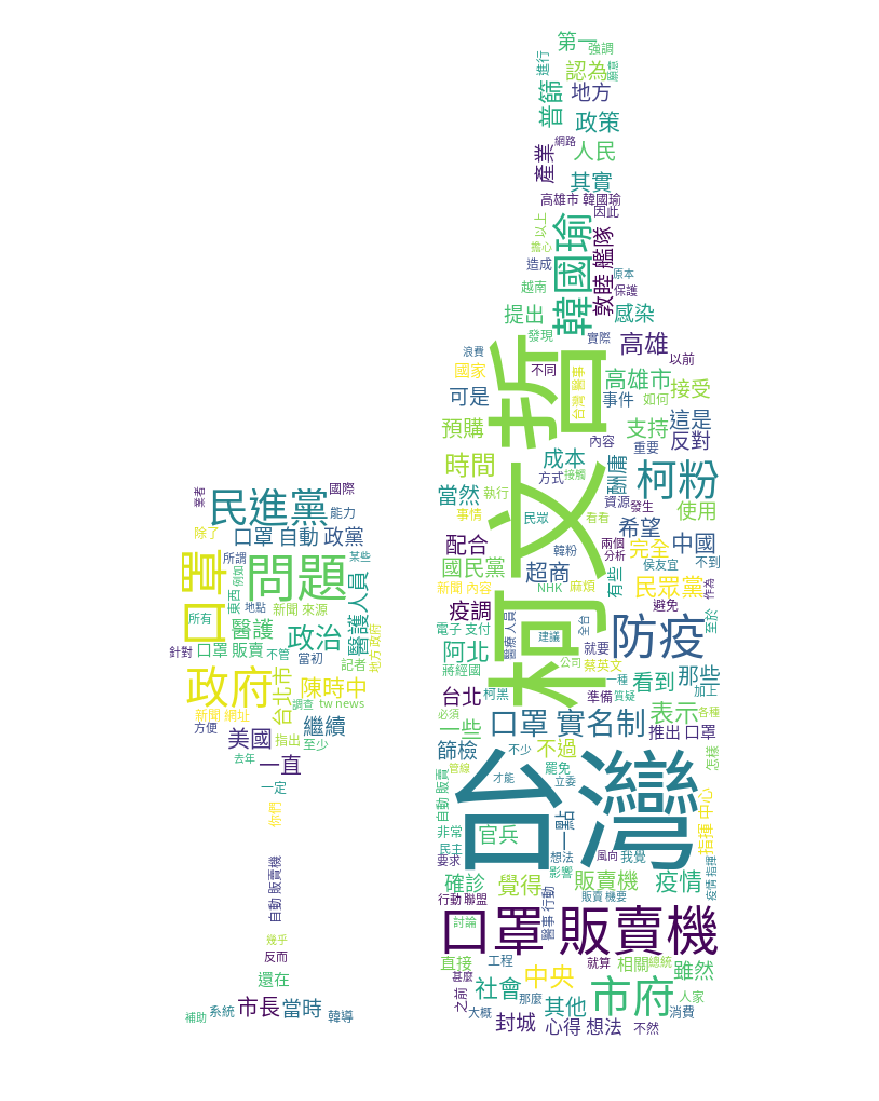

In [498]:
# 產生文字雲
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import pandas as pd

# 整理所有的關鍵字來做文字雲
all_word_join = " ".join(all_words)
all_word_join

wordcloudFile = article_jsonFile_name + 'Cloud.png'
#文字雲造型圖片
mask = np.array(Image.open('1587394929424.png')) #文字雲形狀
# 從 Google 下載的中文字型

font = './Noto_Sans_TC/NotoSansTC-Regular.otf'
#背景顏色預設黑色，改為白色、使用指定圖形、使用指定字體
my_wordcloud = WordCloud(background_color='white',mask=mask, font_path=font).generate(all_word_join)
plt.figure(figsize=(20,20))
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()
my_wordcloud.to_file(wordcloudFile)

<Figure size 432x288 with 0 Axes>

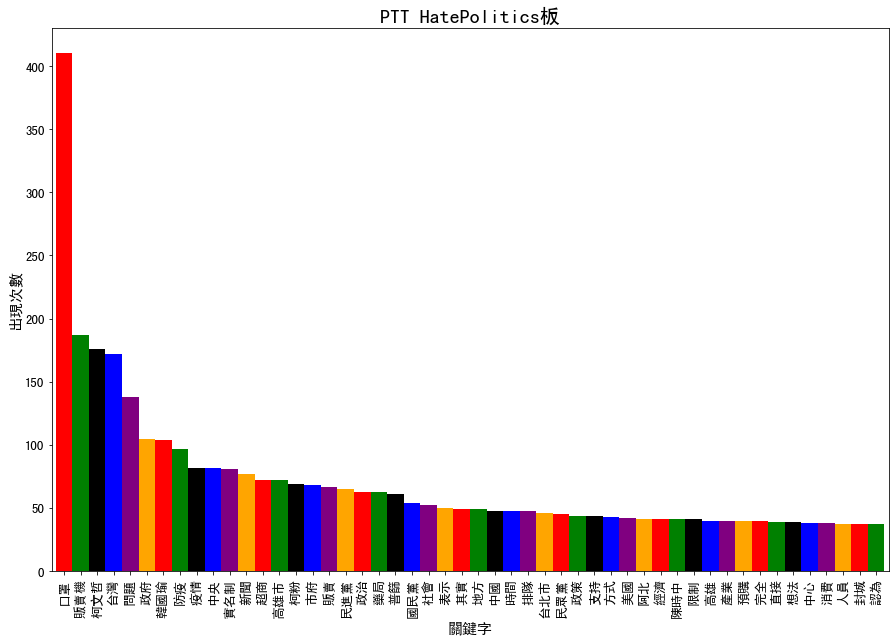

In [499]:
# 將前50關鍵字與出現次數做排名
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd

wordFreq_file = article_jsonFile_name + 'Bar.png' # 存圖檔名
df = pd.DataFrame(words_frequency)
df.columns = ['關鍵字','出現次數']
word_times_df = df[:50].groupby("關鍵字") # 前50組關鍵字


fig = plt.figure()
plt.figure(figsize=(15,10))
word_times_df.max().sort_values(by="出現次數",ascending=False)["出現次數"].plot.bar(color=['red', 'green', 'black', 'blue', 'purple', 'orange'], 
                                                                                 width = 1)
# plt.bar(['你好', '我'], height=[1, 2])
plt.title("PTT "  +article_jsonFile_name + "板", size=20)
plt.xticks()
plt.xticks(fontsize=13, rotation=90)
plt.yticks(fontsize=13)
plt.xlabel("關鍵字",  size=15)
plt.ylabel("出現次數", size=15)
plt.grid(False) 
# plt.show()
plt.savefig(wordFreq_file) # 存檔

In [ ]:
# 將關鍵字與出現次數做排名(ｃｏｄｅ截自網路上網友)
from matplotlib.font_manager import FontProperties
import seaborn as sns
fig = plt.figure()
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
myfont=FontProperties(fname="/Users/karenwang/Desktop/Program/Python/SpiderCourse/PythonHW/ProjectData/Noto_Sans_TC/NotoSansTC-Thin.otf",size=14)
sns.set(font=myfont.get_family())
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
# cities_counter = [('好棒', 285), ('給我', 225), ('不要', 163), ('細柔', 136), ('吃飯', 130), ('小小', 124), ('深圳', 88), ('温州', 67), ('小知', 66), ('大之', 45)]
cities_counter = words_frequency[:50]
sns.set_color_codes("pastel")
plt.title("Ptt Stock板",  size=15)
plt.xlabel("關鍵字",  size=15)
plt.ylabel("出現次數", size=15)
sns.barplot(x=[k for k, _ in cities_counter], y=[v for _, v in cities_counter])
plt.grid(False) 

# 進階挑戰
1. 透過不同帳號，但是相同 IP 且政治用語的詞頻分佈類似的定位成網軍  
2. 進一步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性  
3. 如果不同帳號但是政治用語的詞頻分佈類似，進一步判斷這些高頻率的單字是positive / negative 來歸納兩個帳號之間是否具有相同政治立場

In [500]:
import pandas as pd
dataPd = pd.DataFrame(data)
dataPd

url          article_id  \
0    https://www.ptt.cc/bbs/HatePolitics/M.15877100...  M.1587710085.A.F2E   
1    https://www.ptt.cc/bbs/HatePolitics/M.15877089...  M.1587708908.A.F5A   
2    https://www.ptt.cc/bbs/HatePolitics/M.15877086...  M.1587708666.A.749   
3    https://www.ptt.cc/bbs/HatePolitics/M.15877089...  M.1587708976.A.63D   
4    https://www.ptt.cc/bbs/HatePolitics/M.15877085...  M.1587708509.A.9A9   
..                                                 ...                 ...   
198  https://www.ptt.cc/bbs/HatePolitics/M.15876597...  M.1587659749.A.CCC   
199  https://www.ptt.cc/bbs/HatePolitics/M.15876574...  M.1587657409.A.BEB   
200  https://www.ptt.cc/bbs/HatePolitics/M.15876581...  M.1587658111.A.BF5   
201  https://www.ptt.cc/bbs/HatePolitics/M.15876585...  M.1587658502.A.E6A   
202  https://www.ptt.cc/bbs/HatePolitics/M.15876615...  M.1587661583.A.24D   

            article_author                 article_title  \
0             caelum (楊威利)     Re: [討論] 韓國瑜跟 侯友宜的差別到底在哪啊   
1    nbarepeat (nbarepeat)                [黑特] 台灣人是不是覺醒了   
2      ReiFan (說好的秒速5公分呢?)    [新聞] 磐石艦再增1例 全艦累計30人確診新冠肺炎   
3      hong888 (自自冉冉 崩崩潰潰)  Re: [新聞] 逾2千醫事人員連署反普篩 高市衛生局：   
4      belleyyc (belleyyc)            Re: [討論] 酷邦卷的問題在哪？   
..                     ...                           ...   
198        Rise68 (Rise68)            [討論] 口罩機事件看出柯團隊的悲劇   
199        kisc91389 (順時鐘)       [討論] 柯文哲以前當醫生也沒什麼特殊表現吧？   
200       sunyeah (   湯元嗎)            [討論] 為什麼廠商不想玩所以流標？   
201    belleyyc (belleyyc)                [討論] 酷邦卷的問題在哪？   
202          riomusi (ads)         [轉錄] 從系統分析思考看柯販賣機為何失敗   

                 article_date  \
0    Fri Apr 24 14:34:43 2020   
1    Fri Apr 24 14:15:06 2020   
2    Fri Apr 24 14:11:04 2020   
3    Fri Apr 24 14:16:14 2020   
4    Fri Apr 24 14:08:27 2020   
..                        ...   
198  Fri Apr 24 00:35:45 2020   
199  Thu Apr 23 23:56:47 2020   
200  Fri Apr 24 00:08:29 2020   
201  Fri Apr 24 00:15:00 2020   
202  Fri Apr 24 01:06:21 2020   

                                       article_content              ip  \
0    認真的回你。侯友宜是美國爸爸的人，\n自然有人會幫他帶風向。你看所有霉體\n，就算被共慘黨掌...   36.237.87.186   
1    1年多前\n喜歡講話有趣的韓導\n席捲全台\n漢子只能貼著他取暖\n\n不到1年\n認真打拼...  114.137.45.180   
2    1.新聞網址 https://money.udn.com/money/story/5658/...   210.242.49.73   
3    : （中央社記者程啟峰高雄24日電）高雄市長韓國瑜擬為全市約4000名第一線防疫醫護人員普 ...   219.68.82.150   
4    : 我也有一個我理想的版本 : 1.不限制支付方式 : 消費發票申請必須看財政部的電子發票系...     1.162.50.11   
..                                                 ...             ...   
198  其實還滿好奇口罩販賣機\n這個idea的決策過程\n從發想評估定案\n是怎麼樣形成這個蠢主意...   203.77.53.122   
199  看柯文哲市長當了六年\n真的是一事無成\n都會花很大力氣在宣傳\n但都草草收尾\n\n例如市...     39.12.65.26   
200  因為3.0太強大無誤\n\n北市府會看數字 廠商一樣會看數字\n最後售出數字那規模能看嗎？\...    1.171.36.103   
201  經濟非本人專業 但稍微想一下\n\n與消費卷相比\n\n這酷邦卷的設計理念\n\n才是真正能...    1.162.42.209   
202  FB Sean Wonders https://is.gd/mXNQPO 解一個問題有兩種路...   114.45.82.241   

                                         message_count  \
0    {'all': 0, 'count': 0, 'push': 0, 'boo': 0, 'n...   
1    {'all': 21, 'count': 4, 'push': 5, 'boo': 1, '...   
2    {'all': 17, 'count': 4, 'push': 6, 'boo': 2, '...   
3    {'all': 36, 'count': 1, 'push': 2, 'boo': 1, '...   
4    {'all': 0, 'count': 0, 'push': 0, 'boo': 0, 'n...   
..                                                 ...   
198  {'all': 202, 'count': 49, 'push': 57, 'boo': 8...   
199  {'all': 121, 'count': 1, 'push': 22, 'boo': 21...   
200  {'all': 406, 'count': 59, 'push': 65, 'boo': 6...   
201  {'all': 12, 'count': 2, 'push': 2, 'boo': 0, '...   
202  {'all': 451, 'count': 113, 'push': 123, 'boo':...   

                                              messages  
0                                                   []  
1    [{'push_tag': '→', 'push_userid': 'dakkk', 'pu...  
2    [{'push_tag': '推', 'push_userid': 'nbarepeat',...  
3    [{'push_tag': '→', 'push_userid': 'tinmar', 'p...  
4                                                   []  
..                                                 ...  
198  [{'pus

In [315]:
# IP term 只剩IP
IPmodifyPd = dataPd
for ms_idx in range(len(IPmodifyPd.messages)):
    
    if IPmodifyPd.messages[ms_idx] == []:
        continue
    else:
        for idx in range(len(IPmodifyPd.messages[ms_idx])):
            IPmodifyPd.messages[ms_idx][idx]['push_ipdatetime'] = IPmodifyPd.messages[ms_idx][idx]['push_ipdatetime'].split(' ')[0]
IPmodifyPd

url          article_id  \
0    https://www.ptt.cc/bbs/HatePolitics/M.15877100...  M.1587710085.A.F2E   
1    https://www.ptt.cc/bbs/HatePolitics/M.15877089...  M.1587708908.A.F5A   
2    https://www.ptt.cc/bbs/HatePolitics/M.15877086...  M.1587708666.A.749   
3    https://www.ptt.cc/bbs/HatePolitics/M.15877089...  M.1587708976.A.63D   
4    https://www.ptt.cc/bbs/HatePolitics/M.15877085...  M.1587708509.A.9A9   
..                                                 ...                 ...   
198  https://www.ptt.cc/bbs/HatePolitics/M.15876597...  M.1587659749.A.CCC   
199  https://www.ptt.cc/bbs/HatePolitics/M.15876574...  M.1587657409.A.BEB   
200  https://www.ptt.cc/bbs/HatePolitics/M.15876581...  M.1587658111.A.BF5   
201  https://www.ptt.cc/bbs/HatePolitics/M.15876585...  M.1587658502.A.E6A   
202  https://www.ptt.cc/bbs/HatePolitics/M.15876615...  M.1587661583.A.24D   

            article_author                 article_title  \
0             caelum (楊威利)     Re: [討論] 韓國瑜跟 侯友宜的差別到底在哪啊   
1    nbarepeat (nbarepeat)                [黑特] 台灣人是不是覺醒了   
2      ReiFan (說好的秒速5公分呢?)    [新聞] 磐石艦再增1例 全艦累計30人確診新冠肺炎   
3      hong888 (自自冉冉 崩崩潰潰)  Re: [新聞] 逾2千醫事人員連署反普篩 高市衛生局：   
4      belleyyc (belleyyc)            Re: [討論] 酷邦卷的問題在哪？   
..                     ...                           ...   
198        Rise68 (Rise68)            [討論] 口罩機事件看出柯團隊的悲劇   
199        kisc91389 (順時鐘)       [討論] 柯文哲以前當醫生也沒什麼特殊表現吧？   
200       sunyeah (   湯元嗎)            [討論] 為什麼廠商不想玩所以流標？   
201    belleyyc (belleyyc)                [討論] 酷邦卷的問題在哪？   
202          riomusi (ads)         [轉錄] 從系統分析思考看柯販賣機為何失敗   

                 article_date  \
0    Fri Apr 24 14:34:43 2020   
1    Fri Apr 24 14:15:06 2020   
2    Fri Apr 24 14:11:04 2020   
3    Fri Apr 24 14:16:14 2020   
4    Fri Apr 24 14:08:27 2020   
..                        ...   
198  Fri Apr 24 00:35:45 2020   
199  Thu Apr 23 23:56:47 2020   
200  Fri Apr 24 00:08:29 2020   
201  Fri Apr 24 00:15:00 2020   
202  Fri Apr 24 01:06:21 2020   

                                       article_content              ip  \
0    認真的回你。侯友宜是美國爸爸的人，\n自然有人會幫他帶風向。你看所有霉體\n，就算被共慘黨掌...   36.237.87.186   
1    1年多前\n喜歡講話有趣的韓導\n席捲全台\n漢子只能貼著他取暖\n\n不到1年\n認真打拼...  114.137.45.180   
2    1.新聞網址 https://money.udn.com/money/story/5658/...   210.242.49.73   
3    : （中央社記者程啟峰高雄24日電）高雄市長韓國瑜擬為全市約4000名第一線防疫醫護人員普 ...   219.68.82.150   
4    : 我也有一個我理想的版本 : 1.不限制支付方式 : 消費發票申請必須看財政部的電子發票系...     1.162.50.11   
..                                                 ...             ...   
198  其實還滿好奇口罩販賣機\n這個idea的決策過程\n從發想評估定案\n是怎麼樣形成這個蠢主意...   203.77.53.122   
199  看柯文哲市長當了六年\n真的是一事無成\n都會花很大力氣在宣傳\n但都草草收尾\n\n例如市...     39.12.65.26   
200  因為3.0太強大無誤\n\n北市府會看數字 廠商一樣會看數字\n最後售出數字那規模能看嗎？\...    1.171.36.103   
201  經濟非本人專業 但稍微想一下\n\n與消費卷相比\n\n這酷邦卷的設計理念\n\n才是真正能...    1.162.42.209   
202  FB Sean Wonders https://is.gd/mXNQPO 解一個問題有兩種路...   114.45.82.241   

                                         message_count  \
0    {'all': 0, 'count': 0, 'push': 0, 'boo': 0, 'n...   
1    {'all': 21, 'count': 4, 'push': 5, 'boo': 1, '...   
2    {'all': 17, 'count': 4, 'push': 6, 'boo': 2, '...   
3    {'all': 36, 'count': 1, 'push': 2, 'boo': 1, '...   
4    {'all': 0, 'count': 0, 'push': 0, 'boo': 0, 'n...   
..                                                 ...   
198  {'all': 202, 'count': 49, 'push': 57, 'boo': 8...   
199  {'all': 121, 'count': 1, 'push': 22, 'boo': 21...   
200  {'all': 406, 'count': 59, 'push': 65, 'boo': 6...   
201  {'all': 12, 'count': 2, 'push': 2, 'boo': 0, '...   
202  {'all': 451, 'count': 113, 'push': 123, 'boo':...   

                                              messages  
0                                                   []  
1    [{'push_tag': '→', 'push_userid': 'dakkk', 'pu...  
2    [{'push_tag': '推', 'push_userid': 'nbarepeat',...  
3    [{'push_tag': '→', 'push_userid': 'tinmar', 'p...  
4                                                   []  
..                                                 ...  
198  [{'pus

# 推文分析

In [338]:
# 把每個推文整合一張DataFrame
int_cut = 0
pd_push = pd.DataFrame({})
for push in IPmodifyPd.messages:

    pd_push = pd.concat([pd_push ,pd.DataFrame(push)])
        
pd_push.index = range(len(pd_push))
pd_push

push_tag push_userid          push_content push_ipdatetime
0           →       dakkk             自從他要烙跑就醒了   223.137.165.6
1           →        nnkj      民意如水 唱邱一時爽 全黨火葬場   1.171.160.219
2           推     hong888   漢子也別得意，目前只是菸粉在捧殺，捧你   219.68.82.150
3           →     hong888  來酸柯酸韓，當你下一次和DPP競選連任時   219.68.82.150
4           →     hong888      你看DPP又要動用網軍怎麼修理你   219.68.82.150
...       ...         ...                   ...             ...
7330        推     ted0217                   好文推   172.58.39.134
7331        推  silver5566   既有通路肯定比從0到有快很多! 販賣機   111.255.84.10
7332        →  silver5566     以後可能開創其他商業用途，但拿來跟   111.255.84.10
7333        →  silver5566           既有通路比就是笑話而已   111.255.84.10
7334        推     suny921   如果唐鳳選擇另一個陣營 局勢會相反嗎？  101.136.44.193

[7335 rows x 4 columns]

In [340]:
pd_push[pd_push.push_ipdatetime == '1.171.160.219']

push_tag push_userid                 push_content push_ipdatetime
1           →        nnkj             民意如水 唱邱一時爽 全黨火葬場   1.171.160.219
118         →        nnkj        柯最大的錯誤是認為抗中是負面名詞 罵蔡抗中   1.171.160.219
120         →        nnkj             認為抗中是正面名詞的選民就跑掉了   1.171.160.219
155         →        nnkj          韓國瑜一人毀了朱郭吳柯 可說是功在綠營   1.171.160.219
213         →        nnkj                      唐鳳就是高效率   1.171.160.219
339         →        nnkj        看好中國 看好習近平是最大錯誤 中天看太多   1.171.160.219
355         →        nnkj  China Airline沒有矮化問題 吵改名都柯韓粉   1.171.160.219
368         →        nnkj  China Airline沒有矮化問題 吵改名都柯昌粉   1.171.160.219
381         →        nnkj         綠色選民棄姚保柯 是柯文哲連任市長的主因   1.171.160.219
400         →        nnkj         市長投柯 市議員投dpp 這應該算綠的吧   1.171.160.219
401         →        nnkj         我知道了 綠衛兵是認為市長投姚 才算綠的   1.171.160.219
402         →        nnkj         市長投柯 市議員投時力 這絕對是背骨統派   1.171.160.219
667         →        nnkj              你自己都寫 1. 沒按圖施作.   1.171.160.219
668         →        nnkj       又寫 吳敦義的鍋比較小. 因為他施工的沒問題   1.171.160.219
1341        →        nnkj                   政黑傳統就是輪流囂張   1.171.160.219
2280        →        nnkj        年輕人終會發現dpp只是 綠色的中華民國派   1.171.160.219
2324        →        nnkj                還有人相信他支持正名制憲嗎   1.171.160.219
5619        →        nnkj                          發大財   1.171.160.219
5704        →        nnkj          很有基層實力的像王世堅 王浩宇 王定宇   1.171.160.219
5706        →        nnkj         他們參與政治前也是素人 他們可不是政二代   1.171.160.219

In [341]:
# 所有推文不重複Ip
push_ip_list=[]
for ip in pd_push.push_ipdatetime:
#     print(ip)
    if ip not in push_ip_list:
        push_ip_list.append(ip)
push_ip_list

['223.137.165.6',
 '1.171.160.219',
 '219.68.82.150',
 '101.14.148.39',
 '36.233.58.163',
 '101.12.58.175',
 '1.173.30.53',
 '1.173.163.166',
 '114.43.134.86',
 '223.137.77.134',
 '114.137.45.180',
 '111.83.49.18',
 '36.239.165.185',
 '210.242.49.73',
 '140.115.41.181',
 '218.173.150.166',
 '42.75.10.16',
 '117.19.146.115',
 '61.230.195.66',
 '42.77.182.137',
 '36.237.76.48',
 '110.26.10.252',
 '180.217.140.235',
 '110.54.131.138',
 '220.133.103.168',
 '1.169.74.2',
 '110.28.130.189',
 '223.141.117.130',
 '117.56.236.103',
 '223.140.235.254',
 '42.72.52.95',
 '118.170.190.186',
 '175.180.64.221',
 '49.216.163.54',
 '36.231.61.238',
 '140.109.103.227',
 '218.166.145.26',
 '59.120.151.224',
 '118.160.92.180',
 '27.246.136.249',
 '36.228.135.235',
 '59.124.93.142',
 '117.56.61.24',
 '123.192.113.200',
 '198.244.110.44',
 '42.74.255.94',
 '220.134.155.56',
 '39.8.158.49',
 '114.136.195.167',
 '49.216.213.156',
 '180.217.104.39',
 '61.227.238.113',
 '140.112.104.91',
 '91.207.174.148',
 '22

In [501]:
len(push_ip_list)

981

In [401]:
# 找出同ＩＰ不同帳號index的ＩＰ
diff_account_ip_list = []
# pd_push[pd_push.push_ipdatetime == push_ip_list[0]].push_userid
for ip in push_ip_list:
#     print(ip)
    if (ip == '') | (ip == '07/02'):
        continue
    else:
        accountlist = list(pd_push[pd_push.push_ipdatetime == ip].push_userid)
        if accountlist.count(accountlist[0]) != len(accountlist):
            diff_account_ip_list.append(ip)
    
print('diff_account_ip_list= ',   diff_account_ip_list)

diff_account_ip_list=  ['210.69.13.1', '49.216.43.90', '36.238.204.68']


account_list =  ['chyou2003', 'spector66']
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


<Figure size 432x288 with 0 Axes>

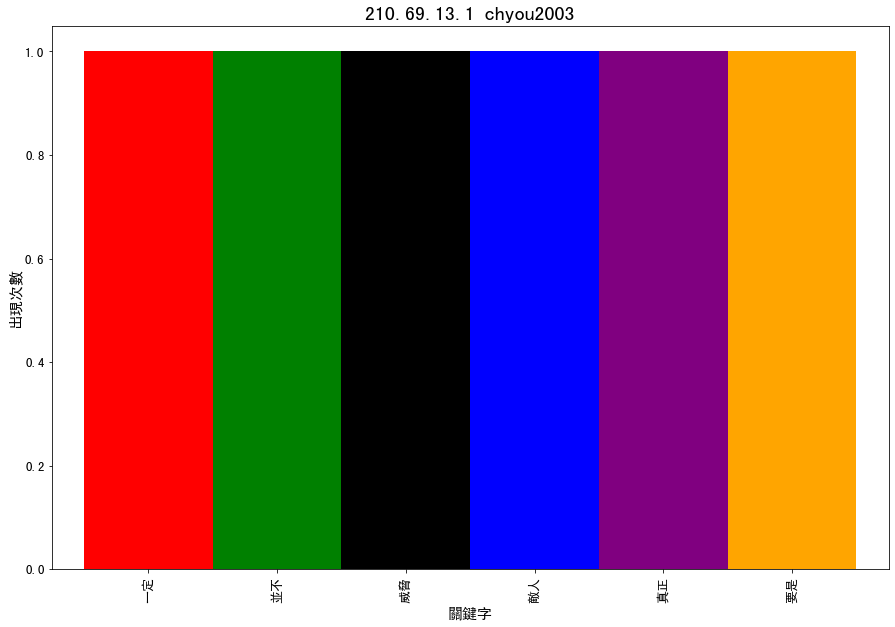

<Figure size 432x288 with 0 Axes>

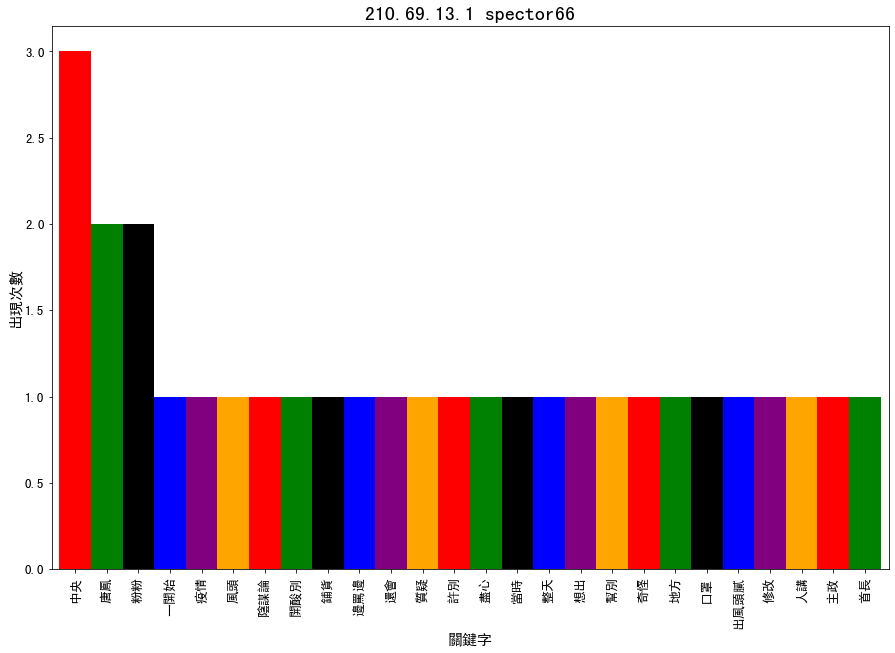

In [505]:
#分三組各別比較
#
# 找出account: diff_account_ip_list[0]
ip_check = diff_account_ip_list[0]
diffaccount_list = pd_push[pd_push.push_ipdatetime == ip_check]
account_list = []
for account in diffaccount_list.push_userid:
    if account not in account_list:
        account_list.append(account)
print('account_list = ', account_list)

#找出推文內容做帳號分組
# pd_push[pd_push.push_ipdatetime == '210.69.13.1']
group01 = {}
push_context = ''
for check_account in account_list:
    push_context = ''
    push_context = list(pd_push[(pd_push.push_ipdatetime == ip_check) & (pd_push.push_userid == check_account)].push_content)

    push_context = ' '.join(push_context)
    group01[check_account] = push_context
group01

first_idx = article_account_list
for account in account_list:
    persional_words_frequency = return_jieba_word(group01[account])[1]
    pltTitle = ip_check + ' ' + account
    plotWordFrequency(persional_words_frequency, pltTitle, False)

account_list =  ['Cosmoswalker', 'GiBai5566']
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


<Figure size 432x288 with 0 Axes>

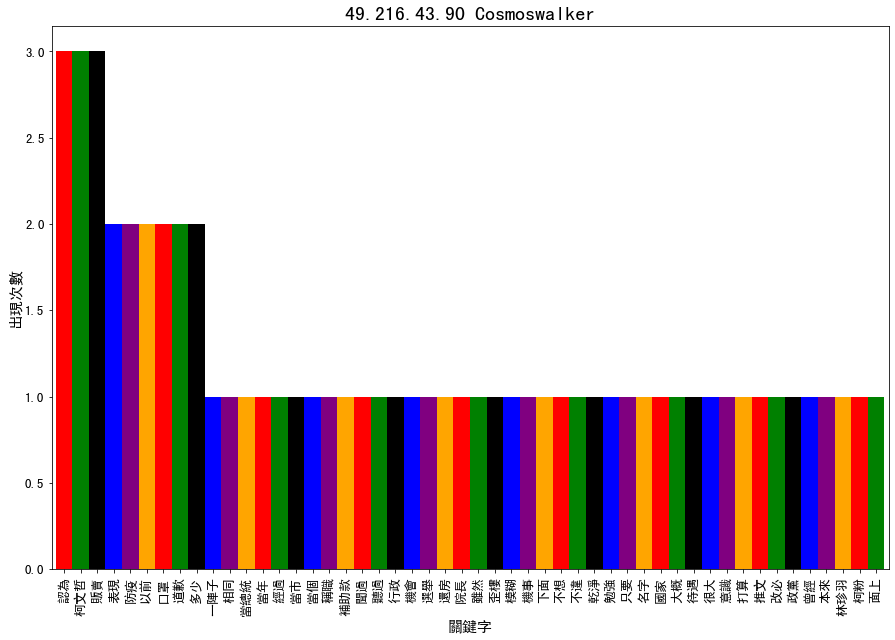

<Figure size 432x288 with 0 Axes>

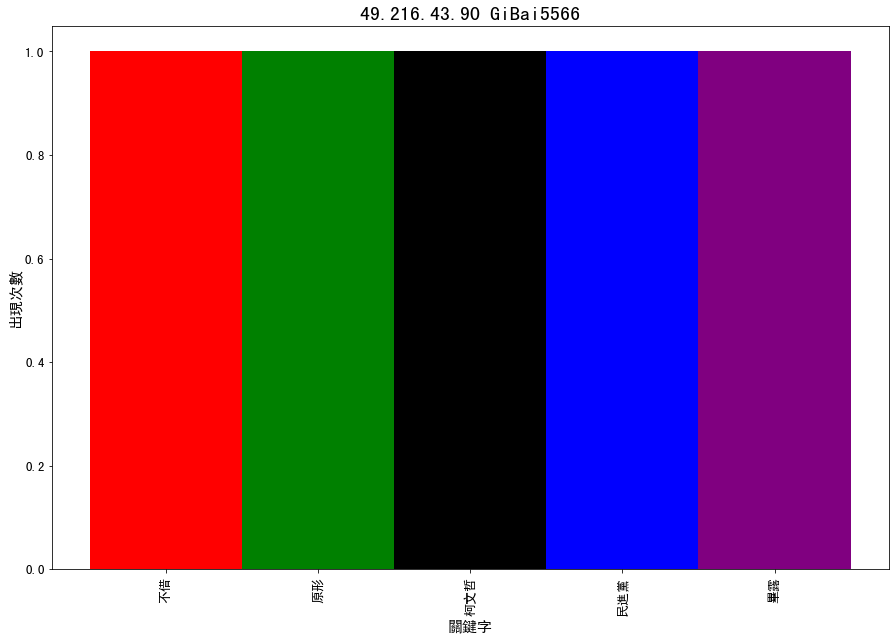

In [507]:
#分三組各別比較
#
# 找出account: diff_account_ip_list[0]
ip_check = diff_account_ip_list[1]
diffaccount_list = pd_push[pd_push.push_ipdatetime == ip_check]
account_list = []
for account in diffaccount_list.push_userid:
    if account not in account_list:
        account_list.append(account)
print('account_list = ', account_list)

#找出推文內容做帳號分組
# pd_push[pd_push.push_ipdatetime == '210.69.13.1']
group01 = {}
push_context = ''
for check_account in account_list:
    push_context = ''
    push_context = list(pd_push[(pd_push.push_ipdatetime == ip_check) & (pd_push.push_userid == check_account)].push_content)

    push_context = ' '.join(push_context)
    group01[check_account] = push_context
group01

first_idx = article_account_list
for account in account_list:
    persional_words_frequency = return_jieba_word(group01[account])[1]
    pltTitle = ip_check + ' ' + account
    plotWordFrequency(persional_words_frequency, pltTitle, False)

account_list =  ['iamdota', 'benqlove']
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


<Figure size 432x288 with 0 Axes>

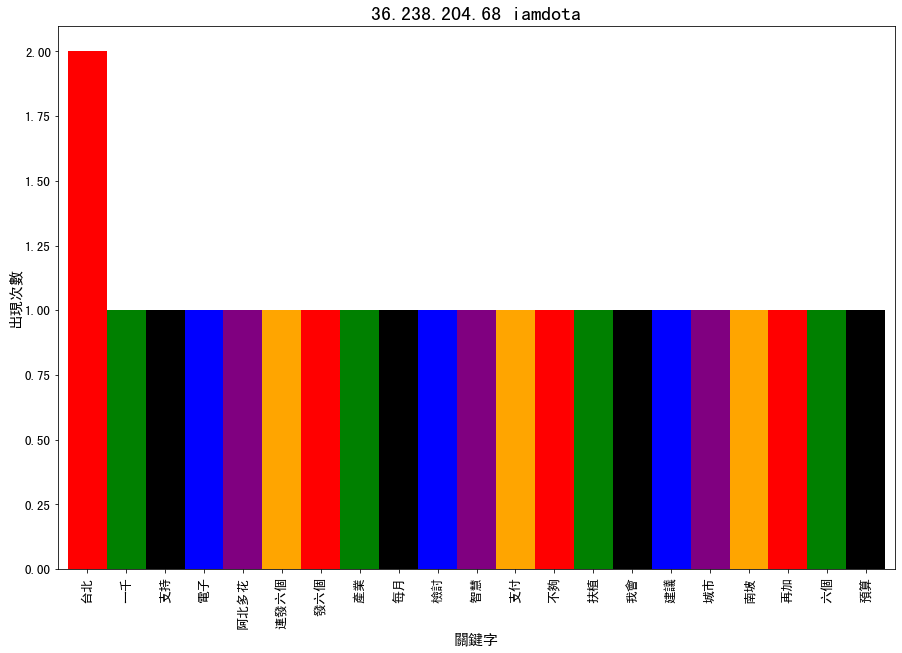

<Figure size 432x288 with 0 Axes>

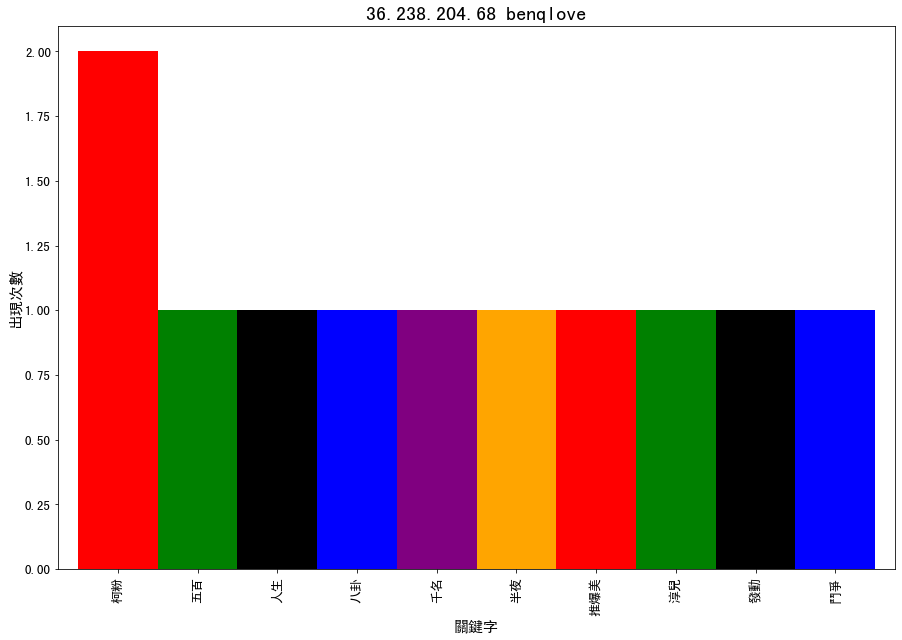

In [506]:
#分三組各別比較
#
# 找出account: diff_account_ip_list[2]
ip_check = diff_account_ip_list[2]
diffaccount_list = pd_push[pd_push.push_ipdatetime == ip_check]
account_list = []
for account in diffaccount_list.push_userid:
    if account not in account_list:
        account_list.append(account)
print('account_list = ', account_list)

#找出推文內容做帳號分組
# pd_push[pd_push.push_ipdatetime == '210.69.13.1']
group01 = {}
push_context = ''
for check_account in account_list:
    push_context = ''
    push_context = list(pd_push[(pd_push.push_ipdatetime == ip_check) & (pd_push.push_userid == check_account)].push_content)

    push_context = ' '.join(push_context)
    group01[check_account] = push_context
group01

first_idx = article_account_list
for account in account_list:
    persional_words_frequency = return_jieba_word(group01[account])[1]
    pltTitle = ip_check + ' ' + account
    plotWordFrequency(persional_words_frequency, pltTitle, False)

In [377]:


#同ＩＰ不同帳號整成一張ＤＦ

# int_cut = 0
# pd_push = pd.DataFrame({})
# for push in IPmodifyPd.messages:

#     pd_push = pd.concat([pd_push ,pd.DataFrame(push)])
        
# pd_push.index = range(len(pd_push))
# pd_push


pd_army_checkList = pd.DataFrame({})
for ip in diff_account_ip_list:
    pd_army_checkList = pd.concat([pd_army_checkList ,pd_push[pd_push.push_ipdatetime == ip]])
pd_army_checkList.index = range(len(pd_army_checkList))

pd_army_checkList


push_tag push_userid         push_content push_ipdatetime
0         推   chyou2003      "敵人"並不一定要是真正的威脅     210.69.13.1
1         →   spector66  奇怪 阿唐鳳也說3.0會再修改成4.0     210.69.13.1
2         →   spector66     唐鳳都說還會改  就不許別人講?     210.69.13.1
3         →   spector66   地方首長到中央主政大家都想為疫情盡心     210.69.13.1
4         →   spector66   力 就粉粉整天在幫別人陰謀論開酸別人     210.69.13.1
..      ...         ...                  ...             ...
58        →     iamdota  六個月後再來檢討，如果不夠再加發六個月   36.238.204.68
59        推     iamdota               台北南坡蛙！   36.238.204.68
60        推    benqlove   發動八卦柯粉鬥爭淳兒五百篇，半夜千名   36.238.204.68
61        →    benqlove             柯粉推爆美z人生   36.238.204.68
62        推     iamdota  台北智慧城市，支持阿北多花預算扶植產業   36.238.204.68

[63 rows x 4 columns]

# 文章分析

In [49]:
# 從所有文章中找出多次發文的ＩＰ
ip_list = []
more_accountIP_index = []
ind = 0
for info in data:
    if info['ip'] not in ip_list:
        ip_list.append(info['ip'])
        if len(dataPd[dataPd.ip == info['ip']]) > 1:
            more_accountIP_index.append(ind)
    ind += 1
more_accountIP_index

[2,
 5,
 7,
 8,
 10,
 14,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 28,
 41,
 44,
 46,
 52,
 55,
 60,
 62,
 63,
 65,
 66,
 67,
 69,
 71,
 73,
 76,
 85,
 92,
 109,
 112,
 113,
 116,
 139,
 166,
 176,
 178]

In [69]:
# 找出, 多次發文ＩＰ or 相同ＩＰ不同帳號
for index in more_accountIP_index:
    print(dataPd[dataPd.ip == dataPd.ip[index]].article_author)
    print('article size: ', len(dataPd[dataPd.ip == dataPd.ip[index]].article_author))
    print('=======')


2     ReiFan (說好的秒速5公分呢?)
32    ReiFan (說好的秒速5公分呢?)
Name: article_author, dtype: object
article size:  2
5      bebehome (bebehome)
126    bebehome (bebehome)
146    bebehome (bebehome)
Name: article_author, dtype: object
article size:  3
7      h0304 (h0304)
35     h0304 (h0304)
161    h0304 (h0304)
164    h0304 (h0304)
Name: article_author, dtype: object
article size:  4
8      acln0816 ()
118    acln0816 ()
Name: article_author, dtype: object
article size:  2
10    zxc445567 (飄飄)
17    zxc445567 (飄飄)
Name: article_author, dtype: object
article size:  2
14     dakkk (我是牛我反芻)
101    dakkk (我是牛我反芻)
154    dakkk (我是牛我反芻)
Name: article_author, dtype: object
article size:  3
15    nogood (nogood)
29    nogood (nogood)
Name: article_author, dtype: object
article size:  2
18    weni302 (鏡花水月號)
54    weni302 (鏡花水月號)
Name: article_author, dtype: object
article size:  2
19    AGODFATHER ()
78    AGODFATHER ()
Name: article_author, dtype: object
article size:  2
20     goetze (異教神)
123    goetz

In [116]:
# 對文章內容作分詞並計算每個詞出現的次數 Ｆunction
import jieba
import jieba.analyse
from collections import Counter
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd


# drop_word_pattern = [
#     '，', 
#     '。', 
#     '\n', 
#     '?', 
#     '/', 
#     '.', 
#     '？', 
#     ' ', 
#     ':', 
#     '=', 
#     '：', 
#     '的', 
#     '(', 
#     ')', 
#     '、', 
#     '在', 
#     '是', 
#     '了',
#     'www',
#     'http',
#     'com',
#     'html',
#     '我們',
#     '還是',
#     '什麼',
#     '不是',
#     '這些',
#     '已經',
#     '目前',
#     '所以',
#     '就是',
#     '因為',
#     '根本',
#     '他們',
#     '可以',
#     '如果',
#     '這種',
#     '知道',
#     '怎麼',
#     '一個',
#     '今天',
#     '這樣',
#     '可能',
#     '沒有',
#     '真的'
#     '是不是',
#     '不能',
#     '各位',
#     '一天',
#     '一下',
#     '現在']


def return_jieba_word(article):
    # jieba.set_dictionary('dict.txt.big.txt')    #詞庫
    jieba.load_userdict('userdict.txt')        #自定義使用者字典
    all_words = []

#     ptt_article = dataPd[dataPd.ip == dataPd.ip[138]]['article_content'][185]
    ptt_article = article
    
    words = jieba.cut(ptt_article, cut_all=False)


    for word in words:
    #     print(word)
#         if word == 'https':
#             break
        if (word in drop_word_pattern) | (is_number(word)) | (len(word) == 1):
    #         if (word in drop_word_pattern):
            continue
        else:
            all_words.append(word)
    
    count = Counter(all_words)
    words_frequency = count.most_common()
    return all_words, words_frequency


# 將前50關鍵字與出現次數做排名

def plotWordFrequency(words_frequency, ploTitleName, wordFreq_file):
#     wordFreq_file = article_jsonFile_name + 'Bar.png' # 存圖檔名
    wordFreq_file = wordFreq_file
    title_name = ploTitleName
#     title_name = dataPd[dataPd.ip == dataPd.ip[138]].ip[138]
    df = pd.DataFrame(words_frequency)
    df.columns = ['關鍵字','出現次數']
    word_times_df = df[:50].groupby("關鍵字") # 前50組關鍵字


    fig = plt.figure()
    plt.figure(figsize=(15,10))
    word_times_df.max().sort_values(by="出現次數",ascending=False)["出現次數"].plot.bar(color=['red', 'green', 'black', 'blue', 'purple', 'orange'], 
                                                                                     width = 1)
    # plt.bar(['你好', '我'], height=[1, 2])
    plt.title(title_name, size=20)
    plt.xticks(fontsize=13, rotation=90)
    plt.yticks(fontsize=13)
    
    plt.xlabel("關鍵字",  size=15)
    plt.ylabel("出現次數", size=15)
    plt.grid(False) 
    # plt.show()
    if not wordFreq_file:
        print('不存檔設定：wordFreq_file= ', wordFreq_file)
    else:
        print('存圖檔！')
        plt.savefig(wordFreq_file) # 存檔

In [464]:
# 找出相同ＩＰ不同帳號文章
article_account_list = []
sameIP_difAccount_term = dataPd[dataPd.ip == dataPd.ip[176]]
print(sameIP_difAccount_term.article_author)
article_list = list(sameIP_difAccount_term.article_content.index)
for account in sameIP_difAccount_term.article_author:
    if account not in article_account_list:
        article_account_list.append(account)
article_account_list



176      kaiblue (用心作戰)
182    xeloss (蟹工船の労働者)
196      kaiblue (用心作戰)
Name: article_author, dtype: object


['kaiblue (用心作戰)', 'xeloss (蟹工船の労働者)']

In [149]:
sameIP_difAccount_term.article_content[182]

': 標題: [新聞] 全文陳道輝認了親下令放人下船休假 : 時間: Fri Apr 24 01:21:23 2020 : : 1.新聞網址 : 超過一行請縮址 : : https://reurl.cc/E71V2A : : 2.新聞來源 : : Yahoo新聞 : : 3.新聞內容 : 請完整轉載原文 請勿修改內文與編排 : : 標題：全文陳道輝認了親下令放人下船休假 : : 2020年4月23日 林奇樺報導 : :     海軍敦睦艦隊磐石艦目前29人確診武漢肺炎，確診者足跡遍佈全台至少10縣市，引發 : 社會熱議。敦睦艦隊支隊長陳道輝少將昨（22）日在接受立委電話質詢時，曾表示有向艦 : 隊指揮部回報有1名官兵發燒，但今日下午，他則透過LINE群組澄清，是支隊有1員扁桃腺 : 發炎，經診治後痊癒，因此並未通報艦指部。 : :     陳道輝今日下午在LINE群組中指出，對於昨日在立法外交及國防委員會時的電話質詢 : ，因為多日失眠加上正於隔離期間，所以答覆內容均憑回憶，無法詳細記得，因此在答詢 : 結束後，發現內容和事實並不相符。 : :     陳道輝澄清，昨日在答詢時稱有向艦指部回報有1人發燒，但經過信文確認後，應是扁 : 桃腺發炎，且也經醫官診治後痊癒，因此，我們並未通報艦指部，有相關紀錄可查詢 : ；至於大家關心的，到底是誰在4月14日下令解除梯口管制？陳道輝表示，昨日誤解了呂玉 : 玲委員的質詢，也坦承是自己在聯檢小組檢查、確認支隊各艦狀況正常無誤後，執行個人 : 權責，親自下令解除梯口管制，實施放假。 : :     最後陳道輝也表示，國防部長嚴德發、海軍司令劉志斌上將以及各級長官都相當關心 : ，也強調後續會配合專案小組調查，絕不迴避責任，也對磐石艦發生疫情深感抱歉，並期 : 待國人能夠諒解、支持國軍，重振對海軍的士氣。 :\n: : 陳道輝全文 : :     各位。午安 : :     昨(22)日支隊長接受立法院外交國防委員會召委以電話方式質詢有關本支隊防疫處 : 置的作為。因我多日失眠且目前於隔離期間，答覆內容均憑回憶，無法詳細記得，答詢 : 後發現可能有些內容與事實有些出入，引發軒然大波，我想在此向各位澄清，避免外界誤 : 解。 : :     一、昨日支隊長說：有向艦指部安全回報有1人發燒，經過信文確認後，應是支隊有乙 :      

In [454]:
dataPd[(dataPd.ip == '111.243.47.63') & (dataPd.article_author == 'kaiblue (用心作戰)')].article_content

176    1.新聞網址 https://reurl.cc/E71V2A 2.新聞來源 Yahoo新聞 ...
196    1.轉錄標題 若為BBS他板文章可免填 FB請寫名稱 重磅快評陳時中拆韓國瑜的台 能成就自己...
Name: article_content, dtype: object

In [436]:
sameIP_difAccount_term.ip

176    111.243.47.63
182    111.243.47.63
196    111.243.47.63
Name: ip, dtype: object

In [465]:
#找出ＰＯ文章內容做帳號分組
# pd_push[pd_push.push_ipdatetime == '210.69.13.1']
ip_check = sameIP_difAccount_term.ip[article_list[0]]
article_group01 = {}
article_context = ''
for check_account in article_account_list:
    article_context = ''
    article_context = list(dataPd[(dataPd.ip == '111.243.47.63') & (dataPd.article_author == check_account)].article_content)

    article_context = ' '.join(article_context)
    article_group01[check_account] = article_context
article_group01

{'kaiblue (用心作戰)': '1.新聞網址 https://reurl.cc/E71V2A 2.新聞來源 Yahoo新聞 3.新聞內容 標題：全文陳道輝認了親下令放人下船休假\n\n2020年4月23日 林奇樺報導\n\n    海軍敦睦艦隊磐石艦目前29人確診武漢肺炎，確診者足跡遍佈全台至少10縣市，引發\n社會熱議。敦睦艦隊支隊長陳道輝少將昨（22）日在接受立委電話質詢時，曾表示有向艦\n隊指揮部回報有1名官兵發燒，但今日下午，他則透過LINE群組澄清，是支隊有1員扁桃腺\n發炎，經診治後痊癒，因此並未通報艦指部。\n\n    陳道輝今日下午在LINE群組中指出，對於昨日在立法外交及國防委員會時的電話質詢\n，因為多日失眠加上正於隔離期間，所以答覆內容均憑回憶，無法詳細記得，因此在答詢\n結束後，發現內容和事實並不相符。\n\n    陳道輝澄清，昨日在答詢時稱有向艦指部回報有1人發燒，但經過信文確認後，應是扁\n桃腺發炎，且也經醫官診治後痊癒，因此，我們並未通報艦指部，有相關紀錄可查詢\n；至於大家關心的，到底是誰在4月14日下令解除梯口管制？陳道輝表示，昨日誤解了呂玉\n玲委員的質詢，也坦承是自己在聯檢小組檢查、確認支隊各艦狀況正常無誤後，執行個人\n權責，親自下令解除梯口管制，實施放假。\n\n    最後陳道輝也表示，國防部長嚴德發、海軍司令劉志斌上將以及各級長官都相當關心\n，也強調後續會配合專案小組調查，絕不迴避責任，也對磐石艦發生疫情深感抱歉，並期\n待國人能夠諒解、支持國軍，重振對海軍的士氣。\n\n\n陳道輝全文\n\n    各位。午安\n\n    昨(22)日支隊長接受立法院外交國防委員會召委以電話方式質詢有關本支隊防疫處\n置的作為。因我多日失眠且目前於隔離期間，答覆內容均憑回憶，無法詳細記得，答詢\n後發現可能有些內容與事實有些出入，引發軒然大波，我想在此向各位澄清，避免外界誤\n解。\n\n    一、昨日支隊長說：有向艦指部安全回報有1人發燒，經過信文確認後，應是支隊有乙\n        員扁桃腺發炎，經醫官診治後痊癒，，支隊人數眾多記憶難免混淆，因此，我們\n        並未通報艦指部，有相關紀錄可查詢。\n\n    二、有關14日是誰下令解除梯口管制，我那時誤解呂玉玲委員的質詢，4月14日上午經\n    

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


<Figure size 432x288 with 0 Axes>

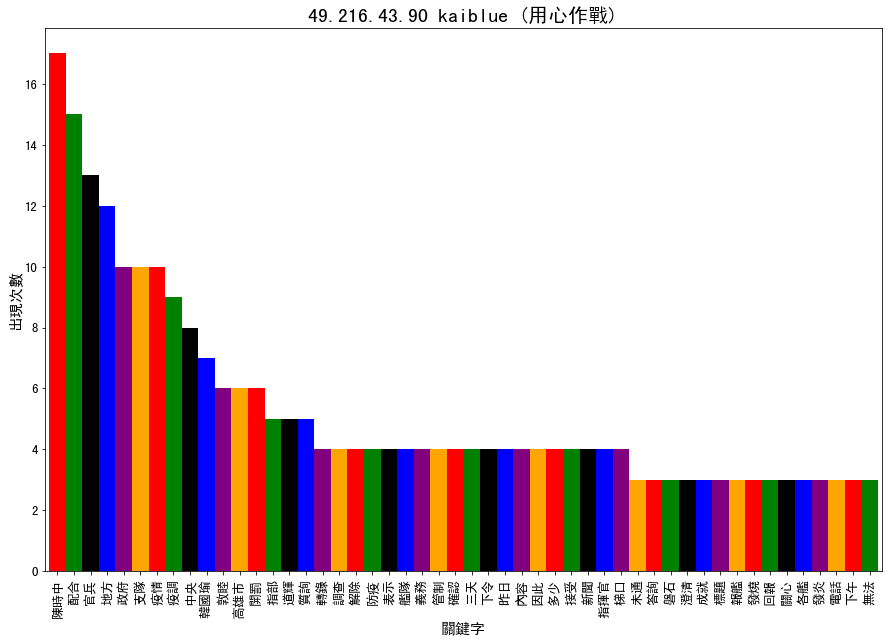

<Figure size 432x288 with 0 Axes>

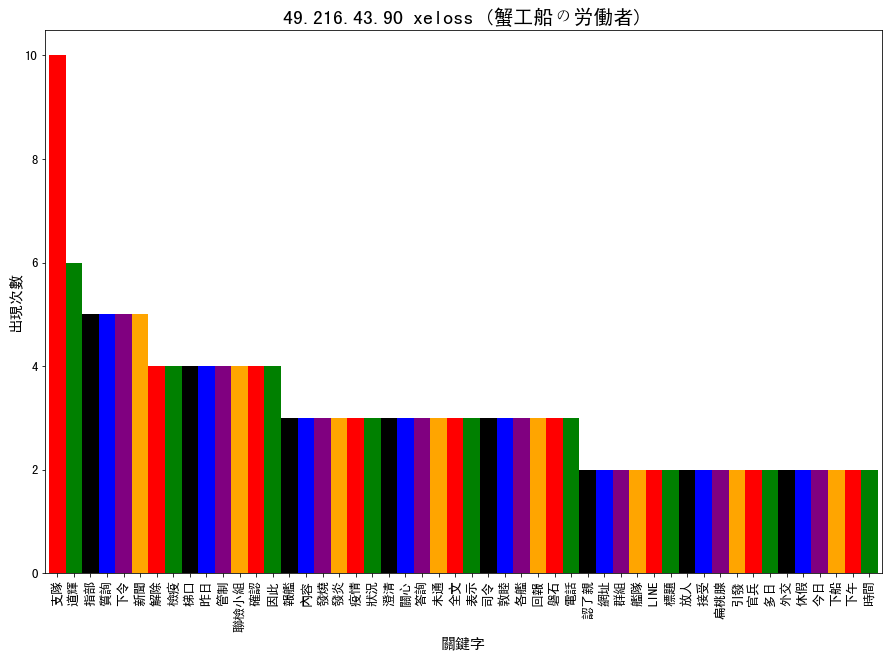

In [508]:
first_idx = article_list[0]
for account in article_account_list:
    persional_words_frequency = return_jieba_word(article_group01[account])[1]
    pltTitle = ip_check + ' ' + account
    plotWordFrequency(persional_words_frequency, pltTitle, False)

# 分析10個不同帳號的政治立場

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False
不存檔設定：wordFreq_file=  False


/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/karenwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

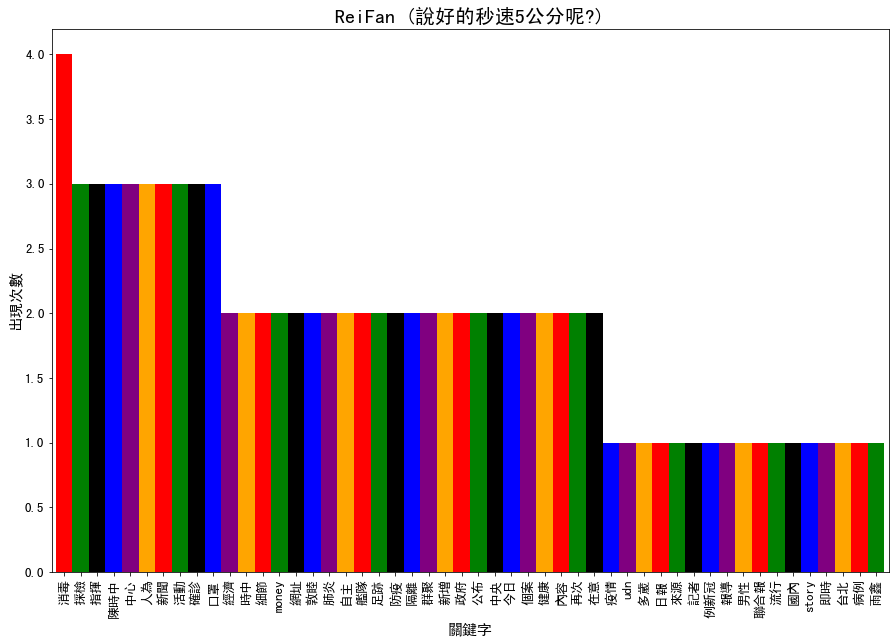

<Figure size 432x288 with 0 Axes>

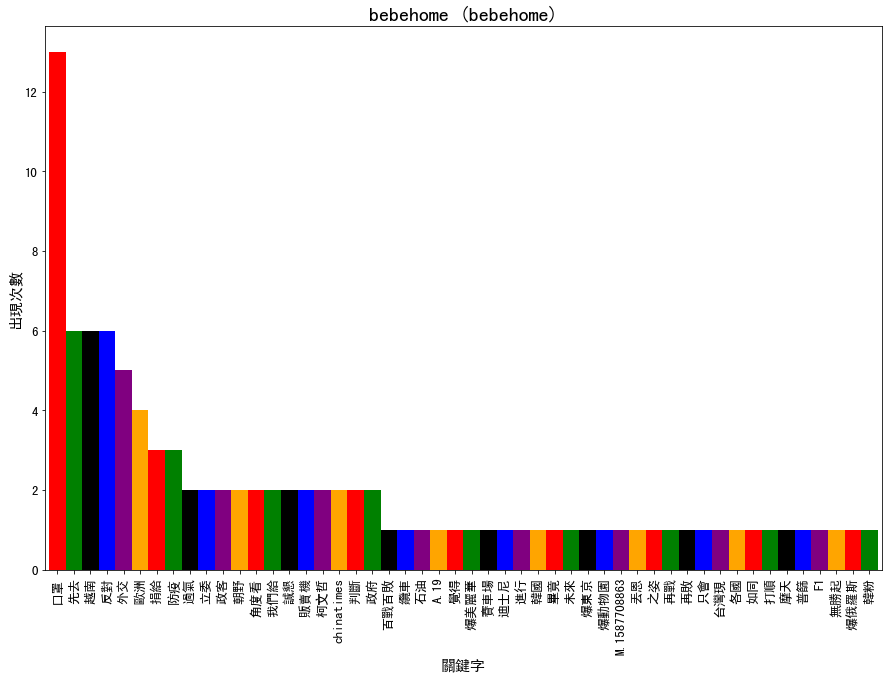

<Figure size 432x288 with 0 Axes>

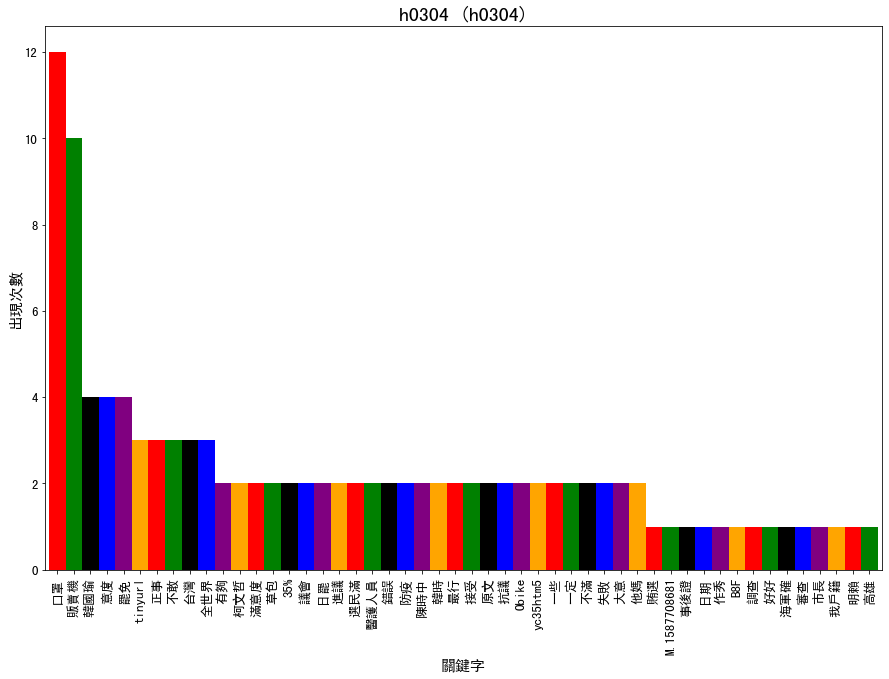

<Figure size 432x288 with 0 Axes>

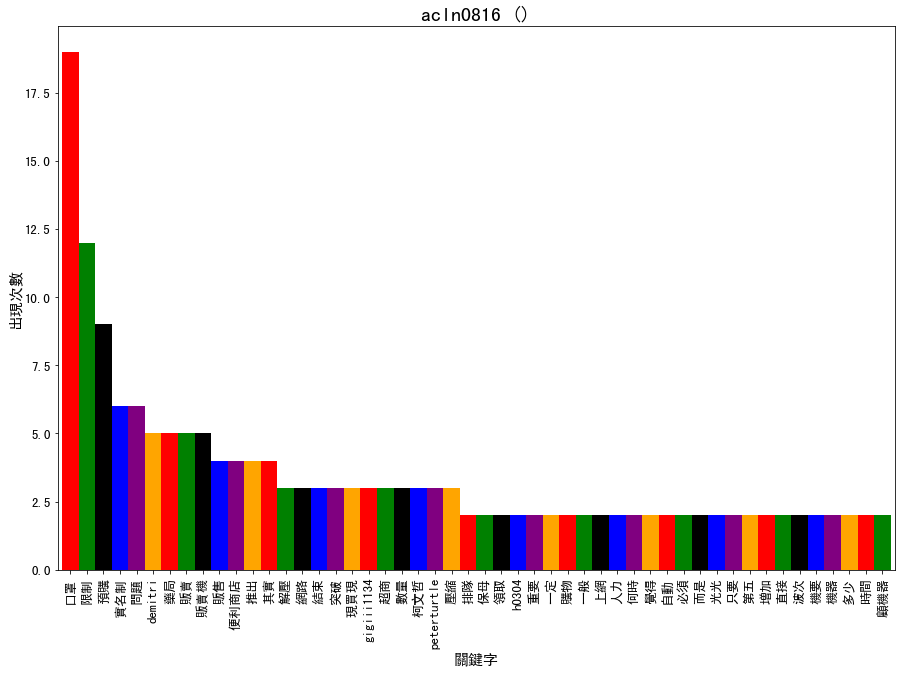

<Figure size 432x288 with 0 Axes>

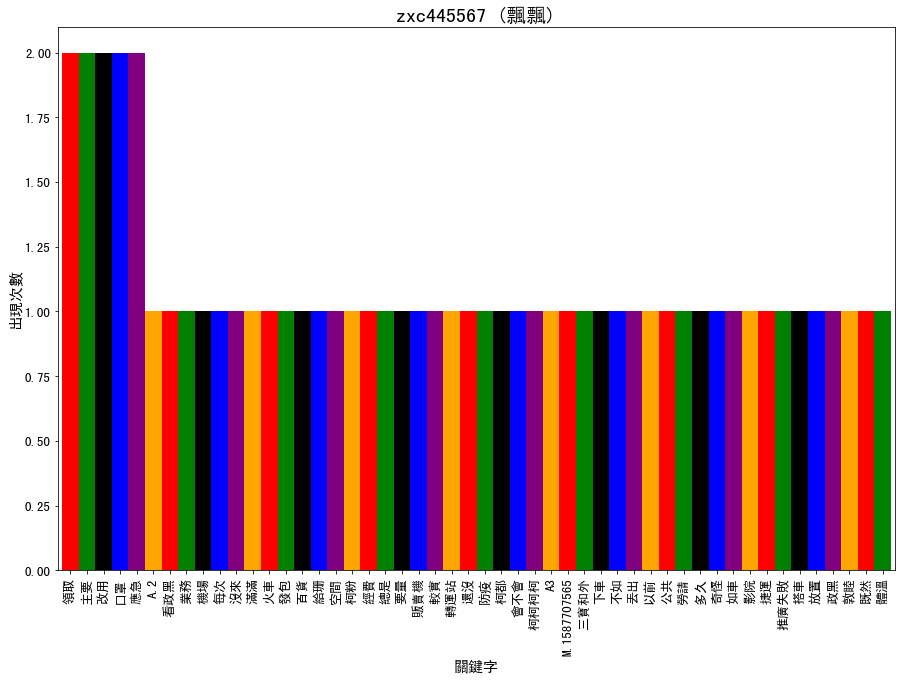

<Figure size 432x288 with 0 Axes>

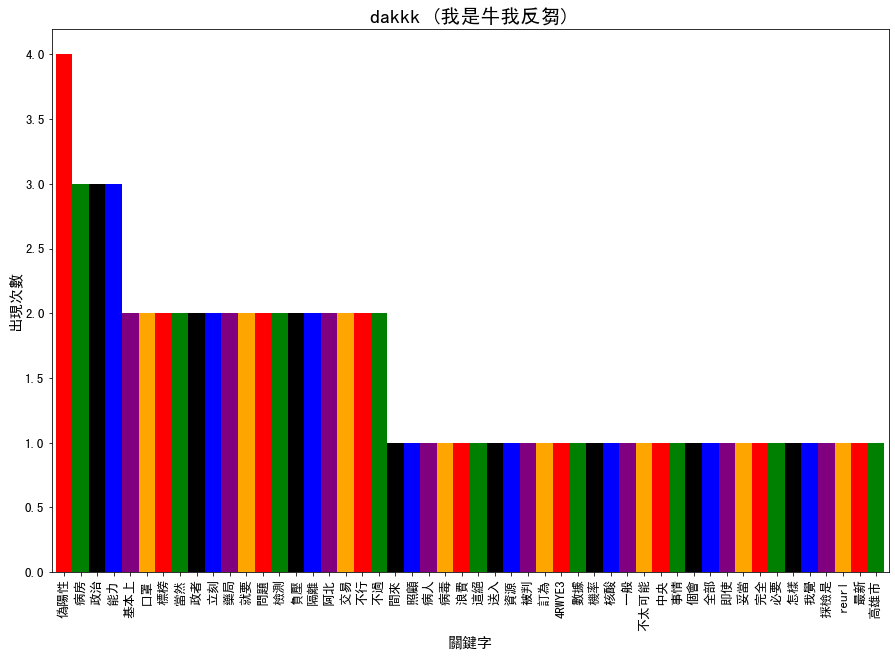

<Figure size 432x288 with 0 Axes>

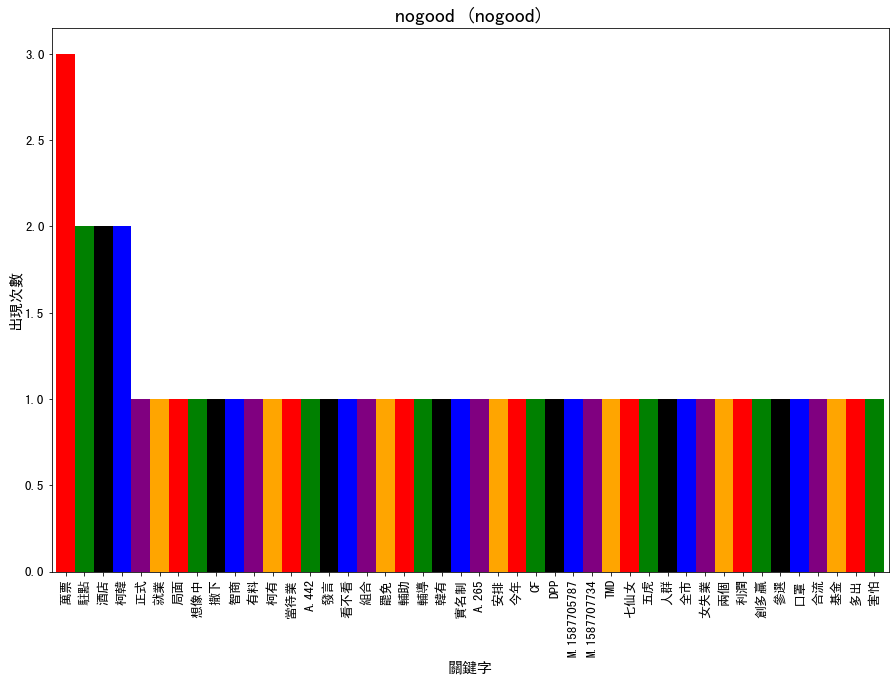

<Figure size 432x288 with 0 Axes>

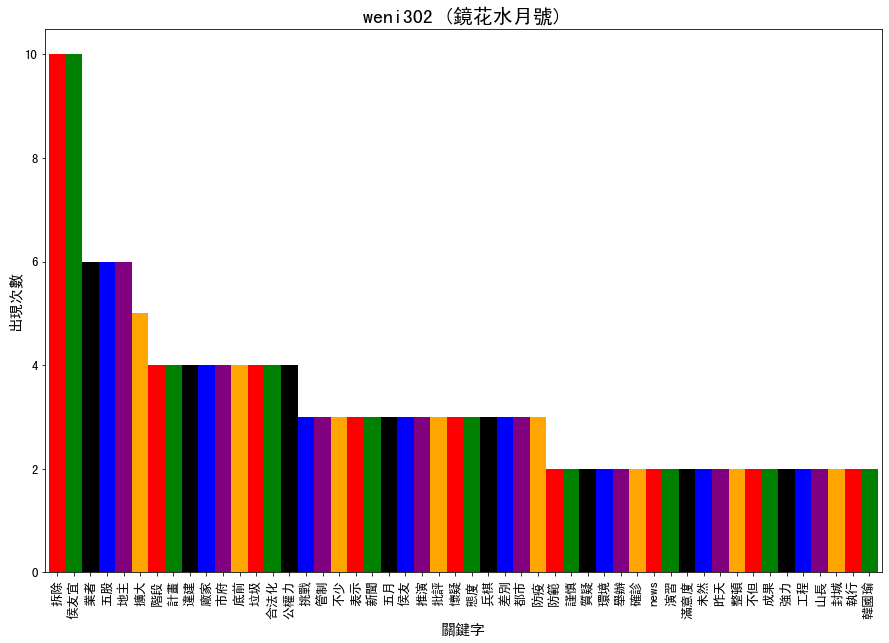

<Figure size 432x288 with 0 Axes>

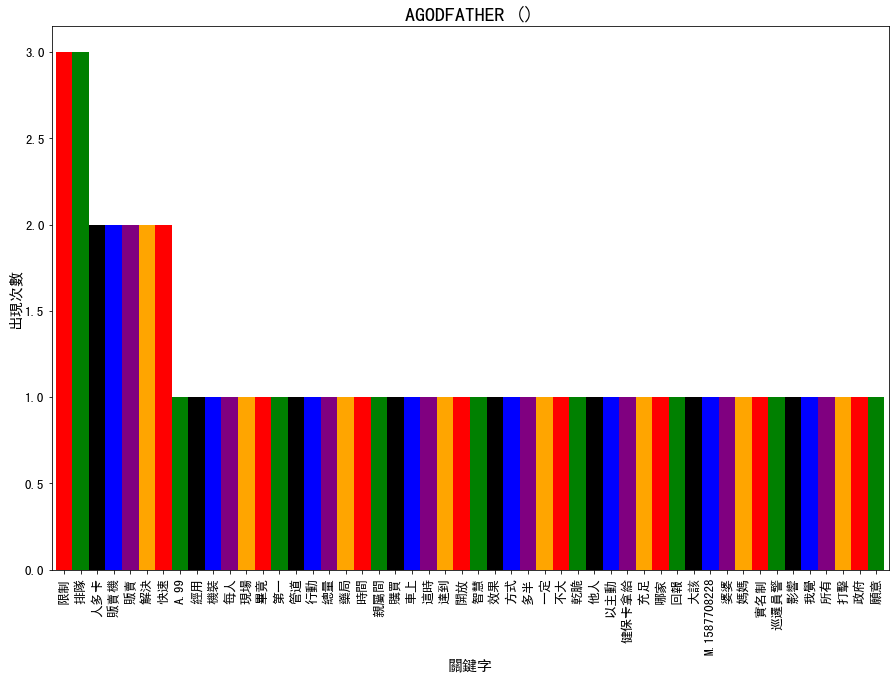

<Figure size 432x288 with 0 Axes>

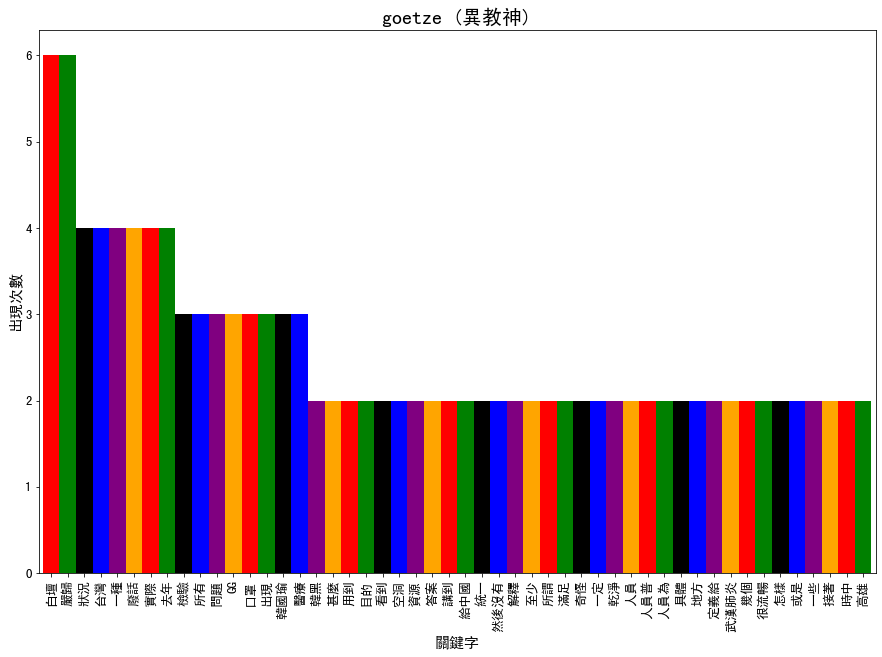

<Figure size 432x288 with 0 Axes>

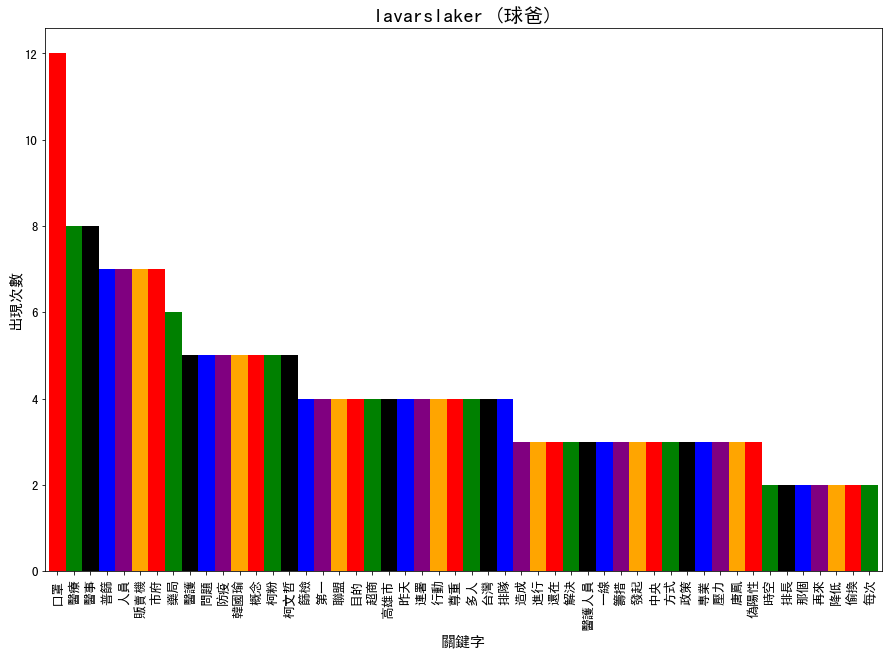

<Figure size 432x288 with 0 Axes>

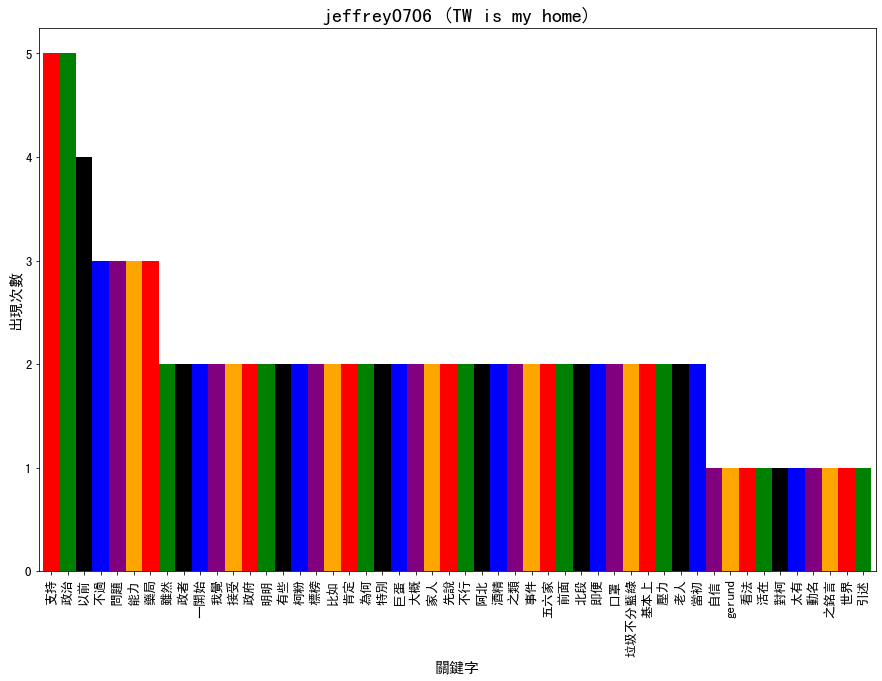

<Figure size 432x288 with 0 Axes>

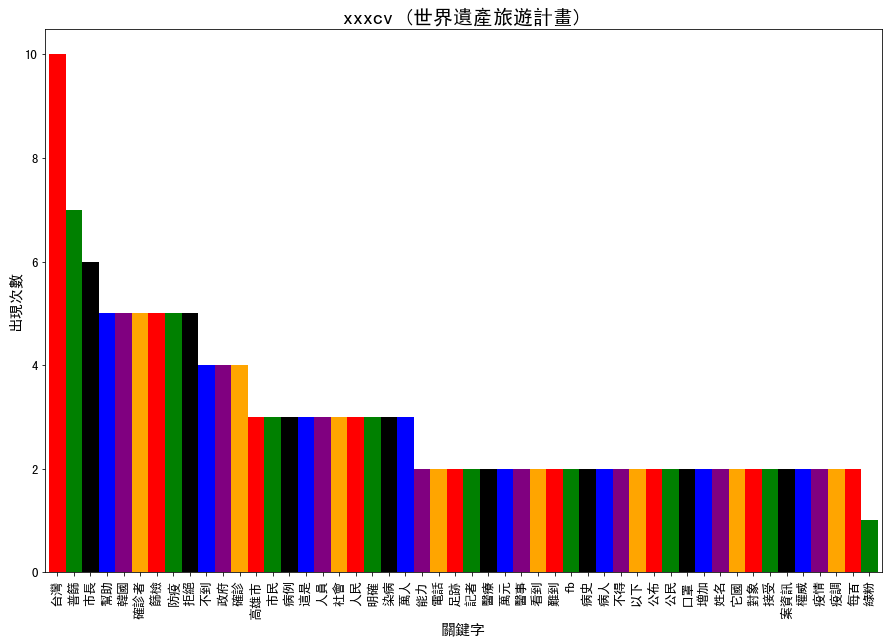

<Figure size 432x288 with 0 Axes>

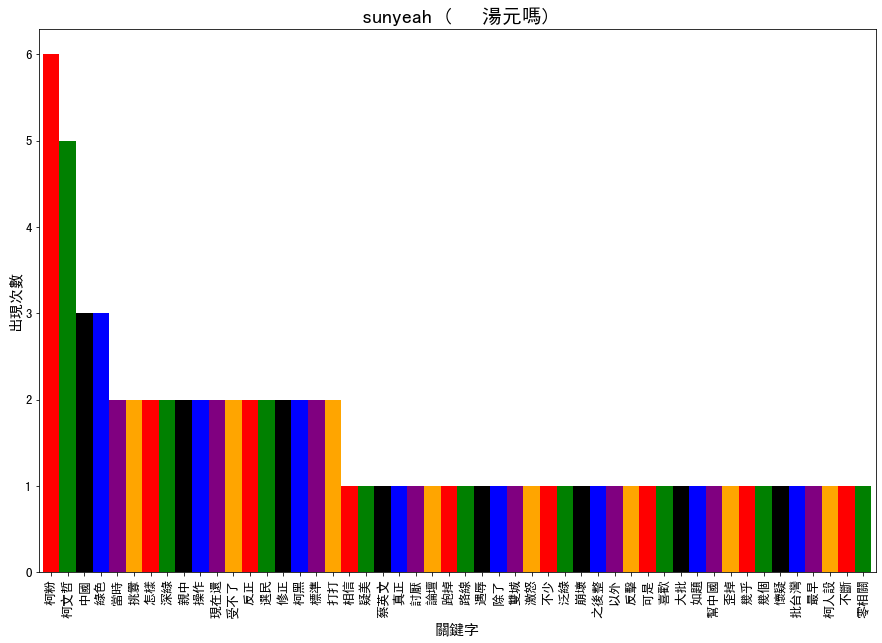

<Figure size 432x288 with 0 Axes>

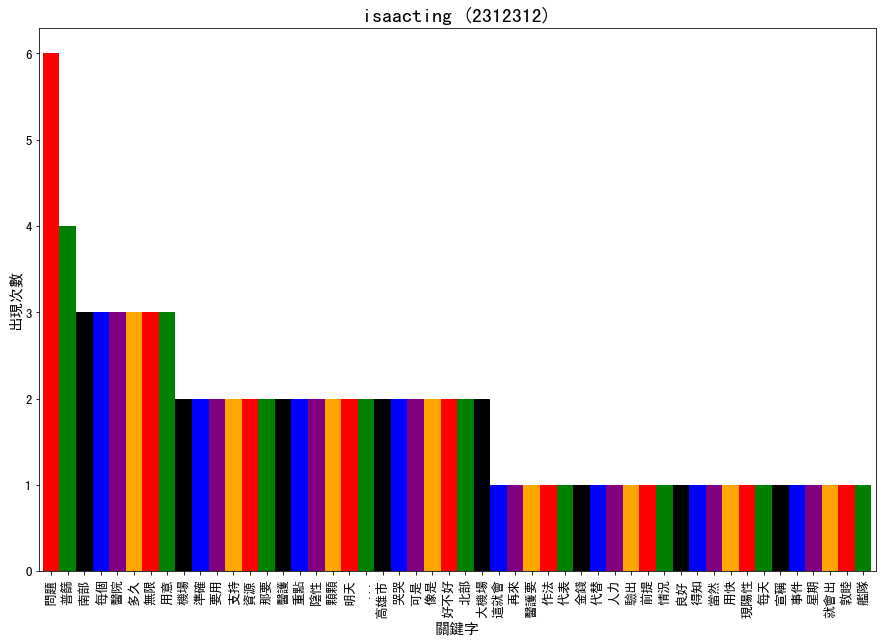

<Figure size 432x288 with 0 Axes>

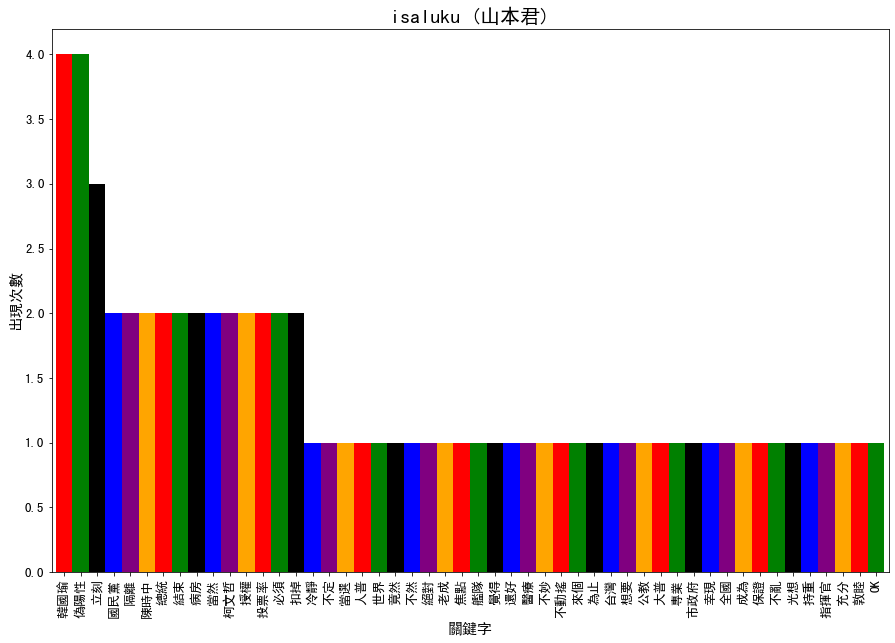

<Figure size 432x288 with 0 Axes>

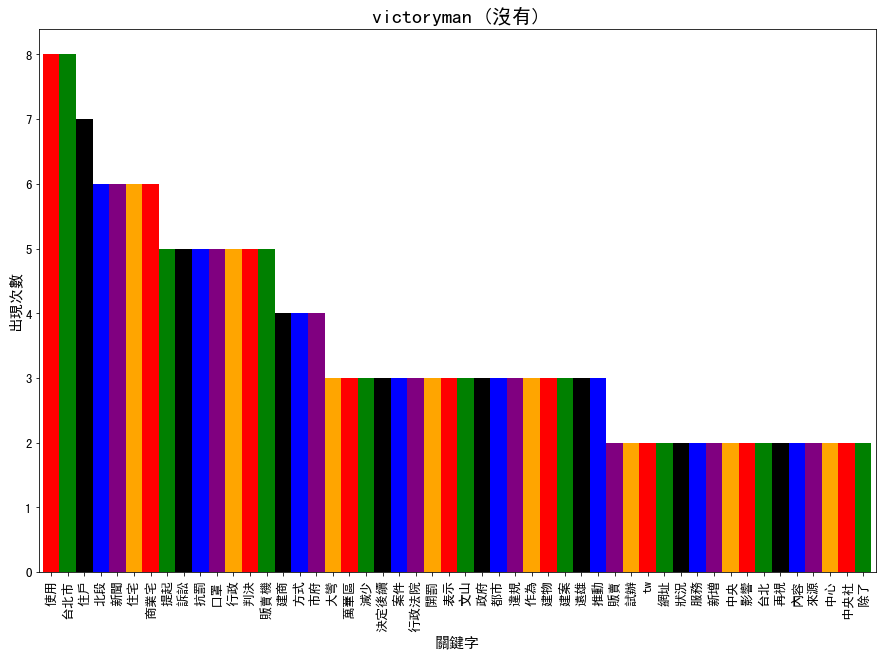

<Figure size 432x288 with 0 Axes>

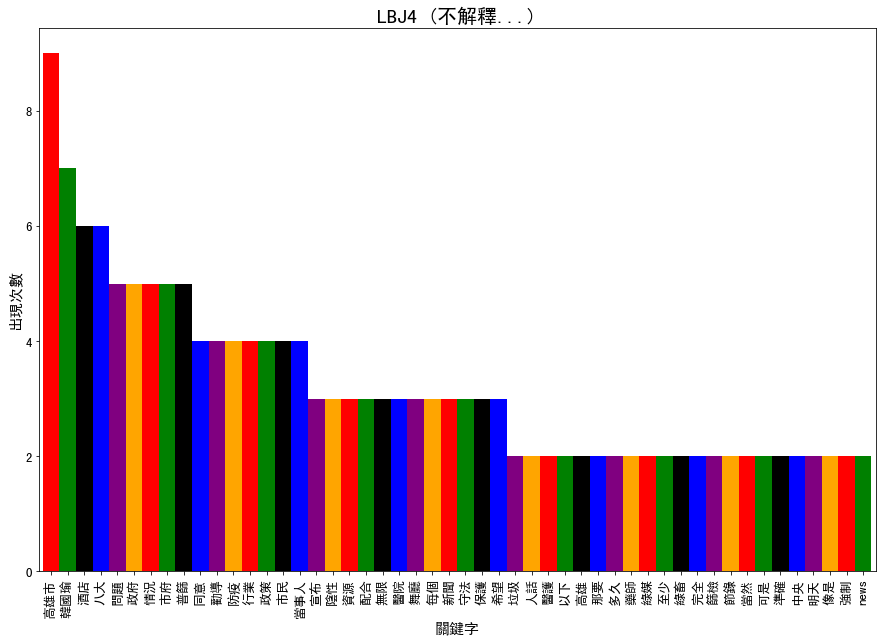

<Figure size 432x288 with 0 Axes>

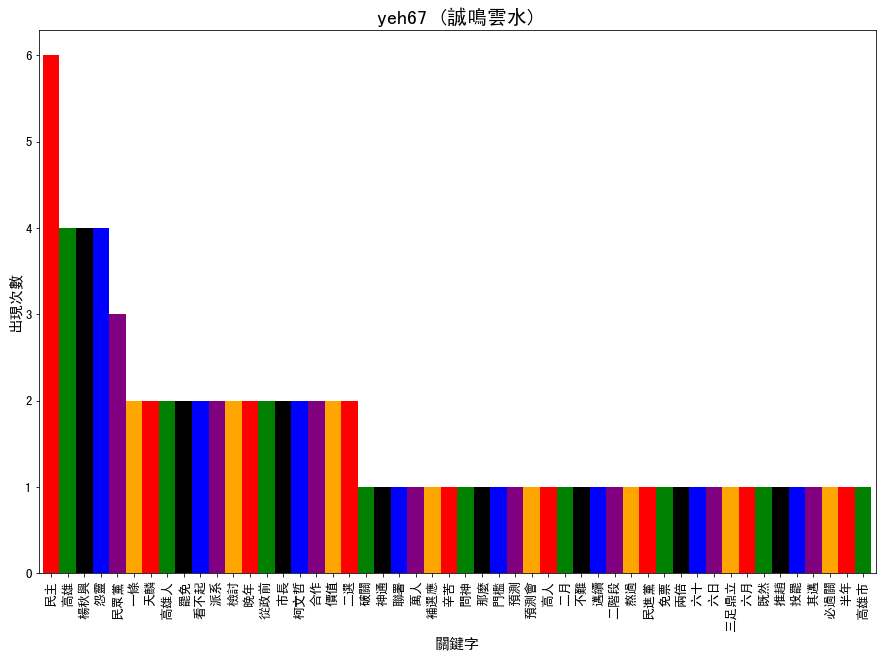

<Figure size 432x288 with 0 Axes>

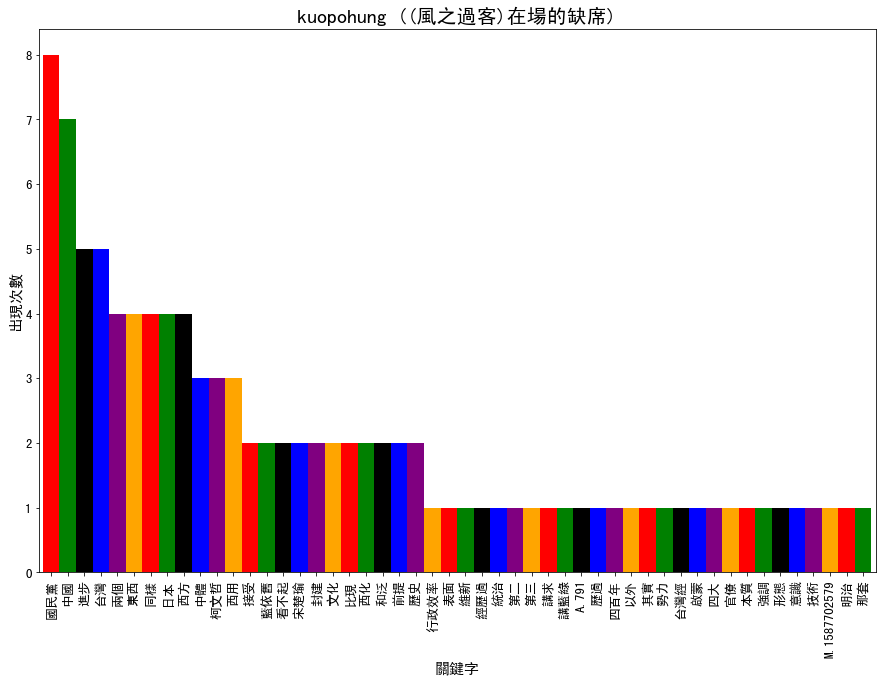

<Figure size 432x288 with 0 Axes>

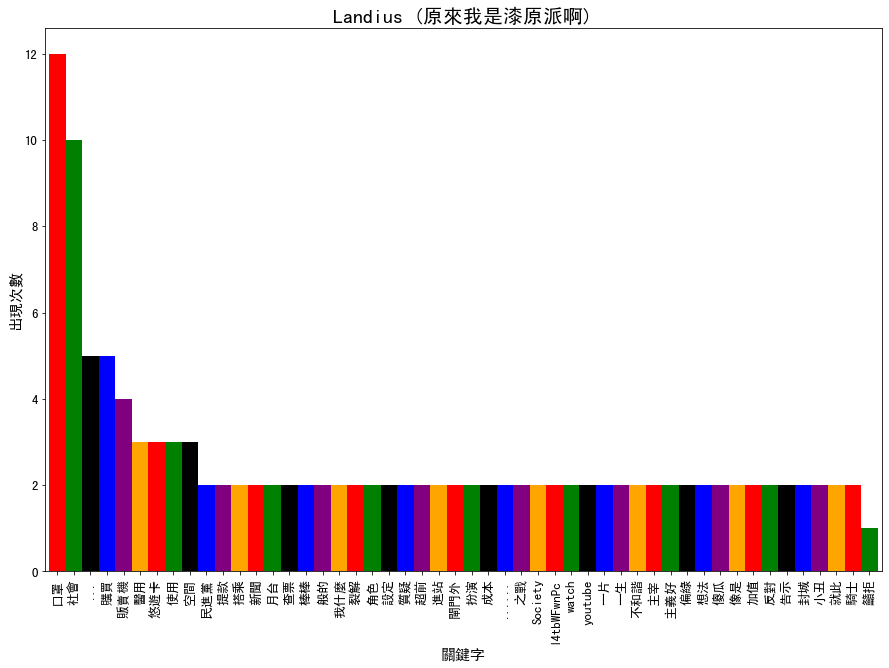

<Figure size 432x288 with 0 Axes>

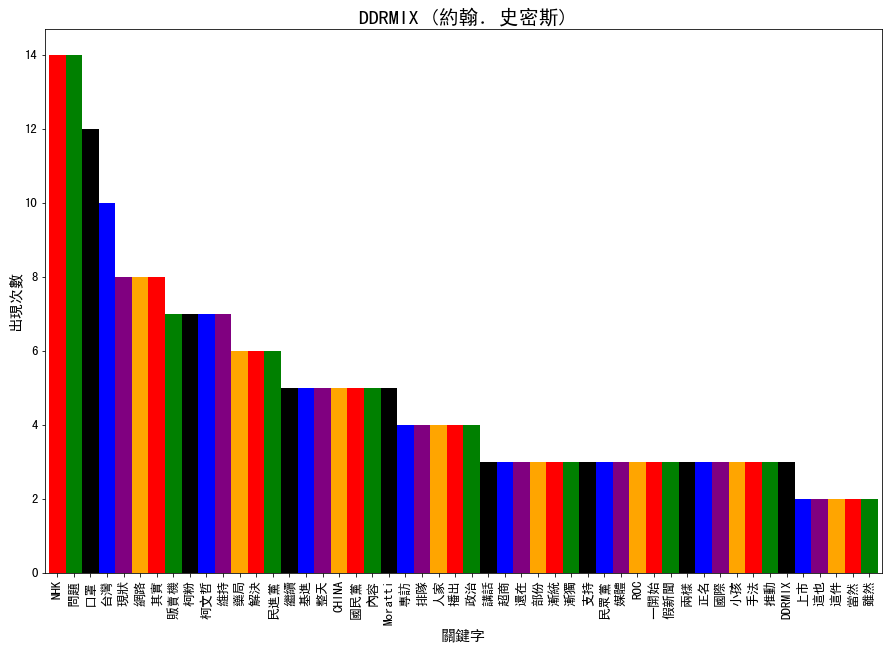

<Figure size 432x288 with 0 Axes>

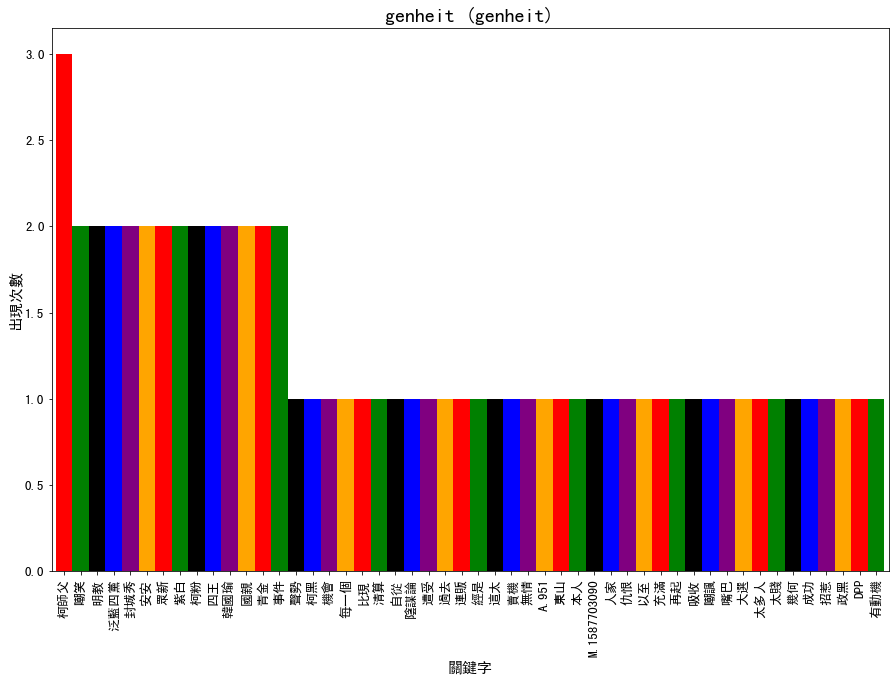

<Figure size 432x288 with 0 Axes>

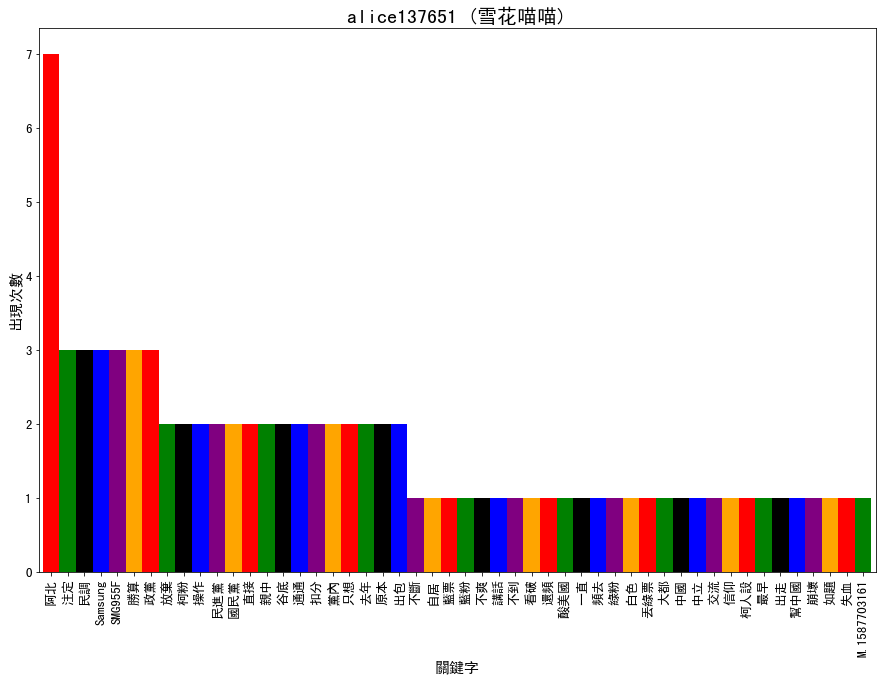

<Figure size 432x288 with 0 Axes>

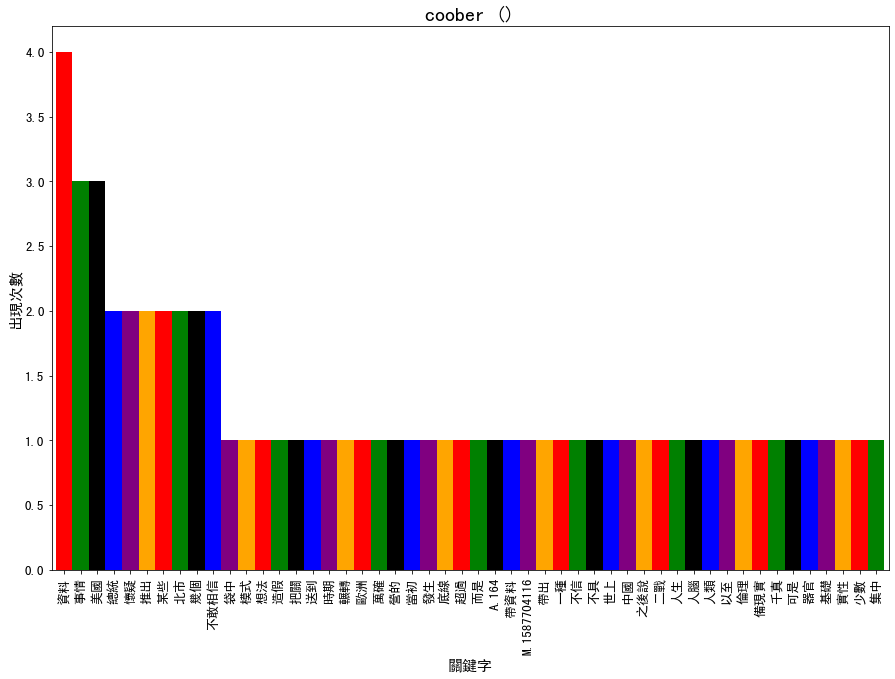

<Figure size 432x288 with 0 Axes>

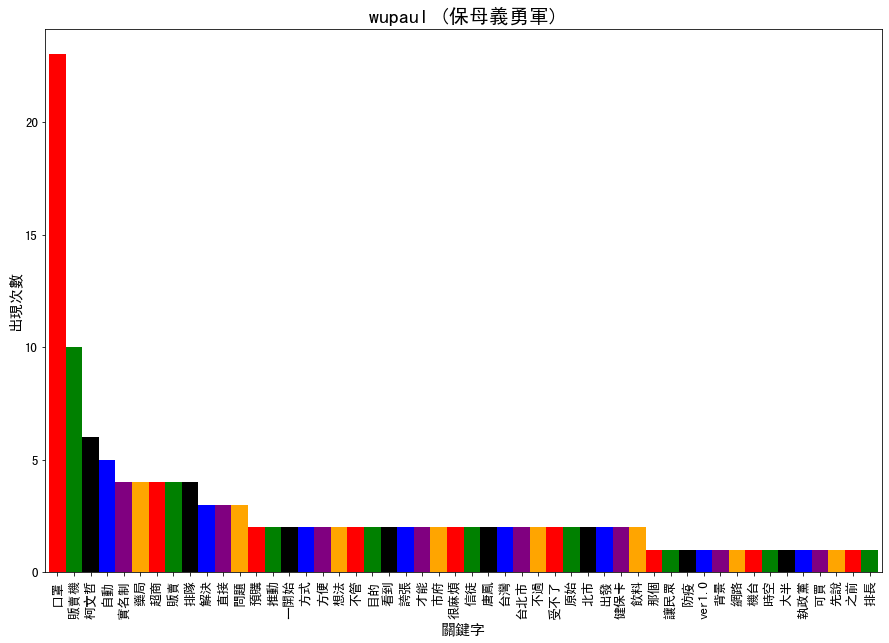

<Figure size 432x288 with 0 Axes>

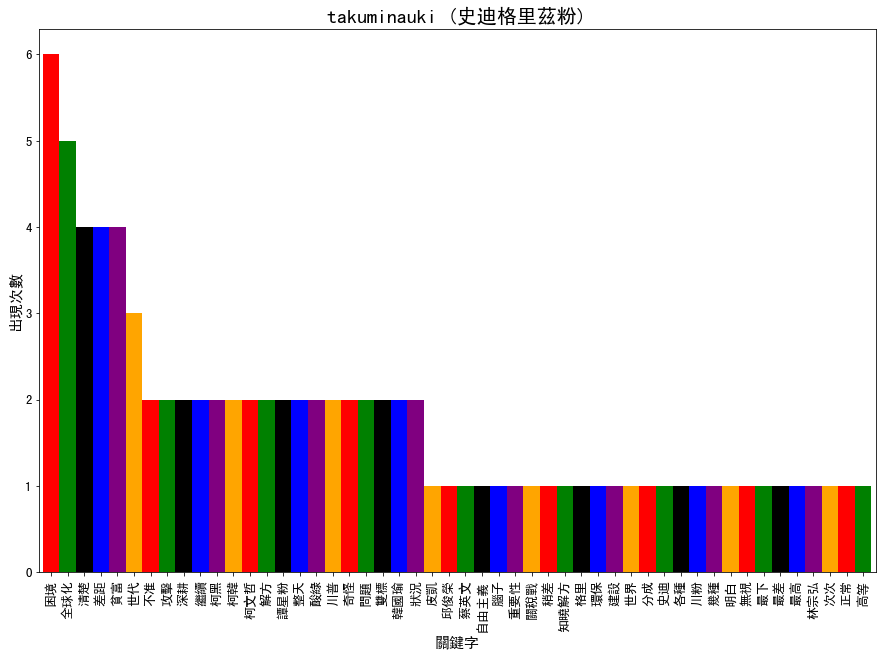

<Figure size 432x288 with 0 Axes>

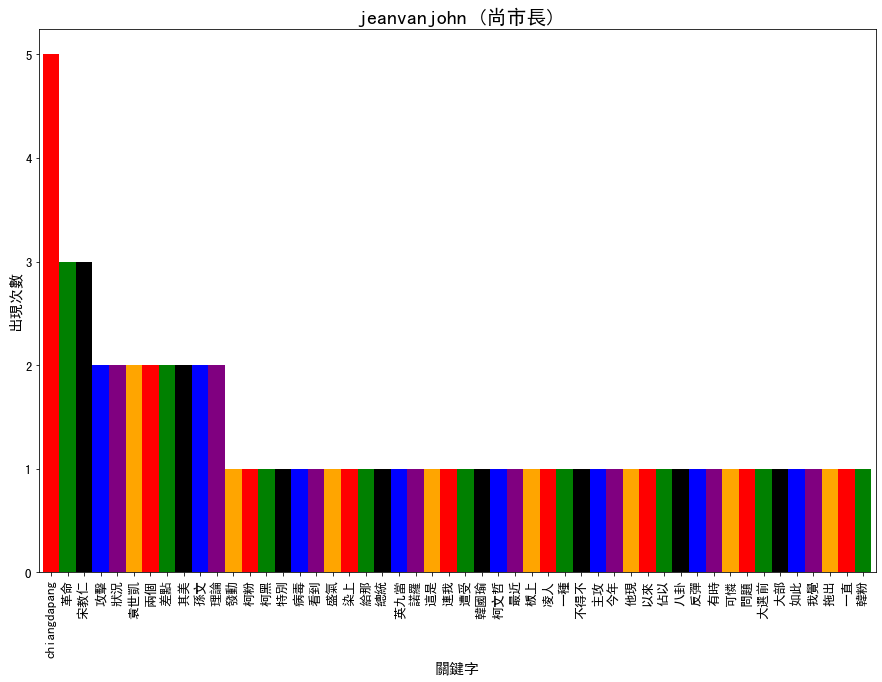

<Figure size 432x288 with 0 Axes>

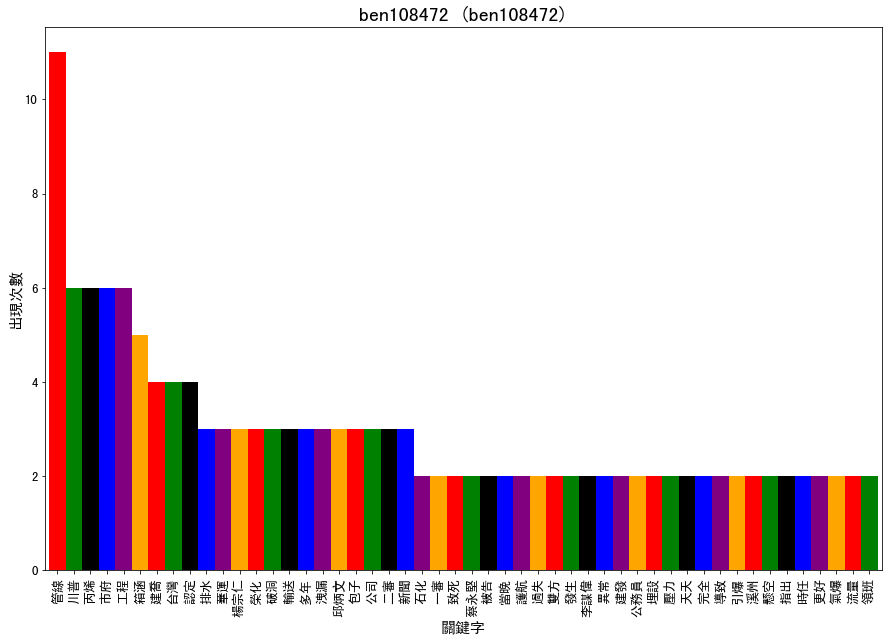

<Figure size 432x288 with 0 Axes>

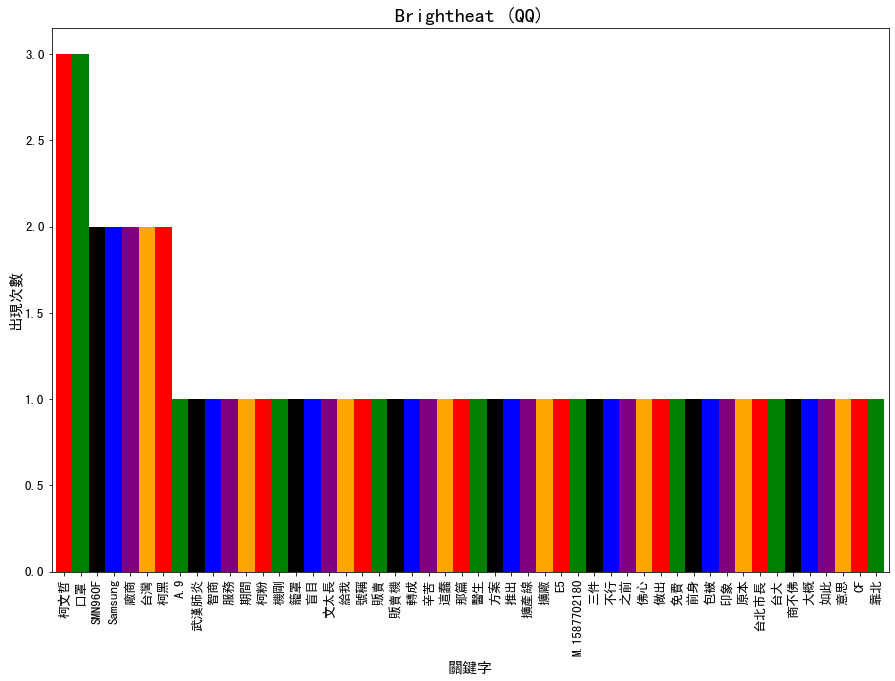

<Figure size 432x288 with 0 Axes>

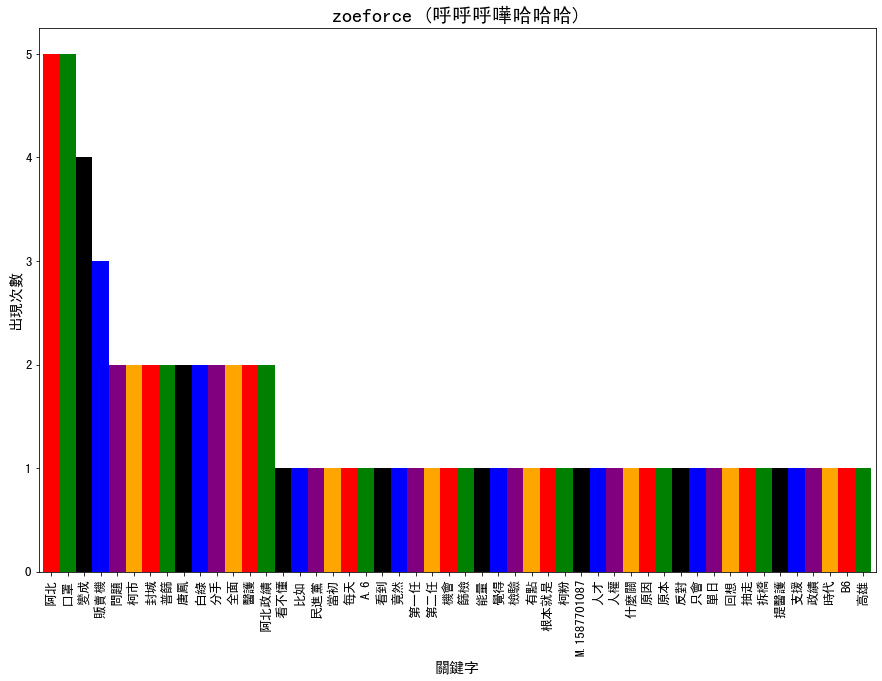

<Figure size 432x288 with 0 Axes>

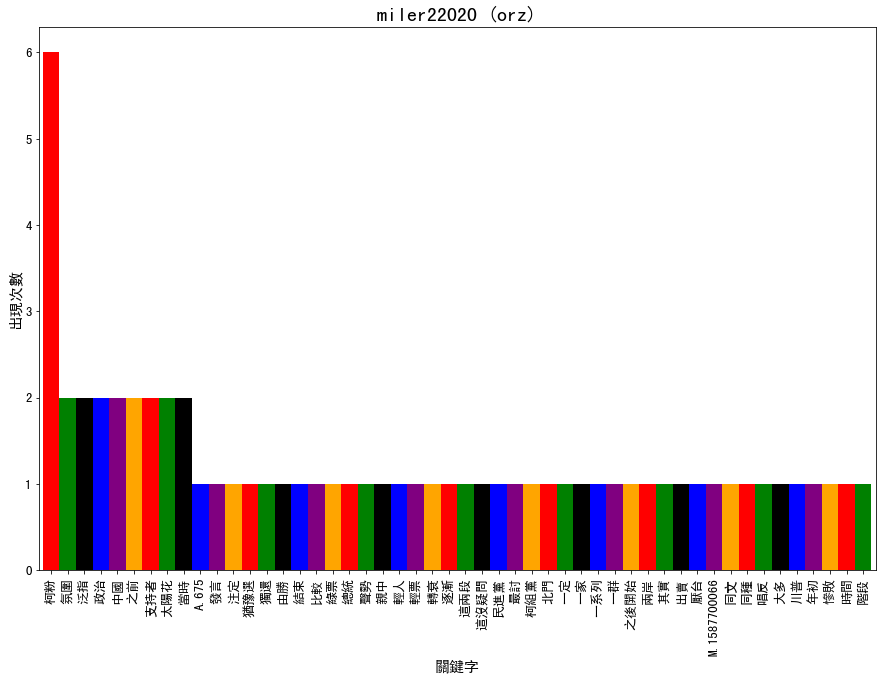

<Figure size 432x288 with 0 Axes>

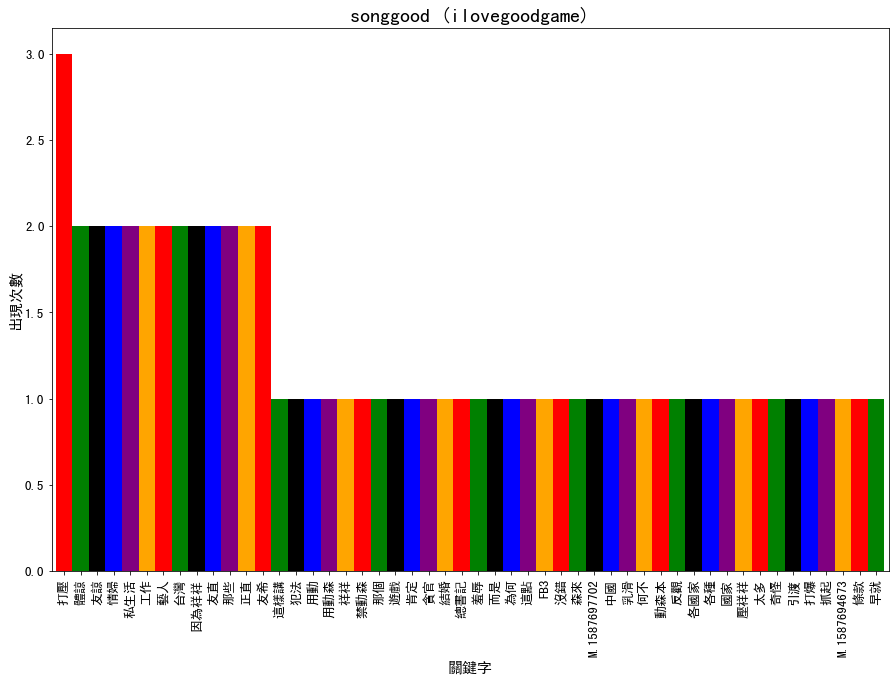

<Figure size 432x288 with 0 Axes>

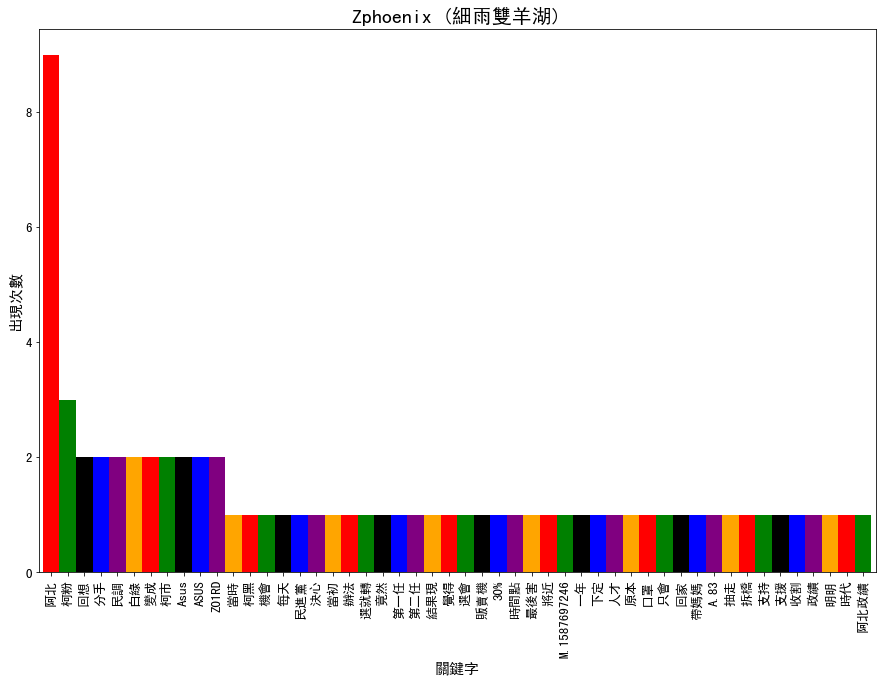

<Figure size 432x288 with 0 Axes>

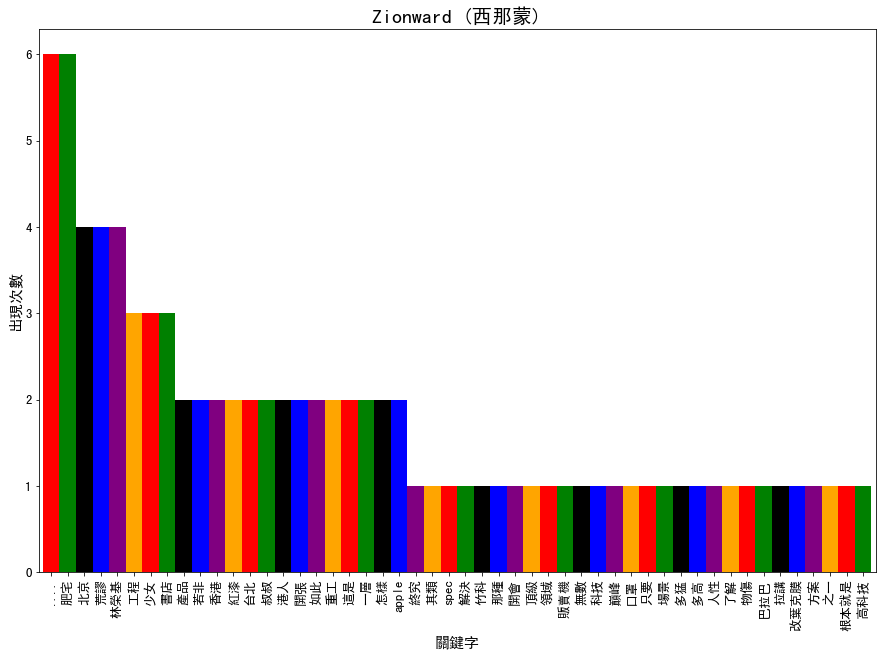

<Figure size 432x288 with 0 Axes>

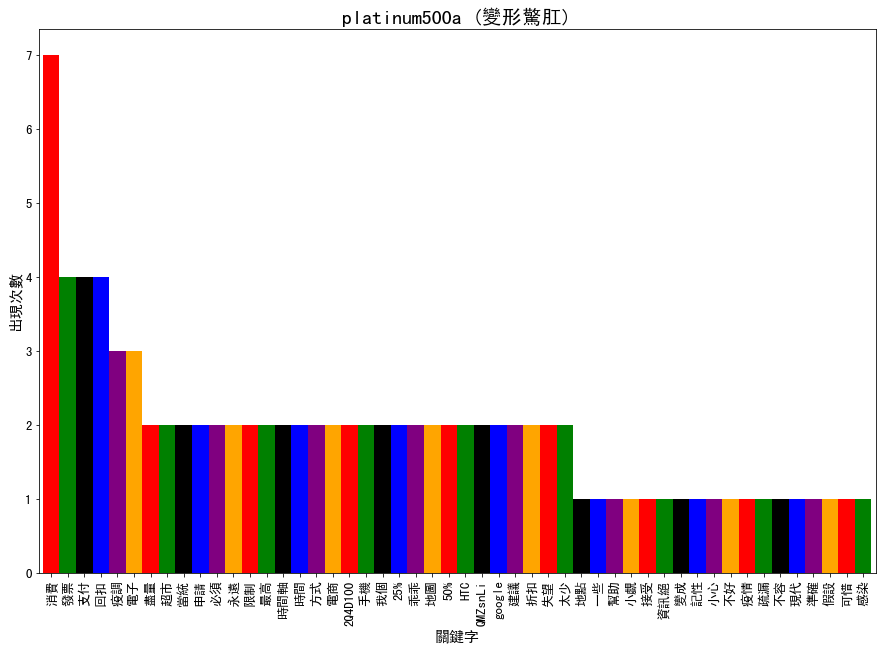

<Figure size 432x288 with 0 Axes>

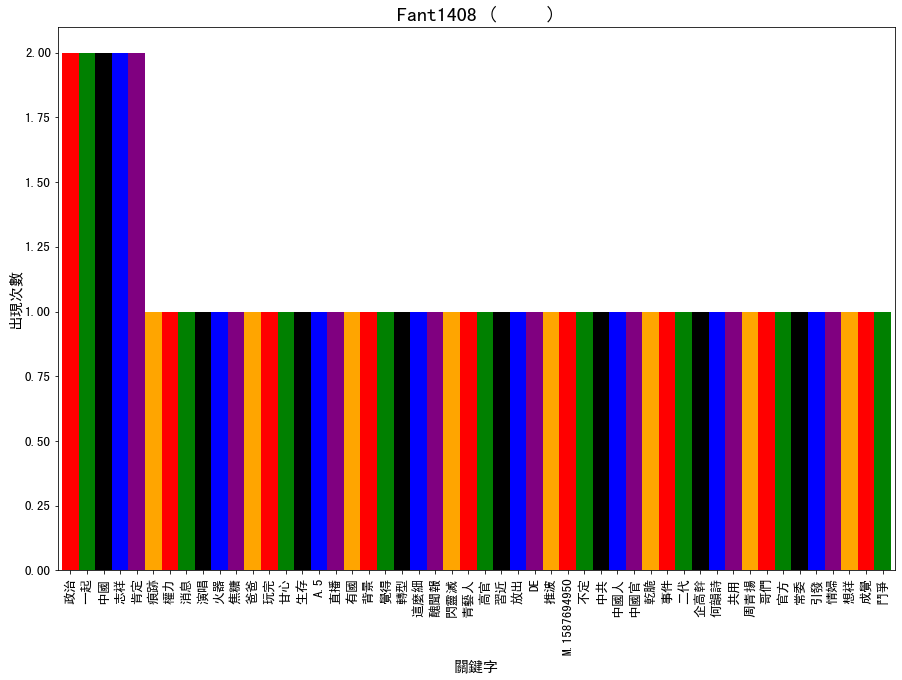

<Figure size 432x288 with 0 Axes>

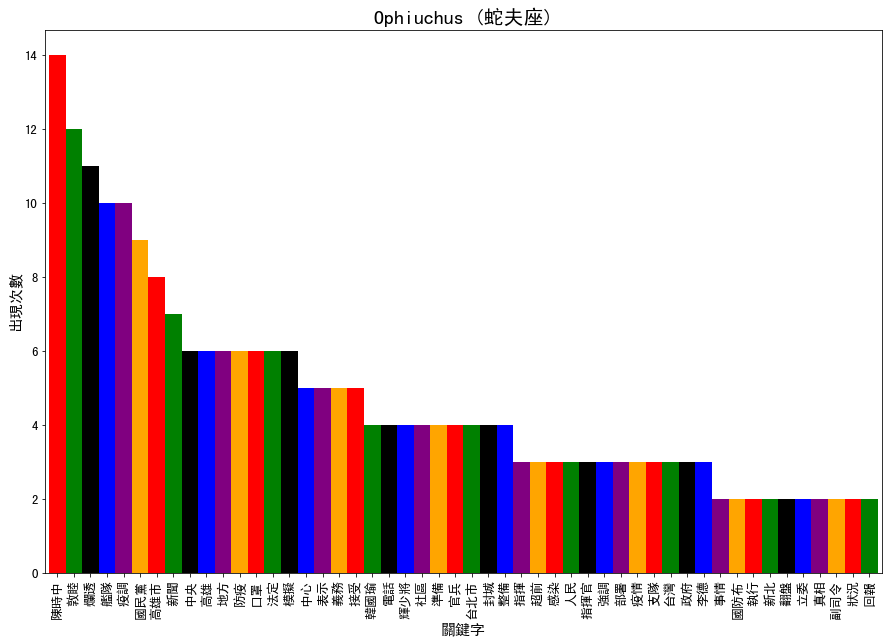

<Figure size 432x288 with 0 Axes>

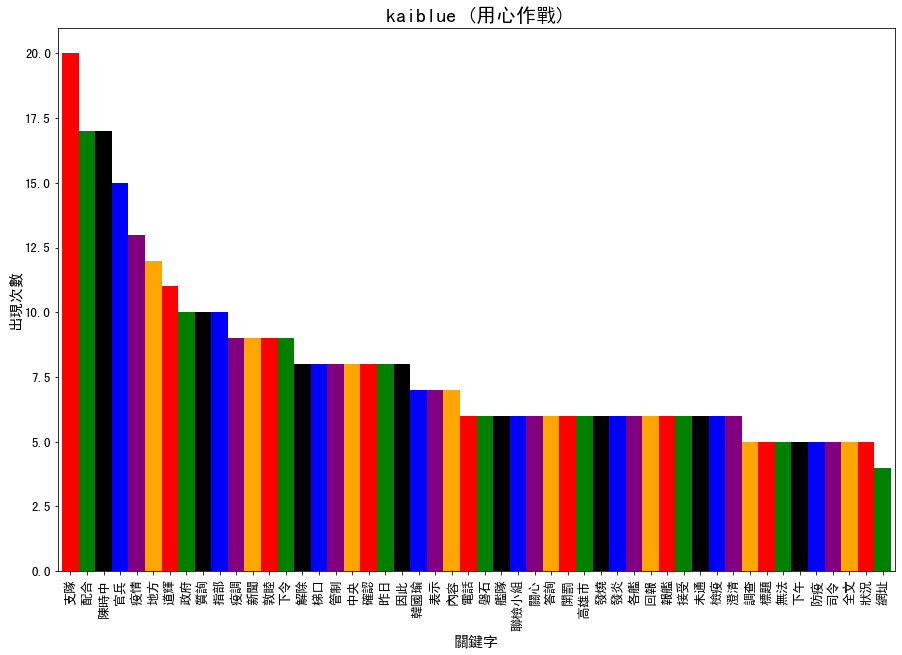

<Figure size 432x288 with 0 Axes>

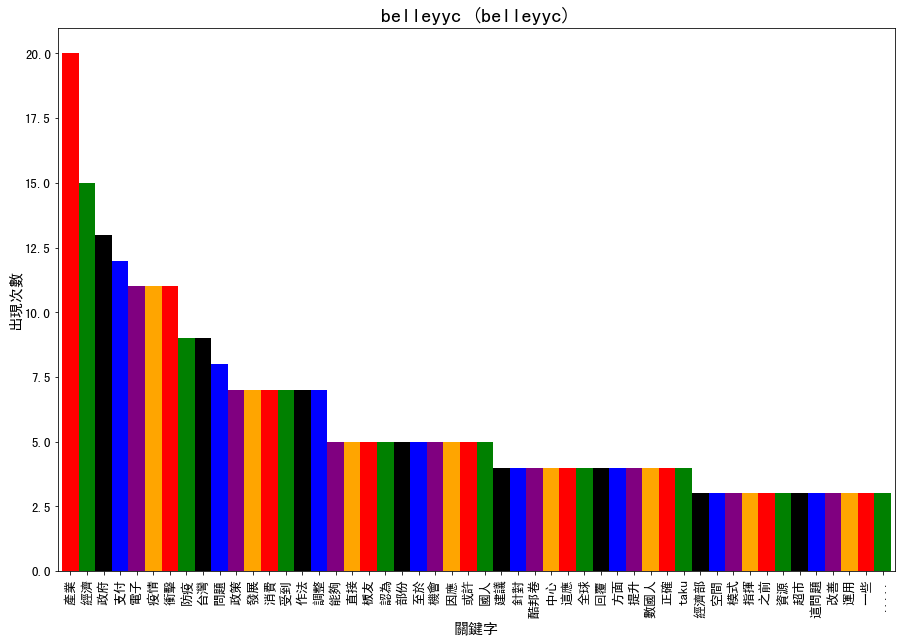

In [509]:
#分析10個不同帳號的政治立場
account_num = 10
for idx in more_accountIP_index:
    ##同一個帳號的文章整合
    # 帳號
    policy_account = dataPd[dataPd.ip == dataPd.ip[idx]].article_author[idx]
        
    
    # 文章
    policy_context = list(dataPd[dataPd.ip == dataPd.ip[idx]].article_content)
    policy_context = ' '.join(policy_context)
    
    # 劃分詞頻率圖
    policy_words_frequency = return_jieba_word(policy_context)[1]
    pltTitle = policy_account
    plotWordFrequency(policy_words_frequency, pltTitle, False)
    

In [555]:
# 10個不同帳號的詞頻做成dataFrame
account_context = []
account_num = 10
frequency_num = 5
for idx in more_accountIP_index:
    personl_context = []
    ##同一個帳號的文章整合
    # 帳號
    policy_account = dataPd[dataPd.ip == dataPd.ip[idx]].article_author[idx]
    personl_context.append(policy_account)
        
    
    # 文章
    policy_context = list(dataPd[dataPd.ip == dataPd.ip[idx]].article_content)
    policy_context = ' '.join(policy_context)
    
    # 前5個高頻分詞頻率
    policy_words_frequency = return_jieba_word(policy_context)[1][:frequency_num]
    personl_context.append(policy_words_frequency)
#     account_context[policy_account] = policy_words_frequency
    account_context.append(personl_context)

In [558]:
personal_policyPd = pd.DataFrame(account_context[:10])
personal_policyPd

0                                                  1
0  ReiFan (說好的秒速5公分呢?)      [(消毒, 4), (新聞, 3), (指揮, 3), (中心, 3), (確診, 3)]
1  bebehome (bebehome)     [(口罩, 13), (反對, 6), (先去, 6), (越南, 6), (外交, 5)]
2        h0304 (h0304)  [(口罩, 12), (販賣機, 10), (韓國瑜, 4), (意度, 4), (罷免, 4)]
3          acln0816 ()   [(口罩, 19), (限制, 12), (預購, 9), (問題, 6), (實名制, 6)]
4       zxc445567 (飄飄)      [(口罩, 2), (改用, 2), (應急, 2), (主要, 2), (領取, 2)]
5       dakkk (我是牛我反芻)     [(偽陽性, 4), (病房, 3), (政治, 3), (能力, 3), (立刻, 2)]
6      nogood (nogood)     [(萬票, 3), (酒店, 2), (駐點, 2), (柯韓, 2), (女失業, 1)]
7      weni302 (鏡花水月號)   [(侯友宜, 10), (拆除, 10), (五股, 6), (地主, 6), (業者, 6)]
8        AGODFATHER ()     [(排隊, 3), (限制, 3), (販賣, 2), (販賣機, 2), (快速, 2)]
9         goetze (異教神)      [(白壇, 6), (嚴歸, 6), (狀況, 4), (去年, 4), (台灣, 4)]

# 功能測試

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

myfont = fm.FontProperties(fname="/Users/karenwang/Desktop/Program/Python/SpiderCourse/PythonHW/ProjectData/Noto_Sans_TC/NotoSansTC-Thin.otf")
plt.bar(['你好', '我', 'english'], height=[1, 2, 3], color = ['r', 'b', 'g'])
plt.xticks(rotation=0)
plt.xlabel("關鍵字", fontproperties=myfont, size=15)
plt.ylabel("出現次數", fontproperties=myfont, size=15)
plt.grid(False)


In [ ]:
# 預設使用字型路徑
from matplotlib.font_manager import findfont, FontProperties

findfont(FontProperties(family=FontProperties().get_family()))

In [ ]:
cd ..